# Selecting Bunches based on Long Range Interactions for Beam 1

In [10]:
from pathlib import Path
from LHC_FillingPattern import LHCFillingPattern 
import matplotlib.pyplot as plt
import numpy as np
import dask.dataframe as dd
import pandas as pd
from pprint import pprint
import math

In [11]:
fill_number = 10709
DATADIR = Path('/eos/project/l/lhc-lumimod/LuminosityFollowUp/2025/')
RAWDATA = DATADIR / 'rawdata'
fpat = LHCFillingPattern(fill_number, RAWDATA)
#fpat.info()
#dir(fpat)

In [12]:
import dask.dataframe as dd

# point to the folder or file
df = dd.read_parquet(DATADIR, engine="pyarrow")

# this will be a list of all column names in your dataset
all_cols = list(df.columns)

# filter only those that start with "B"
b_modes = [c for c in all_cols if c.startswith("B")]

print("Found B-modes:", b_modes)


Found B-modes: []


In [13]:
fpat.collbid_ip15

{'B1': array([  55,   56,   57, ..., 3432, 3433, 3434]),
 'B2': array([  55,   56,   57, ..., 3432, 3433, 3434])}

In [14]:
fpat.bunchtrainsDF_b1

id  bid_first  bid_last  \
0    0         12        23   
1    1         55        90   
2    2         98       133   
3    3        141       176   
4    4        208       243   
..  ..        ...       ...   
64  64       3203      3238   
65  65       3270      3305   
66  66       3313      3348   
67  67       3356      3391   
68  68       3399      3434   

                                                 bids  nbunches  gap  
0    [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]        12  142  
1   [55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 6...        36   32  
2   [98, 99, 100, 101, 102, 103, 104, 105, 106, 10...        36    8  
3   [141, 142, 143, 144, 145, 146, 147, 148, 149, ...        36    8  
4   [208, 209, 210, 211, 212, 213, 214, 215, 216, ...        36   32  
..                                                ...       ...  ...  
64  [3203, 3204, 3205, 3206, 3207, 3208, 3209, 321...        36    8  
65  [3270, 3271, 3272, 3273, 3274, 3275, 3276, 327...        36   32  
66  [3313, 3314, 3315, 3316, 3317, 3318, 3319, 332...        36    8  
67  [3356, 3357, 3358, 3359, 3360, 3361, 3362, 336...        36    8  
68  [3399, 3400, 3401, 3402, 3403, 3404, 3405, 340...        36    8  

[69 rows x 6 columns]

In [15]:
#Remove id = 0 
fpat.bunchtrainsDF_b1 = fpat.bunchtrainsDF_b1[fpat.bunchtrainsDF_b1['id'] != 0]
fpat.bunchtrainsDF_b1

id  bid_first  bid_last  \
1    1         55        90   
2    2         98       133   
3    3        141       176   
4    4        208       243   
5    5        251       286   
..  ..        ...       ...   
64  64       3203      3238   
65  65       3270      3305   
66  66       3313      3348   
67  67       3356      3391   
68  68       3399      3434   

                                                 bids  nbunches  gap  
1   [55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 6...        36   32  
2   [98, 99, 100, 101, 102, 103, 104, 105, 106, 10...        36    8  
3   [141, 142, 143, 144, 145, 146, 147, 148, 149, ...        36    8  
4   [208, 209, 210, 211, 212, 213, 214, 215, 216, ...        36   32  
5   [251, 252, 253, 254, 255, 256, 257, 258, 259, ...        36    8  
..                                                ...       ...  ...  
64  [3203, 3204, 3205, 3206, 3207, 3208, 3209, 321...        36    8  
65  [3270, 3271, 3272, 3273, 3274, 3275, 3276, 327...        36   32  
66  [3313, 3314, 3315, 3316, 3317, 3318, 3319, 332...        36    8  
67  [3356, 3357, 3358, 3359, 3360, 3361, 3362, 336...        36    8  
68  [3399, 3400, 3401, 3402, 3403, 3404, 3405, 340...        36    8  

[68 rows x 6 columns]

In [16]:
# How many Bunches are in Each Unique Train Pattern 
print(fpat.bunchtrainsDF_b1['nbunches'].unique())
print(fpat.bunchtrainsDF_b1['nbunches'].value_counts())
print(fpat.bunchtrainsDF_b1['gap'].unique())
print(fpat.bunchtrainsDF_b1['gap'].value_counts())

[36]
nbunches
36    68
Name: count, dtype: int64
[32  8 63]
gap
8     49
32    18
63     1
Name: count, dtype: int64


### Comparing Beam 1 and Beam 2 Filling Pattern

In [17]:
def compare_filling_patterns(fpat):
    """Print a report comparing the filling pattern of B1 and B2."""
    # 1)individual filled slots
    b1_slots = set(fpat.bunches_b1)
    b2_slots = set(fpat.bunches_b2)

    only_b1 = sorted(b1_slots - b2_slots)
    only_b2 = sorted(b2_slots - b1_slots)
    # 2)  train list equality?  (same bid_first / bid_last pairs)
    df1 = (fpat.bunchtrainsDF_b1.sort_values(["bid_first"])
                                      .reset_index(drop=True))
    df2 = (fpat.bunchtrainsDF_b2.sort_values(["bid_first"])
                                      .reset_index(drop=True))

    common_cols = ["bid_first", "bid_last"]
    trains_equal = df1[common_cols].equals(df2[common_cols])
    # 3)  meta-data differences for trains present in both beams
    meta_cols = ["nbunches", "gap"]
    merged = (df1.merge(df2, on=common_cols, suffixes=("_B1", "_B2"))
                 .loc[:, common_cols + [c + s for c in meta_cols
                                         for s in ("_B1", "_B2")]])
    # keep only rows where any meta column differs
    meta_diff = merged[
        (merged["nbunches_B1"] != merged["nbunches_B2"]) |
        (merged["gap_B1"]       != merged["gap_B2"])
    ]
    print("="*60)
    print("Filled slots identical? ", "YES" if not only_b1 and not only_b2 else "NO")
    if only_b1:
        print(f"  Slots present only in B1 ({len(only_b1)}): {only_b1}")
    if only_b2:
        print(f"  Slots present only in B2 ({len(only_b2)}): {only_b2}")

    print("\nTrain list identical (bid_first/bid_last)? ", "YES" if trains_equal else "NO")
    if not trains_equal:
        t1 = set(map(tuple, df1[common_cols].values))
        t2 = set(map(tuple, df2[common_cols].values))
        only_train_b1 = sorted(t1 - t2)
        only_train_b2 = sorted(t2 - t1)
        if only_train_b1:
            print(f"  Trains only in B1: {only_train_b1}")
        if only_train_b2:
            print(f"  Trains only in B2: {only_train_b2}")

    if not meta_diff.empty:
        print("\nPer-train meta-data differences (nbunches / gap):")
        pprint(meta_diff.to_dict("records"), compact=True)

    if (not only_b1 and not only_b2
        and trains_equal and meta_diff.empty):
        print("✅  Beam 1 and Beam 2 filling patterns are identical in every aspect.")
compare_filling_patterns(fpat)


Filled slots identical?  NO
  Slots present only in B1 (12): [np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23)]
  Slots present only in B2 (12): [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11)]

Train list identical (bid_first/bid_last)?  NO
  Trains only in B2: [(np.int64(0), np.int64(11))]

Per-train meta-data differences (nbunches / gap):
[{'bid_first': 55,
  'bid_last': 90,
  'gap_B1': 32,
  'gap_B2': 44,
  'nbunches_B1': 36,
  'nbunches_B2': 36}]


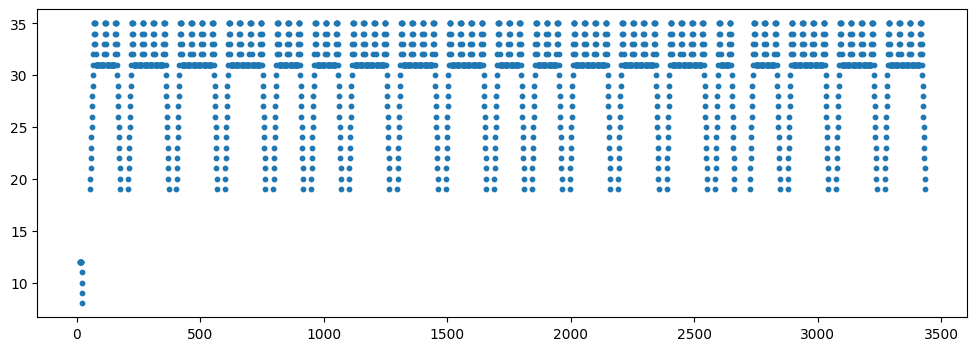

In [18]:
beam = 'B1'          # 'B1' or 'B2'
ip   = 'ip1'         # 'ip1', 'ip2', 'ip5', 'ip8'

# LR array and "filled + LR>0" flag
lr = fpat.lrencounters[beam][ip]               # length-3564 array
filled = fpat.bunches_b1 if beam == 'B1' else fpat.bunches_b2

is_filled_lr = np.zeros(3564, dtype=bool)
is_filled_lr[filled] = lr[filled] > 0   
plt.figure(figsize=(12, 4))
slots = np.arange(3564)
# Plot all filled bunches with LR > 0
plt.scatter(slots[is_filled_lr], lr[is_filled_lr], color='tab:blue', s=10, label='All filled bunches')

#### First and Last bunches 

In [19]:
# Get the corresponding LR values from the lr array
bid_firsts = fpat.bunchtrainsDF_b1['bid_first'].values
lr_values = lr[bid_firsts]
#holds both the first bunch data and the corresponding lr values
first_bunch_data = np.array(list(zip(bid_firsts, lr_values)), dtype=[('bid_first', int), ('lr', float)])

##### Selecting All, first bunches

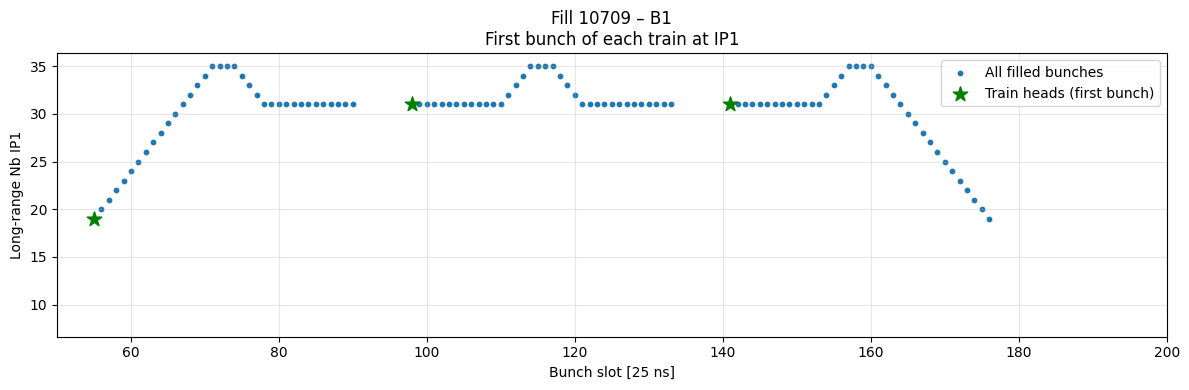

In [20]:

slots = np.arange(3564)
is_filled_lr = np.zeros(3564, dtype=bool)
filled = fpat.bunches_b1 if beam == 'B1' else fpat.bunches_b2
is_filled_lr[filled] = lr[filled] > 0

# Plotting
plt.figure(figsize=(12, 4))

# Plot all filled bunches with LR > 0
plt.scatter(slots[is_filled_lr], lr[is_filled_lr], color='tab:blue', s=10, label='All filled bunches')

# Plot train heads as green stars
plt.scatter(bid_firsts, lr_values, color='green', marker='*', s=120, label='Train heads (first bunch)')

plt.xlabel('Bunch slot [25 ns]')
plt.ylabel(f'Long-range Nb {ip.upper()}')
plt.title(f'Fill {fpat.fill_number} – {beam}\nFirst bunch of each train at {ip.upper()}')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(50,200 )
plt.tight_layout()
plt.show()
orbit_length = 3564


### Family 1

In [21]:
# ── 1.  trains whose LEADING gap is 32 or 63 ──────────────────────────────
trains_gap_long = fpat.bunchtrainsDF_b1[fpat.bunchtrainsDF_b1['gap'].isin([32, 63])]

# ── 2.  first bunch of those trains  (= first after the long gap) ─────────
Family_1 = trains_gap_long['bid_first'].to_numpy()
print("bid_firsts after gap = 32 or 63:\n", Family_1)
print("Number of such trains:", len(Family_1))

# ── 3.  corresponding LR values ──────────────────────────────────────────
lr_values_long = lr[Family_1]
print("Corresponding LR values:\n", lr_values_long)



bid_firsts after gap = 32 or 63:
 [  55  208  404  600  796  949 1102 1298 1494 1690 1843 1996 2192 2388
 2584 2725 2878 3074 3270]
Number of such trains: 19
Corresponding LR values:
 [19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19.
 19.]


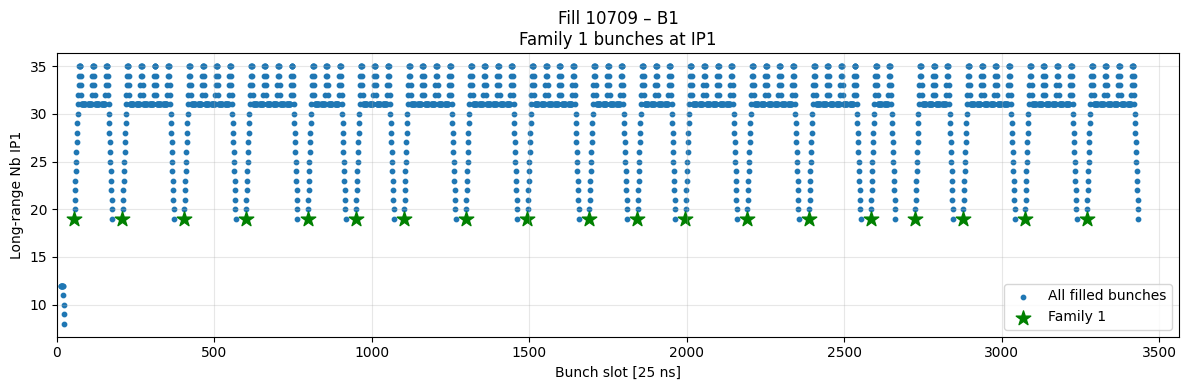

In [22]:
slots   = np.arange(3564)
filled  = fpat.bunches_b1 if beam == "B1" else fpat.bunches_b2

is_filled_lr           = np.zeros_like(slots, dtype=bool)
is_filled_lr[filled]   = lr[filled] > 0          # only filled bunches with LR>0

trains_gap_long   = fpat.bunchtrainsDF_b1[fpat.bunchtrainsDF_b1["gap"].isin([32, 63])]
Family_1   = trains_gap_long["bid_first"].to_numpy(int)
lr_values_long    = lr[Family_1]

plt.figure(figsize=(12, 4))

# all filled bunches with LR>0
plt.scatter(slots[is_filled_lr], lr[is_filled_lr],
            s=10, color="tab:blue", label="All filled bunches")

# train heads after a 32- or 63-slot gap
plt.scatter(Family_1, lr_values_long,
            marker="*", s=120, color="green",
            label="Family 1")

plt.xlabel("Bunch slot [25 ns]")
plt.ylabel(f"Long-range Nb {ip.upper()}")
plt.title(f"Fill {fpat.fill_number} – {beam}\nFamily 1 bunches at {ip.upper()}")
plt.grid(True, alpha=0.3)
plt.legend()
# plt.xlim(50, 250)
plt.xlim(0, orbit_length)
plt.tight_layout()
plt.show()


### Family 2

Last bunches before 32/63-slot gaps:
 [ 176  372  568  764  917 1070 1266 1462 1658 1811 1964 2160 2356 2552
 2662 2846 3042 3238 3434]
Number of such bunches: 19
Corresponding LR values:
 [19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19. 19.
 19.]


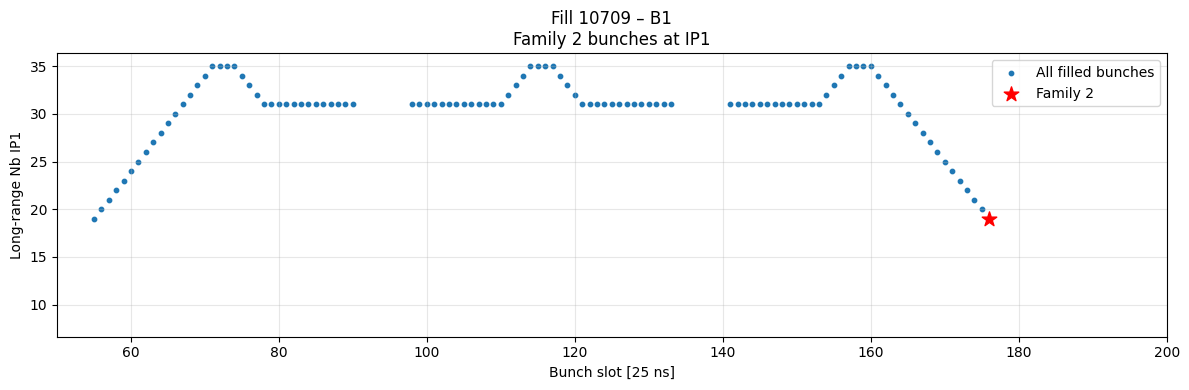

In [23]:
# ─── 0. Prep sorted train list ─────────────────────────────────────────────
df = fpat.bunchtrainsDF_b1.sort_values("bid_first").reset_index(drop=True)
orbit_len = 3564  # full turn

# ─── 1. Compute the gap AFTER each train ──────────────────────────────────
next_start = df["bid_first"].shift(-1).fillna(orbit_len).astype(int)
df["gap_after"] = next_start - df["bid_last"] - 1

# ─── 2. Find the last bunches before a big gap (32 or 63) ─────────────────
mask_big_gap = df["gap_after"]>= 31
Family_2 = df.loc[mask_big_gap, "bid_last"].to_numpy(int)
print("Last bunches before 32/63-slot gaps:\n", Family_2)
print("Number of such bunches:", len(Family_2))

# ─── 3. Get LR values ─────────────────────────────────────────────────────
lr_last = lr[Family_2]
print("Corresponding LR values:\n", lr_last)

# ─── 4. Plot ──────────────────────────────────────────────────────────────
slots   = np.arange(orbit_len)
filled  = fpat.bunches_b1 if beam == "B1" else fpat.bunches_b2
is_filled_lr           = np.zeros_like(slots, dtype=bool)
is_filled_lr[filled]   = lr[filled] > 0

plt.figure(figsize=(12, 4))
plt.scatter(slots[is_filled_lr], lr[is_filled_lr],
            s=10, color="tab:blue", label="All filled bunches")

plt.scatter(Family_2, lr_last,
            marker="*", s=120, color="red",
            label="Family 2")

plt.xlabel("Bunch slot [25 ns]")
plt.ylabel(f"Long-range Nb {ip.upper()}")
plt.title(f"Fill {fpat.fill_number} – {beam}\nFamily 2 bunches at {ip.upper()}")
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(50, 200)
plt.tight_layout()
plt.show()


### Family 3

First-maximum slot of each train:
 [  71  114  157  224  267  310  353  420  463  506  549  616  659  702
  745  812  855  898  965 1008 1051 1118 1161 1204 1247 1314 1357 1400
 1443 1510 1553 1596 1639 1706 1749 1792 1859 1902 1945 2012 2055 2098
 2141 2208 2251 2294 2337 2404 2447 2490 2533 2600 2643 2741 2784 2827
 2894 2937 2980 3023 3090 3133 3176 3219 3286 3329 3372 3415]
Number of such bunches: 68
Corresponding LR values:
 [35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35.
 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35.
 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35.
 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35.]


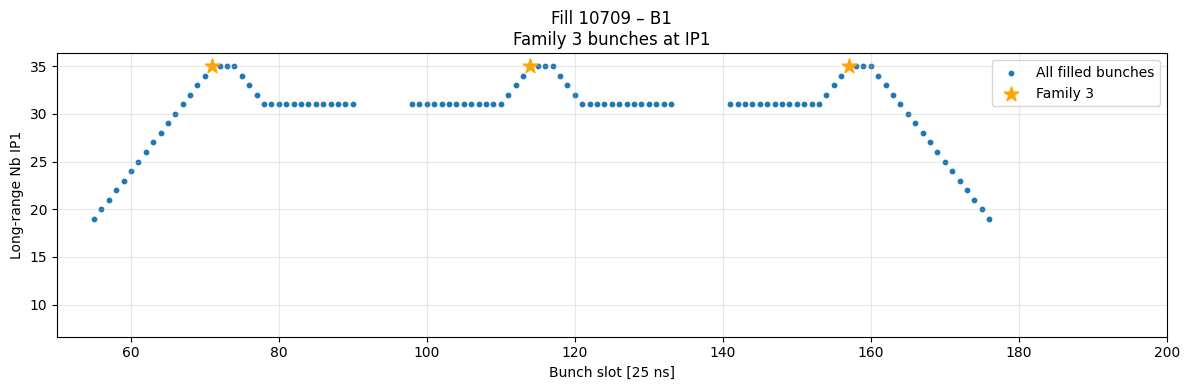

In [24]:
def first_maxima_per_train(df, lr_array):
    peak_slots = []
    peak_vals  = []

    for _, row in df.iterrows():
        bids      = np.asarray(row["bids"], dtype=int)
        lr_train  = lr_array[bids]

        max_val   = lr_train.max()                 # global max in this train
        first_idx = np.where(lr_train == max_val)[0][0]   # first occurrence
        peak_slots.append(bids[first_idx])
        peak_vals.append(max_val)

    return np.array(peak_slots, dtype=int), np.array(peak_vals)


Family_3, peak_vals = first_maxima_per_train(fpat.bunchtrainsDF_b1, lr)

print("First-maximum slot of each train:\n", Family_3)
print("Number of such bunches:", len(Family_3))
print("Corresponding LR values:\n", peak_vals)

slots   = np.arange(3564)
filled  = fpat.bunches_b1 if beam == "B1" else fpat.bunches_b2
is_filled_lr           = np.zeros_like(slots, dtype=bool)
is_filled_lr[filled]   = lr[filled] > 0

plt.figure(figsize=(12, 4))
plt.scatter(slots[is_filled_lr], lr[is_filled_lr],
            s=10, color="tab:blue", label="All filled bunches")

plt.scatter(Family_3, peak_vals,
            marker="*", s=120, color="orange",
            label="Family 3")

plt.xlabel("Bunch slot [25 ns]")
plt.ylabel(f"Long-range Nb {ip.upper()}")
plt.title(f"Fill {fpat.fill_number} – {beam}\nFamily 3 bunches at {ip.upper()}")
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(50,200)
plt.tight_layout()
plt.show()


### Family 4

7-th bunch in each long-gap train:
 [  61  214  410  606  802  955 1108 1304 1500 1696 1849 2002 2198 2394
 2590 2731 2884 3080 3276]
Number of such bunches: 19
Corresponding LR values:
 [25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25.
 25.]


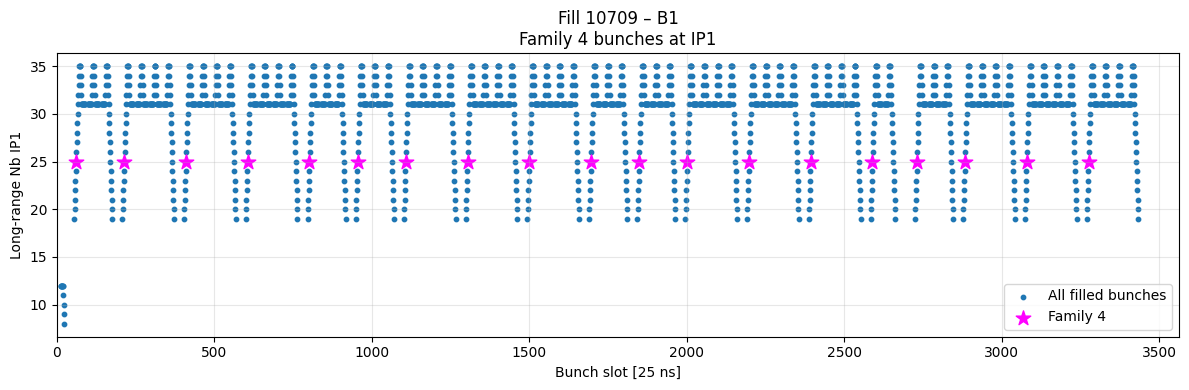

In [25]:
df_gap = fpat.bunchtrainsDF_b1[fpat.bunchtrainsDF_b1['gap'].isin([32, 63])]

Family_4 = (df_gap['bid_first'] + 6).to_numpy(int)
print("7-th bunch in each long-gap train:\n", Family_4)
print("Number of such bunches:", len(Family_4))

bunch7_lr    = lr[Family_4]
print("Corresponding LR values:\n", bunch7_lr)

slots   = np.arange(3564)
filled  = fpat.bunches_b1 if beam == "B1" else fpat.bunches_b2
is_filled_lr           = np.zeros_like(slots, dtype=bool)
is_filled_lr[filled]   = lr[filled] > 0            # only filled bunches with LR>0

plt.figure(figsize=(12, 4))

plt.scatter(slots[is_filled_lr], lr[is_filled_lr],
            s=10, color="tab:blue", label="All filled bunches")
plt.scatter(Family_4, bunch7_lr,
            marker="*", s=120, color="magenta",
            label="Family 4")

plt.xlabel("Bunch slot [25 ns]")
plt.ylabel(f"Long-range Nb {ip.upper()}")
plt.title(f"Fill {fpat.fill_number} – {beam}\nFamily 4 bunches at {ip.upper()}")
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(0, orbit_len)
plt.tight_layout()
plt.show()


### Family 5

15-th bunch in each long-gap train:
 [ 112  155  265  308  351  461  504  547  657  700  743  853  896 1006
 1049 1159 1202 1245 1355 1398 1441 1551 1594 1637 1747 1790 1900 1943
 2053 2096 2139 2249 2292 2335 2445 2488 2531 2641 2782 2825 2935 2978
 3021 3131 3174 3217 3327 3370 3413]
Number of such bunches: 49
Corresponding LR values:
 [33. 33. 33. 33. 33. 33. 33. 33. 33. 33. 33. 33. 33. 33. 33. 33. 33. 33.
 33. 33. 33. 33. 33. 33. 33. 33. 33. 33. 33. 33. 33. 33. 33. 33. 33. 33.
 33. 33. 33. 33. 33. 33. 33. 33. 33. 33. 33. 33. 33.]


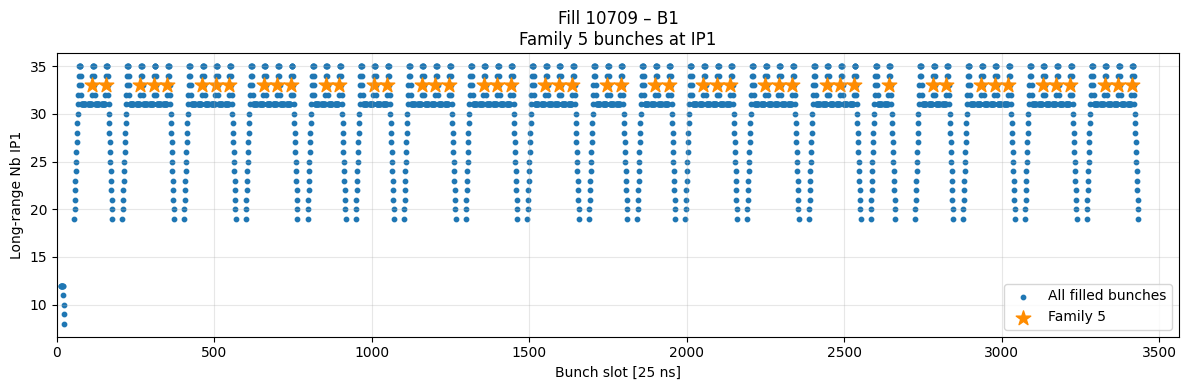

In [26]:
df_gap = (
    fpat.bunchtrainsDF_b1
      .loc[fpat.bunchtrainsDF_b1['gap'].isin([8])]
      .query("nbunches >= 15")               # ensure a 15-th bunch exists
)

Family_5 = (df_gap['bid_first'] + 14).to_numpy(int)
print("15-th bunch in each long-gap train:\n", Family_5)
print("Number of such bunches:", len(Family_5))

# corresponding LR values
bunch15_lr = lr[Family_5]
print("Corresponding LR values:\n", bunch15_lr)

slots  = np.arange(3564)
filled = fpat.bunches_b1 if beam == "B1" else fpat.bunches_b2
is_filled_lr           = np.zeros_like(slots, dtype=bool)
is_filled_lr[filled]   = lr[filled] > 0

plt.figure(figsize=(12, 4))

plt.scatter(slots[is_filled_lr], lr[is_filled_lr],
            s=10, color="tab:blue", label="All filled bunches")

plt.scatter(Family_5, bunch15_lr,
            marker="*", s=120, color="darkorange",
            label="Family 5")

plt.xlabel("Bunch slot [25 ns]")
plt.ylabel(f"Long-range Nb {ip.upper()}")
plt.title(f"Fill {fpat.fill_number} – {beam}\nFamily 5 bunches at {ip.upper()}")
plt.grid(True, alpha=0.3)
plt.legend()
#plt.xlim(50,180)
plt.xlim(0,orbit_len)
plt.tight_layout()
plt.show()


### Family 6

27-th bunch (trains right before a small gap 8): [  81  124  234  277  320  430  473  516  626  669  712  822  865  975
 1018 1128 1171 1214 1324 1367 1410 1520 1563 1606 1716 1759 1869 1912
 2022 2065 2108 2218 2261 2304 2414 2457 2500 2610 2751 2794 2904 2947
 2990 3100 3143 3186 3296 3339 3382]
How many: 49
Corresponding LR values: [31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31.
 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31.
 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31.]


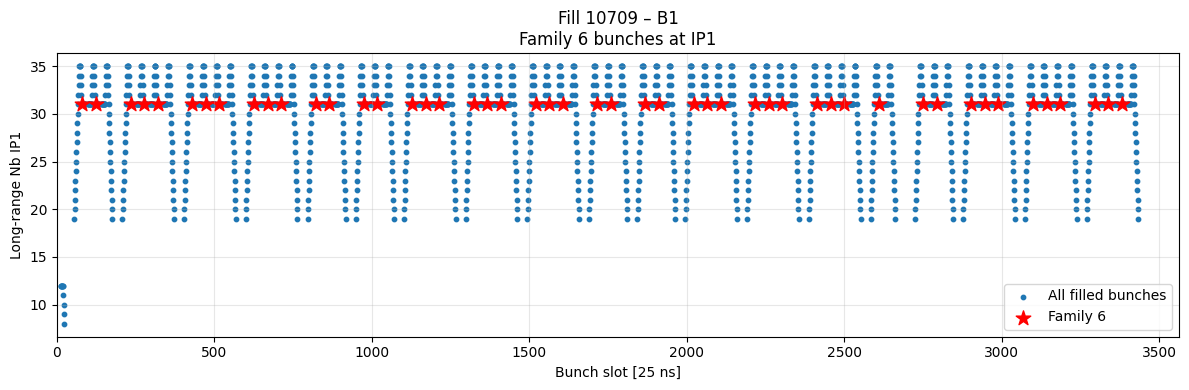

In [27]:
# ── 0.  tidy, gap-before table (gap column is the gap *before* each train) ───
df = fpat.bunchtrainsDF_b1.sort_values("bid_first").reset_index(drop=True)

# ── 1.  find rows where the NEXT train’s gap is 8  →  shift(+1) backward ───
train_before_small_gap = (
    df.shift(1)                              # previous train
      .loc[df["gap"] == 8]                   # only where current gap is 8
      .dropna()                              # drop the first row if needed
      .query("nbunches >= 27")               # ensure 27 bunches exist
)

# ── 2.  slot of the 27-th bunch from the start of each selected train ───────
Family_6 = (train_before_small_gap["bid_first"] + 26).to_numpy(int)
print("27-th bunch (trains right before a small gap 8):", Family_6)
print("How many:", len(Family_6))

# ── 3.  corresponding LR values ─────────────────────────────────────────────
bunch24_lr = lr[Family_6]
print("Corresponding LR values:", bunch24_lr)

# ── 4.  plot ────────────────────────────────────────────────────────────────
orbit_len = 3564
slots     = np.arange(orbit_len)
filled    = fpat.bunches_b1 if beam == "B1" else fpat.bunches_b2
is_filled_lr           = np.zeros_like(slots, dtype=bool)
is_filled_lr[filled]   = lr[filled] > 0

plt.figure(figsize=(12, 4))
plt.scatter(slots[is_filled_lr], lr[is_filled_lr],
            s=10, color="tab:blue", label="All filled bunches")
plt.scatter(Family_6, bunch24_lr,
            marker="*", s=120, color="red",
            label="Family 6")

plt.xlabel("Bunch slot [25 ns]")
plt.ylabel(f"Long-range Nb {ip.upper()}")
plt.title(f"Fill {fpat.fill_number} – {beam}\nFamily 6 bunches at {ip.upper()}")
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(0,orbit_len)
#plt.xlim(50,180)
plt.tight_layout()
plt.show()



### Family 7 


First bunch after each 8-slot gap:
 [  98  141  251  294  337  447  490  533  643  686  729  839  882  992
 1035 1145 1188 1231 1341 1384 1427 1537 1580 1623 1733 1776 1886 1929
 2039 2082 2125 2235 2278 2321 2431 2474 2517 2627 2768 2811 2921 2964
 3007 3117 3160 3203 3313 3356 3399]
Number of such bunches: 49
Corresponding LR values:
 [31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31.
 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31.
 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31.]


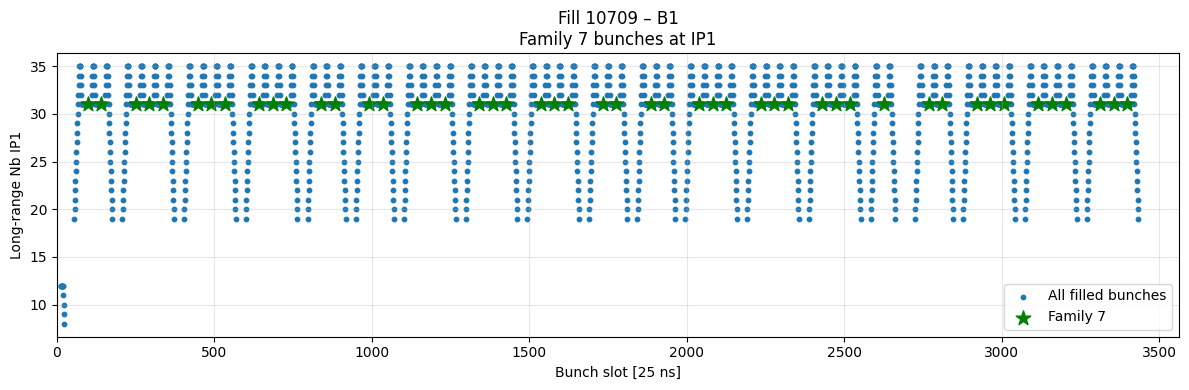

In [28]:

df_small_gap = fpat.bunchtrainsDF_b1.query("gap == 8").copy()

# ── 2.  the first bunch right after that small gap is simply bid_first ────
Family_7 = df_small_gap["bid_first"].astype(int).to_numpy()
print("First bunch after each 8-slot gap:\n", Family_7)
print("Number of such bunches:", len(Family_7))

# ── 3.  corresponding LR values ───────────────────────────────────────────
lr_first_after = lr[Family_7]
print("Corresponding LR values:\n", lr_first_after)

# ── 4.  plot ──────────────────────────────────────────────────────────────
orbit_len = 3564
slots     = np.arange(orbit_len)
filled    = fpat.bunches_b1 if beam == "B1" else fpat.bunches_b2
is_filled_lr           = np.zeros_like(slots, dtype=bool)
is_filled_lr[filled]   = lr[filled] > 0

plt.figure(figsize=(12, 4))
plt.scatter(slots[is_filled_lr], lr[is_filled_lr],
            s=10, color="tab:blue", label="All filled bunches")

plt.scatter(Family_7, lr_first_after,
            marker="*", s=120, color="green",
            label="Family 7")

plt.xlabel("Bunch slot [25 ns]")
plt.ylabel(f"Long-range Nb {ip.upper()}")
plt.title(f"Fill {fpat.fill_number} – {beam}\nFamily 7 bunches at {ip.upper()}")
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(0,orbit_len)
plt.tight_layout()
plt.show()


### Family 8

Last bunch before each 8-slot gap:
 [  90  133  243  286  329  439  482  525  635  678  721  831  874  984
 1027 1137 1180 1223 1333 1376 1419 1529 1572 1615 1725 1768 1878 1921
 2031 2074 2117 2227 2270 2313 2423 2466 2509 2619 2760 2803 2913 2956
 2999 3109 3152 3195 3305 3348 3391]
Number of such bunches: 49
Corresponding LR values:
 [31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31.
 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31.
 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31. 31.]


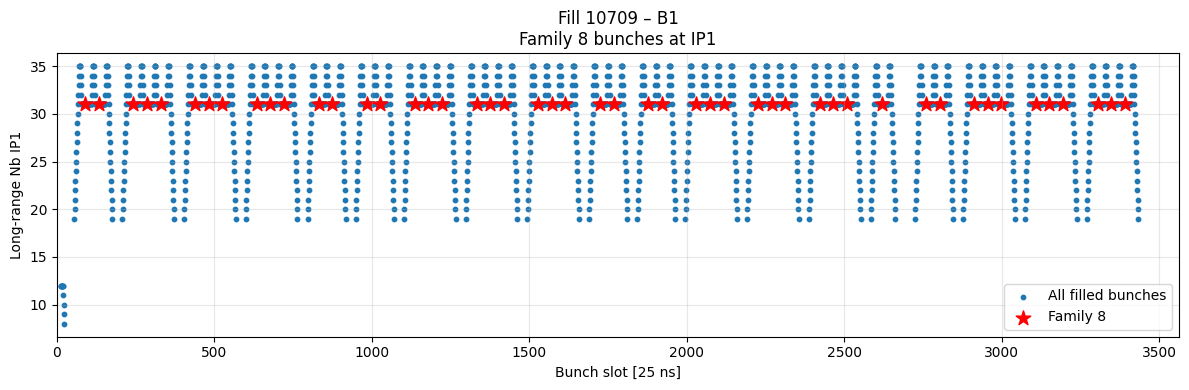

In [29]:

df = fpat.bunchtrainsDF_b1.sort_values("bid_first").reset_index(drop=True)

# ── 1. trains that START after a small gap (gap == 8) ────────────────────
rows_with_small_gap = df["gap"] == 8           # True for each small-gap train

# ── 2. the train *before* each small gap (shift up by 1 row) ─────────────
train_before_gap8 = df.shift(1).loc[rows_with_small_gap].dropna()

# ── 3. its own last bunch is the bunch right before the 8-slot gap ───────
Family_8 = train_before_gap8["bid_last"].astype(int).to_numpy()
print("Last bunch before each 8-slot gap:\n", Family_8)
print("Number of such bunches:", len(Family_8))

# ── 4. corresponding LR values ───────────────────────────────────────────
lr_last_before = lr[Family_8]
print("Corresponding LR values:\n", lr_last_before)

# ── 5. plot ──────────────────────────────────────────────────────────────
orbit_len = 3564
slots     = np.arange(orbit_len)
filled    = fpat.bunches_b1 if beam == "B1" else fpat.bunches_b2
is_filled_lr           = np.zeros_like(slots, dtype=bool)
is_filled_lr[filled]   = lr[filled] > 0

plt.figure(figsize=(12, 4))
plt.scatter(slots[is_filled_lr], lr[is_filled_lr],
            s=10, color="tab:blue", label="All filled bunches")

plt.scatter(Family_8, lr_last_before,
            marker="*", s=120, color="red",
            label="Family 8")

plt.xlabel("Bunch slot [25 ns]")
plt.ylabel(f"Long-range Nb {ip.upper()}")
plt.title(f"Fill {fpat.fill_number} – {beam}\nFamily 8 bunches at {ip.upper()}")
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(0,orbit_len)
plt.tight_layout()
plt.show()


## Classification

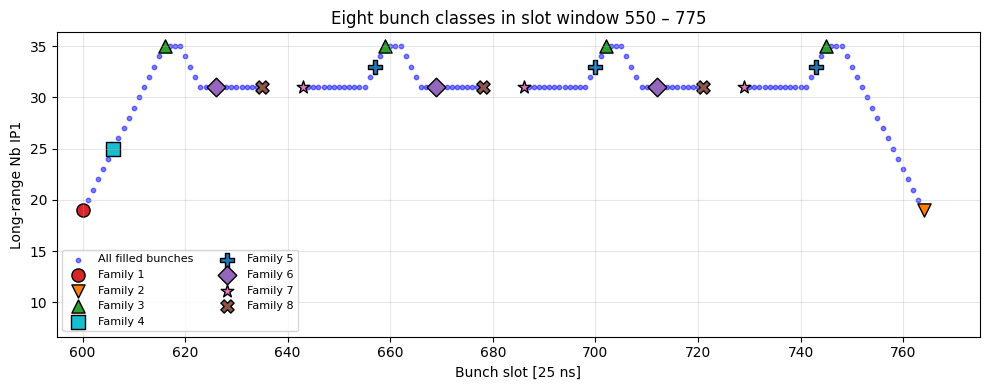

In [30]:
orbit_len = 3564
slots     = np.arange(orbit_len)

filled = fpat.bunches_b1 if beam == "B1" else fpat.bunches_b2
is_filled_lr           = np.zeros_like(slots, dtype=bool)
is_filled_lr[filled]   = lr[filled] > 0          # filled & LR > 0

Family_1 = np.asarray(Family_1)         # 1) first after big gap
Family_2 = np.asarray(Family_2)     # 2) last before big gap
Family_3 = np.asarray(Family_3)              # 3) train maximum
Family_4 = np.asarray(Family_4)            # 4) 7th bunch in long-gap trains
Family_5 = np.asarray(Family_5)           # 5) 15th bunch in long-gap trains
Family_6 = np.asarray(Family_6)           # 6) 27th bunch in long-gap trains
Family_7 = np.asarray(Family_7)        # 7) first after small gap
Family_8 = np.asarray(Family_8)        # 8) last before small gap

classes = [
    ("Family 1",     Family_1, "tab:red",    "o"),
    ("Family 2",   Family_2, "tab:orange", "v"),
    ("Family 3",         Family_3, "tab:green",  "^"),
    ("Family 4",            Family_4, "tab:cyan",   "s"),
    ("Family 5",           Family_5, "tab:blue",   "P"),
    ("Family 6",           Family_6, "tab:purple", "D"),
    ("Family 7",   Family_7, "tab:pink",   "*"),
    ("Family 8", Family_8, "tab:brown",  "X"),
]

plt.figure(figsize=(10, 4))
plt.scatter(slots[is_filled_lr], lr[is_filled_lr],
            s=10, color="blue", alpha=0.5, label="All filled bunches")
# overlay the 8 classes (restricted to 550–775)
for label, slot_arr, colour, marker in classes:
    mask = (550 <= slot_arr) & (slot_arr <= 775)
    if not np.any(mask):
        continue
    x = slot_arr[mask]
    y = lr[x]
    plt.scatter(x, y,
                color=colour,
                marker=marker,
                s=90,
                edgecolors="k",
                label=label)

plt.xlabel("Bunch slot [25 ns]")
plt.ylabel(f"Long-range Nb {ip.upper()}")
plt.title("Eight bunch classes in slot window 550 – 775")
plt.grid(True, alpha=0.3)
plt.legend(ncol=2, fontsize=8)
plt.xlim(595, 775)
plt.tight_layout()
plt.show()


# Selecting Colliding Bunches

In [31]:
# colliding‐bunch masks for each IP, B1 side
ip15 = np.asarray(fpat.collbid_ip15["B1"], dtype=int)
ip2  = np.asarray(fpat.collbid_ip2 ["B1"], dtype=int)
ip8  = np.asarray(fpat.collbid_ip8 ["B1"], dtype=int)

set15 = set(ip15)
set2  = set(ip2)
set8  = set(ip8)


## Family 1

In [32]:

Family_1 = np.asarray(Family_1, dtype=int)
set_Family_1 = set(Family_1)
Family_1_in_only_15 = np.array(
    sorted((set_Family_1 & set15)   - (set2 | set8)),
    dtype=int
)
Family_1_in_only_2  = np.array(
    sorted((set_Family_1 & set2)    - (set15 | set8)),
    dtype=int
)
Family_1_in_only_8  = np.array(
    sorted((set_Family_1 & set8)    - (set15 | set2)),
    dtype=int
)

#    – only in two IPs (not the third)
Family_1_in_only_15_2 = np.array(
    sorted((set_Family_1 & set15 & set2) - set8),
    dtype=int
)
Family_1_in_only_15_8 = np.array(
    sorted((set_Family_1 & set15 & set8) - set2),
    dtype=int
)
Family_1_in_only_2_8  = np.array(
    sorted((set_Family_1 & set2  & set8) - set15),
    dtype=int
)

#    – in all three IPs
Family_1_in_only_15_2_8 = np.array(
    sorted(set_Family_1 & set15 & set2 & set8),
    dtype=int
)

# 3. Display
def show(name, arr):
    print(f"{name} ({len(arr)}): {arr}")

show("Only in IP15",               Family_1_in_only_15)
show("Only in IP2",                Family_1_in_only_2)
show("Only in IP8",                Family_1_in_only_8)
show("Only in IP15 ∧ IP2",         Family_1_in_only_15_2)
show("Only in IP15 ∧ IP8",         Family_1_in_only_15_8)
show("Only in IP2 ∧ IP8",          Family_1_in_only_2_8)
show("In IP15 ∧ IP2 ∧ IP8",        Family_1_in_only_15_2_8)


Only in IP15 (5): [ 796 2725 2878 3074 3270]
Only in IP2 (0): []
Only in IP8 (0): []
Only in IP15 ∧ IP2 (0): []
Only in IP15 ∧ IP8 (10): [  55  208  404  600  949 1102 1298 1494 1690 2584]
Only in IP2 ∧ IP8 (0): []
In IP15 ∧ IP2 ∧ IP8 (4): [1843 1996 2192 2388]


## Family 2

In [33]:
Family_2 = np.asarray(Family_2, dtype=int)
set_Family_2 = set(Family_2)

# 2. Compute exclusive intersections for Family_2
#    – only in one IP
Family_2_in_only_15 = np.array(
    sorted((set_Family_2 & set15)   - (set2 | set8)),
    dtype=int
)
Family_2_in_only_2  = np.array(
    sorted((set_Family_2 & set2)    - (set15 | set8)),
    dtype=int
)
Family_2_in_only_8  = np.array(
    sorted((set_Family_2 & set8)    - (set15 | set2)),
    dtype=int
)

#    – only in two IPs (not the third)
Family_2_in_only_15_2 = np.array(
    sorted((set_Family_2 & set15 & set2) - set8),
    dtype=int
)
Family_2_in_only_15_8 = np.array(
    sorted((set_Family_2 & set15 & set8) - set2),
    dtype=int
)
Family_2_in_only_2_8  = np.array(
    sorted((set_Family_2 & set2  & set8) - set15),
    dtype=int
)

#    – in all three IPs
Family_2_in_only_15_2_8 = np.array(
    sorted(set_Family_2 & set15 & set2 & set8),
    dtype=int
)

# 3. Display
def show(name, arr):
    print(f"{name} ({len(arr)}): {arr}")

show("Only in IP15",               Family_2_in_only_15)
show("Only in IP2",                Family_2_in_only_2)
show("Only in IP8",                Family_2_in_only_8)
show("Only in IP15 ∧ IP2",         Family_2_in_only_15_2)
show("Only in IP15 ∧ IP8",         Family_2_in_only_15_8)
show("Only in IP2 ∧ IP8",          Family_2_in_only_2_8)
show("In IP15 ∧ IP2 ∧ IP8",        Family_2_in_only_15_2_8)


Only in IP15 (0): []
Only in IP2 (0): []
Only in IP8 (0): []
Only in IP15 ∧ IP2 (1): [917]
Only in IP15 ∧ IP8 (6): [1811 1964 2160 2356 2552 2662]
Only in IP2 ∧ IP8 (0): []
In IP15 ∧ IP2 ∧ IP8 (12): [ 176  372  568  764 1070 1266 1462 1658 2846 3042 3238 3434]


## Family 3


In [ ]:
# ── 1. Convert to numpy array and sets ────────────────────────────────────
peak_slots_b1      = np.asarray(Family_3, dtype=int)
set_long_max_b1    = set(peak_slots_b1)

# ── 2. Exclusive single-IP lists ─────────────────────────────────────────

Family_3_in_only_15_b1 = np.array(
    sorted(set_long_max_b1 & set15  - (set2 | set8)),
    dtype=int
)
Family_3_in_only_2_b1  = np.array(
    sorted(set_long_max_b1 & set2   - (set15 | set8)),
    dtype=int
)
Family_3_in_only_8_b1  = np.array(
    sorted(set_long_max_b1 & set8   - (set15 | set2)),
    dtype=int
)

# ── 3. Multi-IP intersections ──────────────────────────────────────────────
Family_3_in_15_2_b1   = np.array(
    sorted((set_long_max_b1 & set15 & set2)-set8),
    dtype=int
)
Family_3_in_15_8_b1   = np.array(
    sorted((set_long_max_b1 & set15 & set8)-set2),
    dtype=int
)
Family_3_in_2_8_b1    = np.array(
    sorted((set_long_max_b1 & set2  & set8)-set15),
    dtype=int
)
Family_3_in_15_2_8_b1 = np.array(
    sorted(set_long_max_b1 & set15 & set2 & set8),
    dtype=int
)

# ── 4. Print results ─────────────────────────────────────────────────────
def show(name, arr):
    print(f"{name} ({len(arr)}): {arr}")

show("Only in IP15 (B1)",           Family_3_in_only_15_b1)
show("Only in IP2  (B1)",           Family_3_in_only_2_b1)
show("Only in IP8  (B1)",           Family_3_in_only_8_b1)
show("In IP15 AND IP2 (B1)",        Family_3_in_15_2_b1)
show("In IP15 AND IP8 (B1)",        Family_3_in_15_8_b1)
show("In IP2  AND IP8 (B1)",        Family_3_in_2_8_b1)
show("In IP15, IP2 AND IP8 (B1)",   Family_3_in_15_2_8_b1)


Only in IP15 (0): []
Only in IP2 (0): []
Only in IP8 (0): []
Only in IP15 ∧ IP2 (2): [812 855]
Only in IP15 ∧ IP8 (3): [1792 2600 2643]
Only in IP2 ∧ IP8 (0): []
In IP15 ∧ IP2 ∧ IP8 (63): [  71  114  157  224  267  310  353  420  463  506  549  616  659  702
  745  898  965 1008 1051 1118 1161 1204 1247 1314 1357 1400 1443 1510
 1553 1596 1639 1706 1749 1859 1902 1945 2012 2055 2098 2141 2208 2251
 2294 2337 2404 2447 2490 2533 2741 2784 2827 2894 2937 2980 3023 3090
 3133 3176 3219 3286 3329 3372 3415]


## Family 4

In [35]:
# 1. Convert and set for Family_4
Family_4 = np.asarray(Family_4, dtype=int)
set_Family_4 = set(Family_4)

# 2. Compute exclusive intersections for Family_4
#    – only in one IP
Family_4_in_only_15 = np.array(
    sorted((set_Family_4 & set15)   - (set2 | set8)),
    dtype=int
)
Family_4_in_only_2  = np.array(
    sorted((set_Family_4 & set2)    - (set15 | set8)),
    dtype=int
)
Family_4_in_only_8  = np.array(
    sorted((set_Family_4 & set8)    - (set15 | set2)),
    dtype=int
)

#    – only in two IPs (not the third)
Family_4_in_only_15_2 = np.array(
    sorted((set_Family_4 & set15 & set2) - set8),
    dtype=int
)
Family_4_in_only_15_8 = np.array(
    sorted((set_Family_4 & set15 & set8) - set2),
    dtype=int
)
Family_4_in_only_2_8  = np.array(
    sorted((set_Family_4 & set2  & set8) - set15),
    dtype=int
)

#    – in all three IPs
Family_4_in_only_15_2_8 = np.array(
    sorted(set_Family_4 & set15 & set2 & set8),
    dtype=int
)

# 3. Display
def show(name, arr):
    print(f"{name} ({len(arr)}): {arr}")

show("Only in IP15",               Family_4_in_only_15)
show("Only in IP2",                Family_4_in_only_2)
show("Only in IP8",                Family_4_in_only_8)
show("Only in IP15 ∧ IP2",         Family_4_in_only_15_2)
show("Only in IP15 ∧ IP8",         Family_4_in_only_15_8)
show("Only in IP2 ∧ IP8",          Family_4_in_only_2_8)
show("In IP15 ∧ IP2 ∧ IP8",        Family_4_in_only_15_2_8)


Only in IP15 (0): []
Only in IP2 (0): []
Only in IP8 (0): []
Only in IP15 ∧ IP2 (5): [ 802 2731 2884 3080 3276]
Only in IP15 ∧ IP8 (1): [2590]
Only in IP2 ∧ IP8 (0): []
In IP15 ∧ IP2 ∧ IP8 (13): [  61  214  410  606  955 1108 1304 1500 1696 1849 2002 2198 2394]


## Family 5

In [36]:
# 1. Convert and set for Family_5
Family_5 = np.asarray(Family_5, dtype=int)
set_Family_5 = set(Family_5)

# 2. Compute exclusive intersections for Family_5
#    – only in one IP
Family_5_in_only_15 = np.array(
    sorted((set_Family_5 & set15)   - (set2 | set8)),
    dtype=int
)
Family_5_in_only_2  = np.array(
    sorted((set_Family_5 & set2)    - (set15 | set8)),
    dtype=int
)
Family_5_in_only_8  = np.array(
    sorted((set_Family_5 & set8)    - (set15 | set2)),
    dtype=int
)

#    – only in two IPs (not the third)
Family_5_in_only_15_2 = np.array(
    sorted((set_Family_5 & set15 & set2) - set8),
    dtype=int
)
Family_5_in_only_15_8 = np.array(
    sorted((set_Family_5 & set15 & set8) - set2),
    dtype=int
)
Family_5_in_only_2_8  = np.array(
    sorted((set_Family_5 & set2  & set8) - set15),
    dtype=int
)

#    – in all three IPs
Family_5_in_only_15_2_8 = np.array(
    sorted(set_Family_5 & set15 & set2 & set8),
    dtype=int
)

# 3. Display
def show(name, arr):
    print(f"{name} ({len(arr)}): {arr}")

show("Only in IP15",               Family_5_in_only_15)
show("Only in IP2",                Family_5_in_only_2)
show("Only in IP8",                Family_5_in_only_8)
show("Only in IP15 ∧ IP2",         Family_5_in_only_15_2)
show("Only in IP15 ∧ IP8",         Family_5_in_only_15_8)
show("Only in IP2 ∧ IP8",          Family_5_in_only_2_8)
show("In IP15 ∧ IP2 ∧ IP8",        Family_5_in_only_15_2_8)


Only in IP15 (0): []
Only in IP2 (0): []
Only in IP8 (0): []
Only in IP15 ∧ IP2 (1): [853]
Only in IP15 ∧ IP8 (2): [1790 2641]
Only in IP2 ∧ IP8 (0): []
In IP15 ∧ IP2 ∧ IP8 (46): [ 112  155  265  308  351  461  504  547  657  700  743  896 1006 1049
 1159 1202 1245 1355 1398 1441 1551 1594 1637 1747 1900 1943 2053 2096
 2139 2249 2292 2335 2445 2488 2531 2782 2825 2935 2978 3021 3131 3174
 3217 3327 3370 3413]


## Family 6

In [37]:
# 1. Convert and set for Family_6
Family_6 = np.asarray(Family_6, dtype=int)
set_Family_6 = set(Family_6)

# 2. Compute exclusive intersections for Family_6
#    – only in one IP
Family_6_in_only_15 = np.array(
    sorted((set_Family_6 & set15)   - (set2 | set8)),
    dtype=int
)
Family_6_in_only_2  = np.array(
    sorted((set_Family_6 & set2)    - (set15 | set8)),
    dtype=int
)
Family_6_in_only_8  = np.array(
    sorted((set_Family_6 & set8)    - (set15 | set2)),
    dtype=int
)

#    – only in two IPs (not the third)
Family_6_in_only_15_2 = np.array(
    sorted((set_Family_6 & set15 & set2) - set8),
    dtype=int
)
Family_6_in_only_15_8 = np.array(
    sorted((set_Family_6 & set15 & set8) - set2),
    dtype=int
)
Family_6_in_only_2_8  = np.array(
    sorted((set_Family_6 & set2  & set8) - set15),
    dtype=int
)

#    – in all three IPs
Family_6_in_only_15_2_8 = np.array(
    sorted(set_Family_6 & set15 & set2 & set8),
    dtype=int
)

# 3. Display
def show(name, arr):
    print(f"{name} ({len(arr)}): {arr}")

show("Only in IP15",               Family_6_in_only_15)
show("Only in IP2",                Family_6_in_only_2)
show("Only in IP8",                Family_6_in_only_8)
show("Only in IP15 ∧ IP2",         Family_6_in_only_15_2)
show("Only in IP15 ∧ IP8",         Family_6_in_only_15_8)
show("Only in IP2 ∧ IP8",          Family_6_in_only_2_8)
show("In IP15 ∧ IP2 ∧ IP8",        Family_6_in_only_15_2_8)


Only in IP15 (0): []
Only in IP2 (0): []
Only in IP8 (0): []
Only in IP15 ∧ IP2 (2): [822 865]
Only in IP15 ∧ IP8 (1): [2610]
Only in IP2 ∧ IP8 (0): []
In IP15 ∧ IP2 ∧ IP8 (46): [  81  124  234  277  320  430  473  516  626  669  712  975 1018 1128
 1171 1214 1324 1367 1410 1520 1563 1606 1716 1759 1869 1912 2022 2065
 2108 2218 2261 2304 2414 2457 2500 2751 2794 2904 2947 2990 3100 3143
 3186 3296 3339 3382]


## Family 7 

In [38]:
# 1. Convert and set for Family_7
Family_7 = np.asarray(Family_7, dtype=int)
set_Family_7 = set(Family_7)

# 2. Compute exclusive intersections for Family_7
#    – only in one IP
Family_7_in_only_15 = np.array(
    sorted((set_Family_7 & set15)   - (set2 | set8)),
    dtype=int
)
Family_7_in_only_2  = np.array(
    sorted((set_Family_7 & set2)    - (set15 | set8)),
    dtype=int
)
Family_7_in_only_8  = np.array(
    sorted((set_Family_7 & set8)    - (set15 | set2)),
    dtype=int
)

#    – only in two IPs (not the third)
Family_7_in_only_15_2 = np.array(
    sorted((set_Family_7 & set15 & set2) - set8),
    dtype=int
)
Family_7_in_only_15_8 = np.array(
    sorted((set_Family_7 & set15 & set8) - set2),
    dtype=int
)
Family_7_in_only_2_8  = np.array(
    sorted((set_Family_7 & set2  & set8) - set15),
    dtype=int
)

#    – in all three IPs
Family_7_in_only_15_2_8 = np.array(
    sorted(set_Family_7 & set15 & set2 & set8),
    dtype=int
)

# 3. Display
def show(name, arr):
    print(f"{name} ({len(arr)}): {arr}")

show("Only in IP15",               Family_7_in_only_15)
show("Only in IP2",                Family_7_in_only_2)
show("Only in IP8",                Family_7_in_only_8)
show("Only in IP15 ∧ IP2",         Family_7_in_only_15_2)
show("Only in IP15 ∧ IP8",         Family_7_in_only_15_8)
show("Only in IP2 ∧ IP8",          Family_7_in_only_2_8)
show("In IP15 ∧ IP2 ∧ IP8",        Family_7_in_only_15_2_8)


Only in IP15 (2): [839 882]
Only in IP2 (0): []
Only in IP8 (0): []
Only in IP15 ∧ IP2 (0): []
Only in IP15 ∧ IP8 (36): [  98  141  251  294  337  447  490  533  643  686  729  992 1035 1145
 1188 1231 1341 1384 1427 1537 1580 1623 1733 1776 2627 2768 2811 2921
 2964 3007 3117 3160 3203 3313 3356 3399]
Only in IP2 ∧ IP8 (0): []
In IP15 ∧ IP2 ∧ IP8 (11): [1886 1929 2039 2082 2125 2235 2278 2321 2431 2474 2517]


## Family 8

In [39]:
# 1. Convert and set for Family_8
Family_8 = np.asarray(Family_8, dtype=int)
set_Family_8 = set(Family_8)

# 2. Compute exclusive intersections for Family_8
#    – only in one IP
Family_8_in_only_15 = np.array(
    sorted((set_Family_8 & set15)   - (set2 | set8)),
    dtype=int
)
Family_8_in_only_2  = np.array(
    sorted((set_Family_8 & set2)    - (set15 | set8)),
    dtype=int
)
Family_8_in_only_8  = np.array(
    sorted((set_Family_8 & set8)    - (set15 | set2)),
    dtype=int
)

#    – only in two IPs (not the third)
Family_8_in_only_15_2 = np.array(
    sorted((set_Family_8 & set15 & set2) - set8),
    dtype=int
)
Family_8_in_only_15_8 = np.array(
    sorted((set_Family_8 & set15 & set8) - set2),
    dtype=int
)
Family_8_in_only_2_8  = np.array(
    sorted((set_Family_8 & set2  & set8) - set15),
    dtype=int
)

#    – in all three IPs
Family_8_in_only_15_2_8 = np.array(
    sorted(set_Family_8 & set15 & set2 & set8),
    dtype=int
)

# 3. Display
def show(name, arr):
    print(f"{name} ({len(arr)}): {arr}")

show("Only in IP15",               Family_8_in_only_15)
show("Only in IP2",                Family_8_in_only_2)
show("Only in IP8",                Family_8_in_only_8)
show("Only in IP15 ∧ IP2",         Family_8_in_only_15_2)
show("Only in IP15 ∧ IP8",         Family_8_in_only_15_8)
show("Only in IP2 ∧ IP8",          Family_8_in_only_2_8)
show("In IP15 ∧ IP2 ∧ IP8",        Family_8_in_only_15_2_8)


Only in IP15 (0): []
Only in IP2 (0): []
Only in IP8 (0): []
Only in IP15 ∧ IP2 (2): [831 874]
Only in IP15 ∧ IP8 (1): [2619]
Only in IP2 ∧ IP8 (0): []
In IP15 ∧ IP2 ∧ IP8 (46): [  90  133  243  286  329  439  482  525  635  678  721  984 1027 1137
 1180 1223 1333 1376 1419 1529 1572 1615 1725 1768 1878 1921 2031 2074
 2117 2227 2270 2313 2423 2466 2509 2760 2803 2913 2956 2999 3109 3152
 3195 3305 3348 3391]


# TABLE

In [40]:
import pandas as pd

# 1) Define the exclusive IP-combination sets
ip_sets = {
    "IP15 only"   : set15   - (set2 | set8),
    "IP2 only"    : set2    - (set15 | set8),
    "IP8 only"    : set8    - (set15 | set2),
    "IP15∧IP2"    : (set15 & set2)    - set8,
    "IP15∧IP8"    : (set15 & set8)    - set2,
    "IP2∧IP8"     : (set2  & set8)    - set15,
    "IP15∧IP2∧IP8":  set15 & set2 & set8
}

# 2) Gather your Family arrays into a dict
families = {
    "Family 1": Family_1,
    "Family 2": Family_2,
    "Family 3": Family_3,
    "Family 4": Family_4,
    "Family 5": Family_5,
    "Family 6": Family_6,
    "Family 7": Family_7,
    "Family 8": Family_8,
}

# 3) Build the summary table with a Total column
rows = []
for fam_name, arr in families.items():
    s = set(arr)
    row = {
        "Family": fam_name,
        "Total" : len(arr)
    }
    for ip_name, ip_set in ip_sets.items():
        row[ip_name] = len(s & ip_set)
    rows.append(row)

summary = pd.DataFrame(rows).set_index("Family")


display(summary)


Total  IP15 only  IP2 only  IP8 only  IP15∧IP2  IP15∧IP8  IP2∧IP8  \
Family                                                                        
Family 1     19          5         0         0         0        10        0   
Family 2     19          0         0         0         1         6        0   
Family 3     68          0         0         0         2         3        0   
Family 4     19          0         0         0         5         1        0   
Family 5     49          0         0         0         1         2        0   
Family 6     49          0         0         0         2         1        0   
Family 7     49          2         0         0         0        36        0   
Family 8     49          0         0         0         2         1        0   

          IP15∧IP2∧IP8  
Family                  
Family 1             4  
Family 2            12  
Family 3            63  
Family 4            13  
Family 5            46  
Family 6            46  
Family 7            11  
Family 8            46

# ANALYSIS

## Intesity

In [41]:
fno   = 10709
beam  = "B1"
int_var = f"LHC.BCTFR.B6R4.{beam}:BUNCH_INTENSITY"

from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt

DATADIR  = Path("/eos/project/l/lhc-lumimod/LuminosityFollowUp/2025/")
RAWPATH  = DATADIR / "rawdata"
FILLINFO = DATADIR / "fills-info"
fbmodes = pd.read_parquet(FILLINFO / "fills_and_bmodes_2025.parquet")

### Family 1

/tmp/ipykernel_339335/959088383.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap("tab10").colors


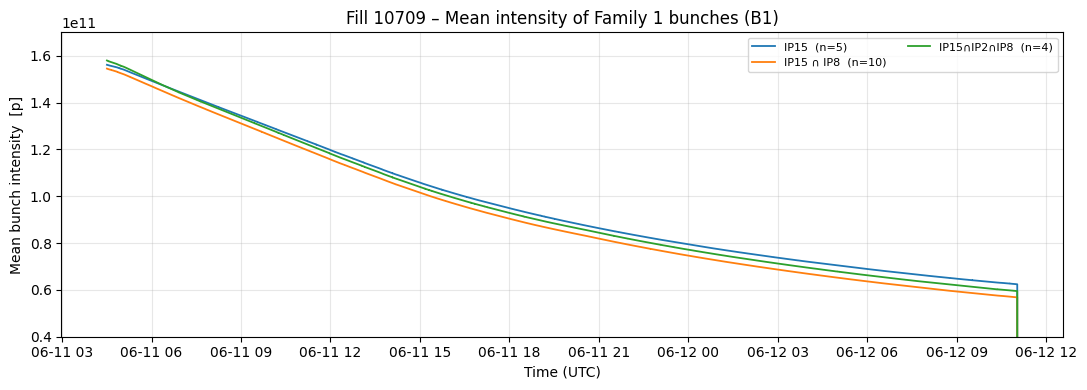

n_bunch  mean_over_time  std_over_time
Group                                               
IP15                5    9.694698e+10   2.764967e+10
IP15 ∩ IP8         10    9.257176e+10   2.853129e+10
IP15∩IP2∩IP8        4    9.512085e+10   2.853668e+10

In [42]:
groups = {
    "IP15"         : np.asarray(Family_1_in_only_15,        int),
    "IP2"          : np.asarray(Family_1_in_only_2,         int),
    "IP8"          : np.asarray(Family_1_in_only_8,         int),
    "IP15 ∩ IP2"   : np.asarray(Family_1_in_only_15_2,      int),
    "IP15 ∩ IP8"   : np.asarray(Family_1_in_only_15_8,      int),
    "IP2  ∩ IP8"   : np.asarray(Family_1_in_only_2_8,       int),
    "IP15∩IP2∩IP8" : np.asarray(Family_1_in_only_15_2_8,    int),
}


groups = {k: v for k, v in groups.items() if v.size}

row_ST  = (fbmodes.loc[fno]
                     .query("BMODE == 'STABLE'")
                     .sort_values("tsStart"))
if row_ST.empty:
    row_ST = fbmodes.loc[fno].sort_values("tsEnd").iloc[[-1]]

t_start = pd.to_datetime(row_ST["tsStart"].iloc[0], utc=True)
t_end   = pd.to_datetime(row_ST["tsEnd"].iloc[0],   utc=True)


ser = (pd.read_parquet(RAWPATH / f"HX:FILLN={fno}",
                       columns=[int_var])[int_var])

ser.index = pd.to_datetime(ser.index, utc=True, errors="coerce")
ser = ser.sort_index()

mask = (ser.index >= t_start) & (ser.index <= t_end)
ser = ser[mask].dropna()

if ser.empty:
    raise RuntimeError("No non-NaN samples in STABLE window")

M = np.stack(ser.values)
time_index = ser.index

palette = plt.cm.get_cmap("tab10").colors
plt.figure(figsize=(11, 4))

stats_rows = []
for i, (label, slots) in enumerate(groups.items()):
    mean_series = np.nanmean(M[:, slots], axis=1)
    plt.plot(time_index, mean_series,
             label=f"{label}  (n={len(slots)})",
             color=palette[i % len(palette)], lw=1.3)

    stats_rows.append({
        "Group" : label,
        "n_bunch" : len(slots),
        "mean_over_time" : np.nanmean(mean_series),
        "std_over_time"  : np.nanstd (mean_series),
    })

plt.xlabel("Time (UTC)")
plt.ylabel("Mean bunch intensity  [p]")
plt.title(f"Fill {fno} – Mean intensity of Family 1 bunches "
          f"({beam})")
plt.grid(True, alpha=.3)
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.ylim(0.4e11, 1.7e11)
plt.show()

stats_df = (pd.DataFrame(stats_rows)
            .set_index("Group")
            .sort_index())
display(stats_df)


### Family 2

/tmp/ipykernel_339335/101708625.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap("tab10").colors


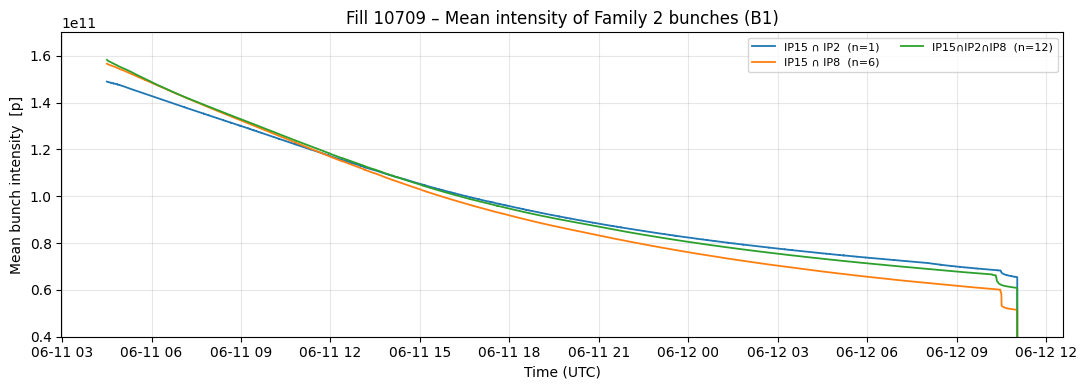

n_bunch  mean_over_time  std_over_time
Group                                               
IP15 ∩ IP2          1    9.758643e+10   2.389593e+10
IP15 ∩ IP8          6    9.402198e+10   2.848884e+10
IP15∩IP2∩IP8       12    9.733627e+10   2.650401e+10

In [43]:
groups = {
    "IP15"         : np.asarray(Family_2_in_only_15,        int),
    "IP2"          : np.asarray(Family_2_in_only_2,         int),
    "IP8"          : np.asarray(Family_2_in_only_8,         int),
    "IP15 ∩ IP2"   : np.asarray(Family_2_in_only_15_2,      int),
    "IP15 ∩ IP8"   : np.asarray(Family_2_in_only_15_8,      int),
    "IP2  ∩ IP8"   : np.asarray(Family_2_in_only_2_8,       int),
    "IP15∩IP2∩IP8" : np.asarray(Family_2_in_only_15_2_8,    int),
}


groups = {k: v for k, v in groups.items() if v.size}

row_ST  = (fbmodes.loc[fno]
                     .query("BMODE == 'STABLE'")
                     .sort_values("tsStart"))
if row_ST.empty:
    row_ST = fbmodes.loc[fno].sort_values("tsEnd").iloc[[-1]]

t_start = pd.to_datetime(row_ST["tsStart"].iloc[0], utc=True)
t_end   = pd.to_datetime(row_ST["tsEnd"].iloc[0],   utc=True)


ser = (pd.read_parquet(RAWPATH / f"HX:FILLN={fno}",
                       columns=[int_var])[int_var])

ser.index = pd.to_datetime(ser.index, utc=True, errors="coerce")
ser = ser.sort_index()

mask = (ser.index >= t_start) & (ser.index <= t_end)
ser = ser[mask].dropna()

if ser.empty:
    raise RuntimeError("No non-NaN samples in STABLE window")

M = np.stack(ser.values)
time_index = ser.index

palette = plt.cm.get_cmap("tab10").colors
plt.figure(figsize=(11, 4))

stats_rows = []
for i, (label, slots) in enumerate(groups.items()):
    mean_series = np.nanmean(M[:, slots], axis=1)
    plt.plot(time_index, mean_series,
             label=f"{label}  (n={len(slots)})",
             color=palette[i % len(palette)], lw=1.3)

    stats_rows.append({
        "Group" : label,
        "n_bunch" : len(slots),
        "mean_over_time" : np.nanmean(mean_series),
        "std_over_time"  : np.nanstd (mean_series),
    })

plt.xlabel("Time (UTC)")
plt.ylabel("Mean bunch intensity  [p]")
plt.title(f"Fill {fno} – Mean intensity of Family 2 bunches "
          f"({beam})")
plt.grid(True, alpha=.3)
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.ylim(0.4e11, 1.7e11)
plt.show()

stats_df = (pd.DataFrame(stats_rows)
            .set_index("Group")
            .sort_index())
display(stats_df)


### Family 3

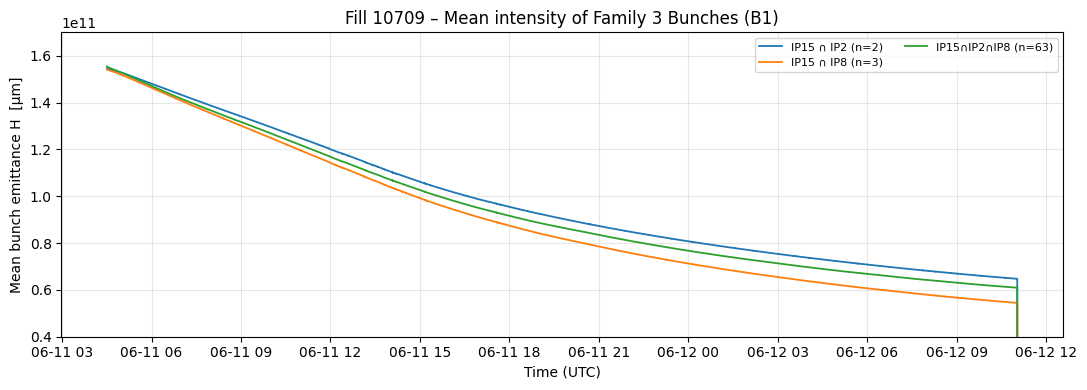

n_bunch  mean_over_time  std_over_time
Group                                               
IP15 ∩ IP2          2    9.774928e+10   2.667307e+10
IP15 ∩ IP8          3    9.017863e+10   2.936756e+10
IP15∩IP2∩IP8       63    9.436899e+10   2.753094e+10

In [44]:

groups = {
    "IP15"         : np.asarray(Family_3_in_only_15,       int),
    "IP2"          : np.asarray(Family_3_in_only_2,        int),
    "IP8"          : np.asarray(Family_3_in_only_8,        int),
    "IP15 ∩ IP2"   : np.asarray(Family_3_in_only_15_2,     int),
    "IP15 ∩ IP8"   : np.asarray(Family_3_in_only_15_8,     int),
    "IP2  ∩ IP8"   : np.asarray(Family_3_in_only_2_8,      int),
    "IP15∩IP2∩IP8" : np.asarray(Family_3_in_only_15_2_8,   int),
}
groups = {k: v for k, v in groups.items() if v.size}   


plt.figure(figsize=(11, 4))
stats_rows = []

for i, (label, slots) in enumerate(groups.items()):
    mean_series = np.nanmean(M[:, slots], axis=1)
    plt.plot(time_index, mean_series,
             label=f"{label} (n={len(slots)})",
             color=palette[i % len(palette)], lw=1.3)

    stats_rows.append({
        "Group"        : label,
        "n_bunch"      : len(slots),
        "mean_over_time": np.nanmean(mean_series),
        "std_over_time" : np.nanstd (mean_series),
    })

plt.xlabel("Time (UTC)")
plt.ylabel("Mean bunch emittance H  [µm]")
plt.title(f"Fill {fno} – Mean intensity of Family 3 Bunches ({beam})")
plt.grid(True, alpha=.3)
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.ylim(0.4e11, 1.7e11)
plt.show()
stats_df = (pd.DataFrame(stats_rows)
            .set_index("Group")
            .sort_index())
display(stats_df)


### Family 4

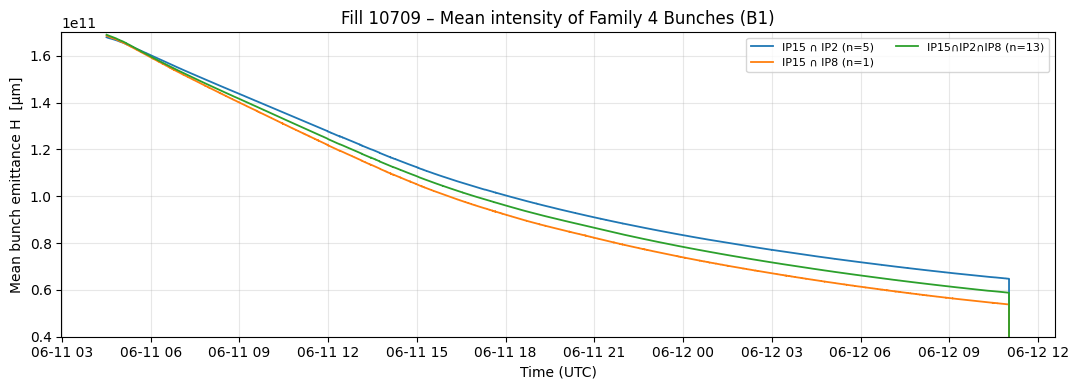

n_bunch  mean_over_time  std_over_time
Group                                               
IP15 ∩ IP2          5    1.026284e+11   3.036721e+10
IP15 ∩ IP8          1    9.501952e+10   3.337313e+10
IP15∩IP2∩IP8       13    9.856071e+10   3.197123e+10

In [45]:

groups = {
    "IP15"         : np.asarray(Family_4_in_only_15,       int),
    "IP2"          : np.asarray(Family_4_in_only_2,        int),
    "IP8"          : np.asarray(Family_4_in_only_8,        int),
    "IP15 ∩ IP2"   : np.asarray(Family_4_in_only_15_2,     int),
    "IP15 ∩ IP8"   : np.asarray(Family_4_in_only_15_8,     int),
    "IP2  ∩ IP8"   : np.asarray(Family_4_in_only_2_8,      int),
    "IP15∩IP2∩IP8" : np.asarray(Family_4_in_only_15_2_8,   int),
}
groups = {k: v for k, v in groups.items() if v.size}   


plt.figure(figsize=(11, 4))
stats_rows = []

for i, (label, slots) in enumerate(groups.items()):
    mean_series = np.nanmean(M[:, slots], axis=1)
    plt.plot(time_index, mean_series,
             label=f"{label} (n={len(slots)})",
             color=palette[i % len(palette)], lw=1.3)

    stats_rows.append({
        "Group"        : label,
        "n_bunch"      : len(slots),
        "mean_over_time": np.nanmean(mean_series),
        "std_over_time" : np.nanstd (mean_series),
    })

plt.xlabel("Time (UTC)")
plt.ylabel("Mean bunch emittance H  [µm]")
plt.title(f"Fill {fno} – Mean intensity of Family 4 Bunches ({beam})")
plt.grid(True, alpha=.3)
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.ylim(0.4e11, 1.7e11)
plt.show()
stats_df = (pd.DataFrame(stats_rows)
            .set_index("Group")
            .sort_index())
display(stats_df)


### Family 5

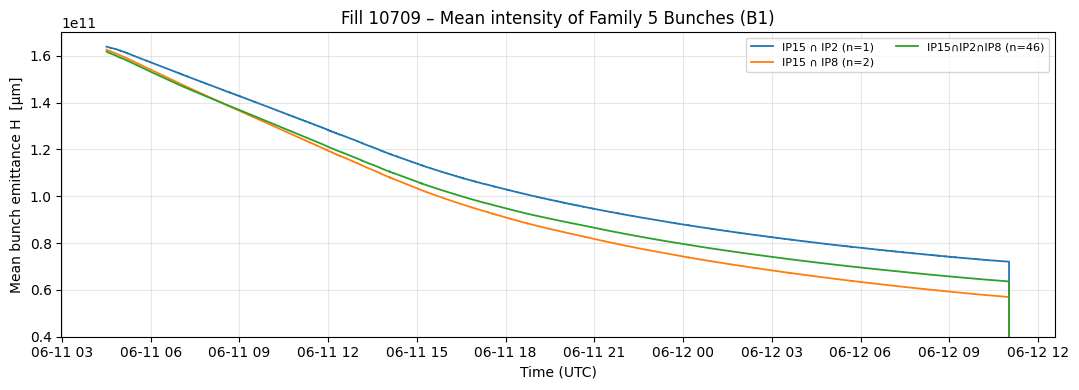

n_bunch  mean_over_time  std_over_time
Group                                               
IP15 ∩ IP2          1    1.054626e+11   2.733292e+10
IP15 ∩ IP8          2    9.429227e+10   3.100715e+10
IP15∩IP2∩IP8       46    9.799226e+10   2.858993e+10

In [46]:


groups = {
    "IP15"         : np.asarray(Family_5_in_only_15,       int),
    "IP2"          : np.asarray(Family_5_in_only_2,        int),
    "IP8"          : np.asarray(Family_5_in_only_8,        int),
    "IP15 ∩ IP2"   : np.asarray(Family_5_in_only_15_2,     int),
    "IP15 ∩ IP8"   : np.asarray(Family_5_in_only_15_8,     int),
    "IP2  ∩ IP8"   : np.asarray(Family_5_in_only_2_8,      int),
    "IP15∩IP2∩IP8" : np.asarray(Family_5_in_only_15_2_8,   int),
}
groups = {k: v for k, v in groups.items() if v.size}   


plt.figure(figsize=(11, 4))
stats_rows = []

for i, (label, slots) in enumerate(groups.items()):
    mean_series = np.nanmean(M[:, slots], axis=1)
    plt.plot(time_index, mean_series,
             label=f"{label} (n={len(slots)})",
             color=palette[i % len(palette)], lw=1.3)

    stats_rows.append({
        "Group"        : label,
        "n_bunch"      : len(slots),
        "mean_over_time": np.nanmean(mean_series),
        "std_over_time" : np.nanstd (mean_series),
    })

plt.xlabel("Time (UTC)")
plt.ylabel("Mean bunch emittance H  [µm]")
plt.title(f"Fill {fno} – Mean intensity of Family 5 Bunches ({beam})")
plt.grid(True, alpha=.3)
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.ylim(0.4e11, 1.7e11)
plt.show()
stats_df = (pd.DataFrame(stats_rows)
            .set_index("Group")
            .sort_index())
display(stats_df)


### Family 6

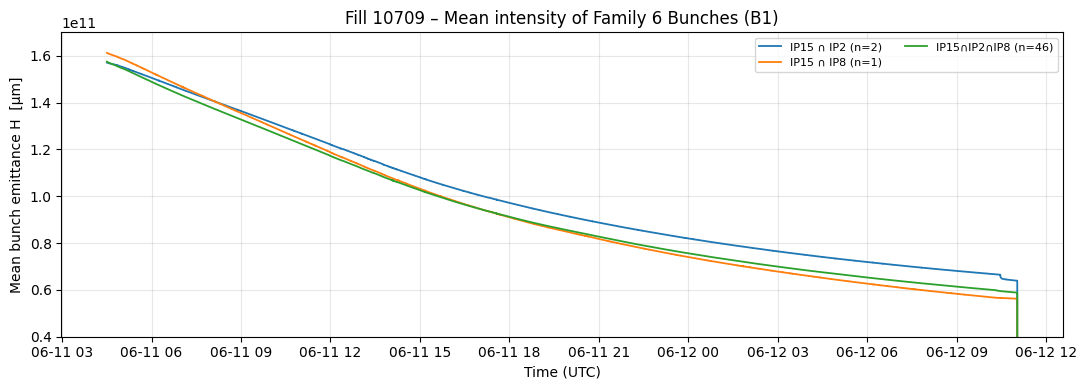

n_bunch  mean_over_time  std_over_time
Group                                               
IP15 ∩ IP2          2    9.933499e+10   2.719554e+10
IP15 ∩ IP8          1    9.373880e+10   3.084938e+10
IP15∩IP2∩IP8       46    9.396709e+10   2.863685e+10

In [47]:

groups = {
    "IP15"         : np.asarray(Family_6_in_only_15,       int),
    "IP2"          : np.asarray(Family_6_in_only_2,        int),
    "IP8"          : np.asarray(Family_6_in_only_8,        int),
    "IP15 ∩ IP2"   : np.asarray(Family_6_in_only_15_2,     int),
    "IP15 ∩ IP8"   : np.asarray(Family_6_in_only_15_8,     int),
    "IP2  ∩ IP8"   : np.asarray(Family_6_in_only_2_8,      int),
    "IP15∩IP2∩IP8" : np.asarray(Family_6_in_only_15_2_8,   int),
}
groups = {k: v for k, v in groups.items() if v.size}   


plt.figure(figsize=(11, 4))
stats_rows = []

for i, (label, slots) in enumerate(groups.items()):
    mean_series = np.nanmean(M[:, slots], axis=1)
    plt.plot(time_index, mean_series,
             label=f"{label} (n={len(slots)})",
             color=palette[i % len(palette)], lw=1.3)

    stats_rows.append({
        "Group"        : label,
        "n_bunch"      : len(slots),
        "mean_over_time": np.nanmean(mean_series),
        "std_over_time" : np.nanstd (mean_series),
    })

plt.xlabel("Time (UTC)")
plt.ylabel("Mean bunch emittance H  [µm]")
plt.title(f"Fill {fno} – Mean intensity of Family 6 Bunches ({beam})")
plt.grid(True, alpha=.3)
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.ylim(0.4e11, 1.7e11)
plt.show()
stats_df = (pd.DataFrame(stats_rows)
            .set_index("Group")
            .sort_index())
display(stats_df)


### 7) first in small gap

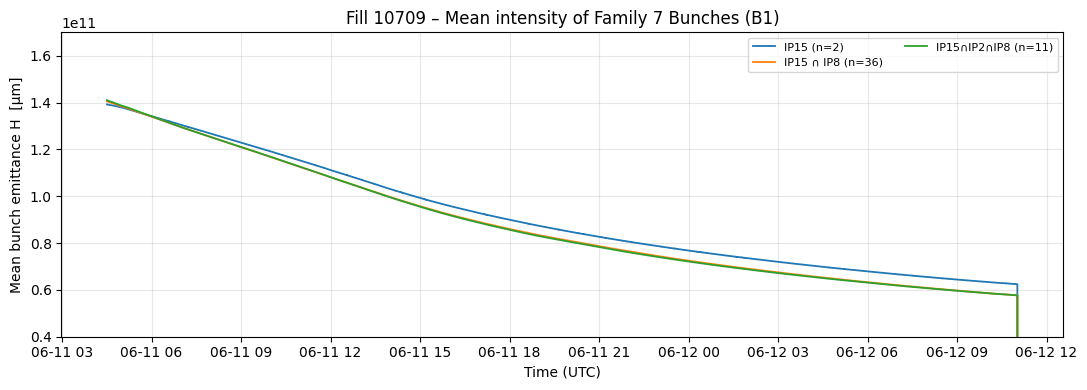

n_bunch  mean_over_time  std_over_time
Group                                               
IP15                2    9.147290e+10   2.306623e+10
IP15 ∩ IP8         36    8.796063e+10   2.435168e+10
IP15∩IP2∩IP8       11    8.779247e+10   2.447037e+10

In [48]:
groups = {
    "IP15"         : np.asarray(Family_7_in_only_15,       int),
    "IP2"          : np.asarray(Family_7_in_only_2,        int),
    "IP8"          : np.asarray(Family_7_in_only_8,        int),
    "IP15 ∩ IP2"   : np.asarray(Family_7_in_only_15_2,     int),
    "IP15 ∩ IP8"   : np.asarray(Family_7_in_only_15_8,     int),
    "IP2  ∩ IP8"   : np.asarray(Family_7_in_only_2_8,      int),
    "IP15∩IP2∩IP8" : np.asarray(Family_7_in_only_15_2_8,   int),
}
groups = {k: v for k, v in groups.items() if v.size}   


plt.figure(figsize=(11, 4))
stats_rows = []

for i, (label, slots) in enumerate(groups.items()):
    mean_series = np.nanmean(M[:, slots], axis=1)
    plt.plot(time_index, mean_series,
             label=f"{label} (n={len(slots)})",
             color=palette[i % len(palette)], lw=1.3)

    stats_rows.append({
        "Group"        : label,
        "n_bunch"      : len(slots),
        "mean_over_time": np.nanmean(mean_series),
        "std_over_time" : np.nanstd (mean_series),
    })

plt.xlabel("Time (UTC)")
plt.ylabel("Mean bunch emittance H  [µm]")
plt.title(f"Fill {fno} – Mean intensity of Family 7 Bunches ({beam})")
plt.grid(True, alpha=.3)
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.ylim(0.4e11, 1.7e11)
plt.show()
stats_df = (pd.DataFrame(stats_rows)
            .set_index("Group")
            .sort_index())
display(stats_df)


### Family 8

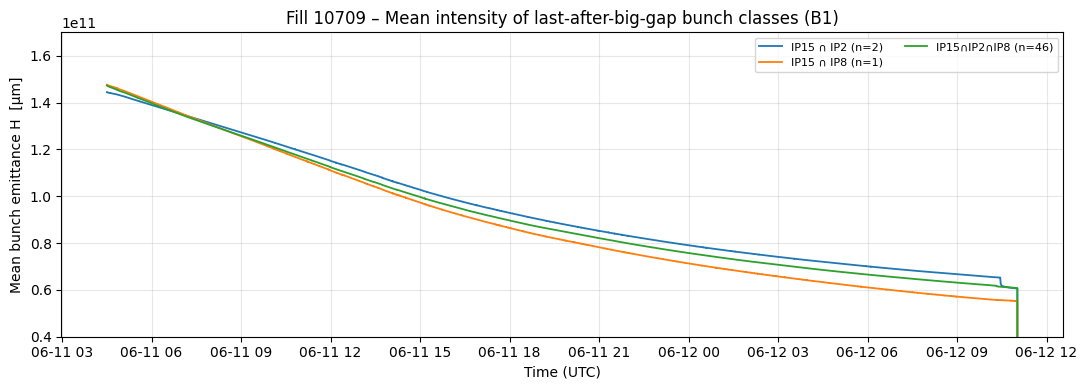

n_bunch  mean_over_time  std_over_time
Group                                               
IP15 ∩ IP2          2    9.446241e+10   2.409846e+10
IP15 ∩ IP8          1    8.867208e+10   2.724517e+10
IP15∩IP2∩IP8       46    9.185015e+10   2.513693e+10

In [49]:
groups = {
    "IP15"         : np.asarray(Family_8_in_only_15,       int),
    "IP2"          : np.asarray(Family_8_in_only_2,        int),
    "IP8"          : np.asarray(Family_8_in_only_8,        int),
    "IP15 ∩ IP2"   : np.asarray(Family_8_in_only_15_2,     int),
    "IP15 ∩ IP8"   : np.asarray(Family_8_in_only_15_8,     int),
    "IP2  ∩ IP8"   : np.asarray(Family_8_in_only_2_8,      int),
    "IP15∩IP2∩IP8" : np.asarray(Family_8_in_only_15_2_8,   int),
}
groups = {k: v for k, v in groups.items() if v.size}   


plt.figure(figsize=(11, 4))
stats_rows = []

for i, (label, slots) in enumerate(groups.items()):
    mean_series = np.nanmean(M[:, slots], axis=1)
    plt.plot(time_index, mean_series,
             label=f"{label} (n={len(slots)})",
             color=palette[i % len(palette)], lw=1.3)

    stats_rows.append({
        "Group"        : label,
        "n_bunch"      : len(slots),
        "mean_over_time": np.nanmean(mean_series),
        "std_over_time" : np.nanstd (mean_series),
    })

plt.xlabel("Time (UTC)")
plt.ylabel("Mean bunch emittance H  [µm]")
plt.title(f"Fill {fno} – Mean intensity of last-after-big-gap bunch classes ({beam})")
plt.grid(True, alpha=.3)
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.ylim(0.4e11, 1.7e11)
plt.show()
stats_df = (pd.DataFrame(stats_rows)
            .set_index("Group")
            .sort_index())
display(stats_df)


### Mean Intensities classified by bunch position

/tmp/ipykernel_339335/1095899708.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap("tab10").colors  # 10 reusable colours


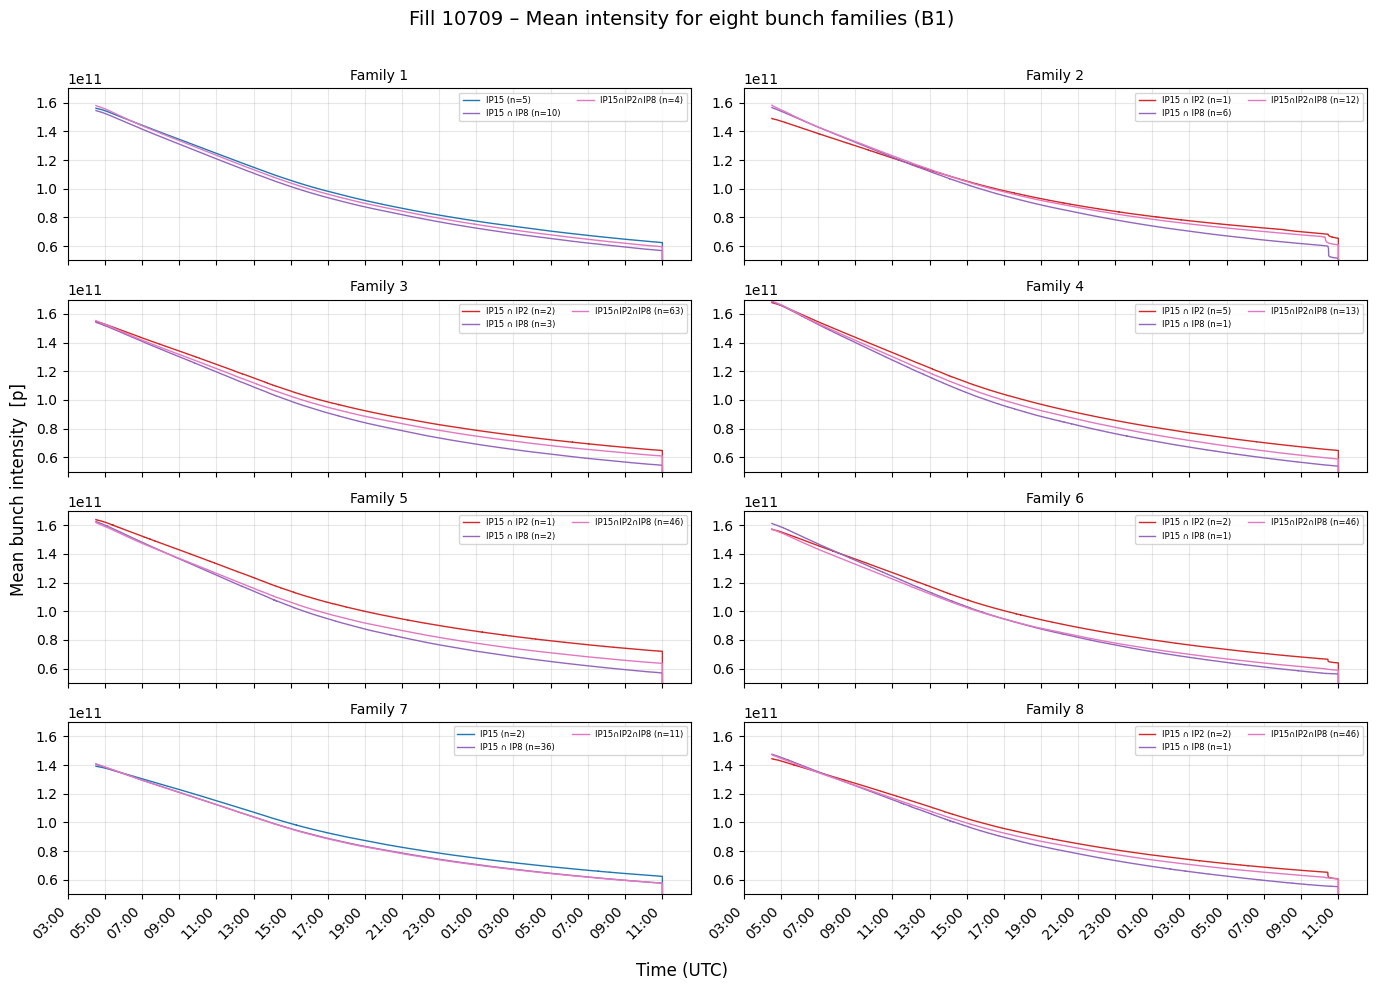

In [50]:
# ------------- 0. helper ----------------------------------------------------
def to_arr(x):                         # make sure: 1-D int array
    return np.asarray(x, dtype=int)

def mean_curve(slot_arr):
    """Return nan-mean vs time for the given slot list."""
    if slot_arr.size == 0:
        return None
    return np.nanmean(M[:, slot_arr], axis=1)

palette = plt.cm.get_cmap("tab10").colors  # 10 reusable colours

# ------------- 1. all eight families ---------------------------------------
families = {
    "Family 1" : {
    "IP15"         : np.asarray(Family_1_in_only_15,       int),
    "IP2"          : np.asarray(Family_1_in_only_2,        int),
    "IP8"          : np.asarray(Family_1_in_only_8,        int),
    "IP15 ∩ IP2"   : np.asarray(Family_1_in_only_15_2,     int),
    "IP15 ∩ IP8"   : np.asarray(Family_1_in_only_15_8,     int),
    "IP2  ∩ IP8"   : np.asarray(Family_1_in_only_2_8,      int),
    "IP15∩IP2∩IP8" : np.asarray(Family_1_in_only_15_2_8,   int),
    },
    "Family 2" : {
    "IP15"         : np.asarray(Family_2_in_only_15,       int),
    "IP2"          : np.asarray(Family_2_in_only_2,        int),
    "IP8"          : np.asarray(Family_2_in_only_8,        int),
    "IP15 ∩ IP2"   : np.asarray(Family_2_in_only_15_2,     int),
    "IP15 ∩ IP8"   : np.asarray(Family_2_in_only_15_8,     int),
    "IP2  ∩ IP8"   : np.asarray(Family_2_in_only_2_8,      int),
    "IP15∩IP2∩IP8" : np.asarray(Family_2_in_only_15_2_8,   int),
    },
    "Family 3" : {
    "IP15"         : np.asarray(Family_3_in_only_15,       int),
    "IP2"          : np.asarray(Family_3_in_only_2,        int),
    "IP8"          : np.asarray(Family_3_in_only_8,        int),
    "IP15 ∩ IP2"   : np.asarray(Family_3_in_only_15_2,     int),
    "IP15 ∩ IP8"   : np.asarray(Family_3_in_only_15_8,     int),
    "IP2  ∩ IP8"   : np.asarray(Family_3_in_only_2_8,      int),
    "IP15∩IP2∩IP8" : np.asarray(Family_3_in_only_15_2_8,   int),
    },
    "Family 4" : {
    "IP15"         : np.asarray(Family_4_in_only_15,       int),
    "IP2"          : np.asarray(Family_4_in_only_2,        int),
    "IP8"          : np.asarray(Family_4_in_only_8,        int),
    "IP15 ∩ IP2"   : np.asarray(Family_4_in_only_15_2,     int),
    "IP15 ∩ IP8"   : np.asarray(Family_4_in_only_15_8,     int),
    "IP2  ∩ IP8"   : np.asarray(Family_4_in_only_2_8,      int),
    "IP15∩IP2∩IP8" : np.asarray(Family_4_in_only_15_2_8,   int),
    },
    "Family 5" : {
    "IP15"         : np.asarray(Family_5_in_only_15,       int),
    "IP2"          : np.asarray(Family_5_in_only_2,        int),
    "IP8"          : np.asarray(Family_5_in_only_8,        int),
    "IP15 ∩ IP2"   : np.asarray(Family_5_in_only_15_2,     int),
    "IP15 ∩ IP8"   : np.asarray(Family_5_in_only_15_8,     int),
    "IP2  ∩ IP8"   : np.asarray(Family_5_in_only_2_8,      int),
    "IP15∩IP2∩IP8" : np.asarray(Family_5_in_only_15_2_8,   int),
    },
    "Family 6" : {
    "IP15"         : np.asarray(Family_6_in_only_15,       int),
    "IP2"          : np.asarray(Family_6_in_only_2,        int),
    "IP8"          : np.asarray(Family_6_in_only_8,        int),
    "IP15 ∩ IP2"   : np.asarray(Family_6_in_only_15_2,     int),
    "IP15 ∩ IP8"   : np.asarray(Family_6_in_only_15_8,     int),
    "IP2  ∩ IP8"   : np.asarray(Family_6_in_only_2_8,      int),
    "IP15∩IP2∩IP8" : np.asarray(Family_6_in_only_15_2_8,   int),
    },
    "Family 7" : {
    "IP15"         : np.asarray(Family_7_in_only_15,       int),
    "IP2"          : np.asarray(Family_7_in_only_2,        int),
    "IP8"          : np.asarray(Family_7_in_only_8,        int),
    "IP15 ∩ IP2"   : np.asarray(Family_7_in_only_15_2,     int),
    "IP15 ∩ IP8"   : np.asarray(Family_7_in_only_15_8,     int),
    "IP2  ∩ IP8"   : np.asarray(Family_7_in_only_2_8,      int),
    "IP15∩IP2∩IP8" : np.asarray(Family_7_in_only_15_2_8,   int),
    },
    "Family 8" : {
    "IP15"         : np.asarray(Family_8_in_only_15,       int),
    "IP2"          : np.asarray(Family_8_in_only_2,        int),
    "IP8"          : np.asarray(Family_8_in_only_8,        int),
    "IP15 ∩ IP2"   : np.asarray(Family_8_in_only_15_2,     int),
    "IP15 ∩ IP8"   : np.asarray(Family_8_in_only_15_8,     int),
    "IP2  ∩ IP8"   : np.asarray(Family_8_in_only_2_8,      int),
    "IP15∩IP2∩IP8" : np.asarray(Family_8_in_only_15_2_8,   int),
    },
}
import matplotlib.dates as mdates 
import matplotlib.ticker as mticker# ← make sure this is up top

fig, axes = plt.subplots(4, 2, figsize=(14, 10), sharex=True)
axes = axes.flatten()
big_stats = []

for ax, (fam_name, fam_groups) in zip(axes, families.items()):
    for i, (clabel, slots) in enumerate(fam_groups.items()):
        curve = mean_curve(slots)
        if curve is None:
            continue
        ax.plot(time_index, curve,
                label=f"{clabel} (n={len(slots)})",
                color=palette[i % len(palette)], lw=1)
        big_stats.append({
            "Family":  fam_name,
            "Group":   clabel,
            "n":       len(slots),
            "mean":    np.nanmean(curve),
            "std":     np.nanstd(curve),
        })

    ax.set_title(fam_name, fontsize=10)
    ax.set_ylim(0.5e11, 1.7e11)
    ax.grid(alpha=.3)
    ax.legend(fontsize=6, ncol=2)

# ─── Format the shared x-axis ─────────────────────────────────────────────
# 1) Only show HH:MM
for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))

# 2) Rotate the bottom‐row tick labels for readability
for ax in axes[-2:]:
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

fig.suptitle(f"Fill {fno} – Mean intensity for eight bunch families ({beam})",
             fontsize=14)
fig.supxlabel("Time (UTC)")
fig.supylabel("Mean bunch intensity  [p]")
fig.tight_layout(rect=[0,0,1,0.97])
plt.show()

### RAMP ADJUST STABLE

In [51]:
print("TYPE  :", type(fbmodes))

try:
    print("LENGTH:", len(fbmodes))
except TypeError:
    print("Object has no len()")

# show the first few items or rows
if hasattr(fbmodes, "head"):          # pandas objects
    display(fbmodes.head())
elif isinstance(fbmodes, (list, tuple, np.ndarray)):
    print("FIRST 5 ELEMENTS:", fbmodes[:5])
else:
    print("SAMPLE VALUE:", fbmodes)
print("\nUNIQUE VALUES:")
for col in fbmodes.columns:
    # only show uniques for columns with few distinct entries
    nuniques = fbmodes[col].nunique(dropna=False)
    if nuniques <= 20:
        print(f"  {col!r} ({nuniques} unique):", fbmodes[col].unique())
    else:
        print(f"  {col!r} ({nuniques} unique): too many to list")

TYPE  : <class 'pandas.core.frame.DataFrame'>
LENGTH: 3192


BMODE              tsStart                tsEnd    QFLAG  \
FILLNO                                                               
10407      FILL  1743594329236488525  1743599859181613525     DUCK   
10408      FILL  1743599859181613525  1743602936079238525     DUCK   
10409      FILL  1743602936079238525  1743610874498488525     DUCK   
10410      FILL  1743610874498488525  1743789954433488525  HASBEAM   
10410   SQUEEZE  1743704033370738525  1743704061735988525  HASBEAM   

               duration  duration [m]  duration [h]  HX:AMODE  
FILLNO                                                         
10407     5529945125000     92.165752      1.536096       3.0  
10408     3076897625000     51.281627      0.854694       3.0  
10409     7938419250000    132.306987      2.205116       3.0  
10410   179079935000000   2984.665583     49.744426       3.0  
10410       28365250000      0.472754      0.007879       3.0


UNIQUE VALUES:
  'BMODE' (15 unique): ['FILL' 'SQUEEZE' 'NOBEAM' 'SETUP' 'INJPROB' 'BEAMDUMP' 'RAMPDOWN'
 'CYCLING' 'PRERAMP' 'RAMP' 'FLATTOP' 'INJPHYS' 'INJSTUP' 'ADJUST'
 'STABLE']
  'tsStart' (2791 unique): too many to list
  'tsEnd' (2790 unique): too many to list
  'QFLAG' (5 unique): ['DUCK' 'HASBEAM' 'FLATTOP' 'STABLE' 'INRAMP']
  'duration' (3140 unique): too many to list
  'duration [m]' (3140 unique): too many to list
  'duration [h]' (3140 unique): too many to list
  'HX:AMODE' (6 unique): [ 3.  8.  9. 12. 16. 10.]


In [52]:
def load_phase_series(fno, phase, 
                      int_var=int_var,   # your intensity variable name
                      rawpath=RAWPATH):
    """Return a pandas.Series of int_var during the given phase."""
    # select rows for this fill & this phase
    sub = fbmodes.loc[fno]
    rows = sub.query(f"BMODE == '{phase}'").sort_values("tsStart")
    
    # fallback logic
    if rows.empty:
        if phase == "STABLE":
            # pick the last segment if none explicitly labeled STABLE
            rows = sub.sort_values("tsEnd").iloc[[-1]]
        else:
            # pick the first segment if no RAMP/ADJUST found
            rows = sub.sort_values("tsStart").iloc[[0]]
    
    # extract start/end times
    t0 = pd.to_datetime(rows["tsStart"].iloc[0], utc=True)
    t1 = pd.to_datetime(rows["tsEnd"  ].iloc[0], utc=True)
    
    # read the parquet and coerce index to UTC‐datetimes
    ser = pd.read_parquet(rawpath / f"HX:FILLN={fno}", columns=[int_var])[int_var]
    ser.index = pd.to_datetime(ser.index, utc=True, errors="coerce")
    ser = ser.sort_index()
    
    # slice to [t0, t1]
    mask = (ser.index >= t0) & (ser.index <= t1)
    phase_ser = ser.loc[mask].dropna()
    
    if phase_ser.empty:
        raise RuntimeError(f"No non-NaN samples in {phase} window for fill {fno}")
    return phase_ser

# ───────────────────────────────────────────
# now load all three
# ───────────────────────────────────────────
ser_ramp   = load_phase_series(fno, "RAMP")
ser_adjust = load_phase_series(fno, "ADJUST")
ser_stable = load_phase_series(fno, "STABLE")
ser_flattop = load_phase_series(fno, "FLATTOP")
ser_preramp = load_phase_series(fno, "PRERAMP")
ser_rampdown = load_phase_series(fno, "RAMPDOWN")
ser_injphys = load_phase_series(fno, "INJPHYS")
ser_cycling = load_phase_series(fno, "CYCLING")
ser_fill = load_phase_series(fno, "FILL")
ser_squeeze = load_phase_series(fno, "SQUEEZE")
# quick check:
print("RAMP  :", ser_ramp.index[0], "→", ser_ramp.index[-1], ";  n=", len(ser_ramp))
print("ADJUST:", ser_adjust.index[0], "→", ser_adjust.index[-1], ";  n=", len(ser_adjust))
print("STABLE:", ser_stable.index[0], "→", ser_stable.index[-1], ";  n=", len(ser_stable))
print("FLATTOP:", ser_flattop.index[0], "→", ser_flattop.index[-1], ";  n=", len(ser_flattop))
print("PRERAMP:", ser_preramp.index[0], "→", ser_preramp.index[-1], ";  n=", len(ser_preramp))
print("RAMPDOWN:", ser_rampdown.index[0], "→", ser_rampdown.index[-1], ";  n=", len(ser_rampdown))
print("INJPHYS:", ser_injphys.index[0], "→", ser_injphys.index[-1], ";  n=", len(ser_injphys))
print("CYCLING:", ser_cycling.index[0], "→", ser_cycling.index[-1], ";  n=", len(ser_cycling))
print("FILL:", ser_fill.index[0], "→", ser_fill.index[-1], ";  n=", len(ser_fill))
print("SQUEEZE:", ser_squeeze.index[0], "→", ser_squeeze.index[-1], ";  n=", len(ser_squeeze))

RAMP  : 2025-06-11 03:41:54.000363525+00:00 → 2025-06-11 04:03:17.000363525+00:00 ;  n= 335
ADJUST: 2025-06-11 04:22:10.000363525+00:00 → 2025-06-11 04:30:10.000363525+00:00 ;  n= 128
STABLE: 2025-06-11 04:30:21.000363525+00:00 → 2025-06-12 11:02:09.000363525+00:00 ;  n= 27577
FLATTOP: 2025-06-11 04:03:21.000363525+00:00 → 2025-06-11 04:03:33.000363525+00:00 ;  n= 4
PRERAMP: 2025-06-11 03:40:20.000363525+00:00 → 2025-06-11 03:41:52.000363525+00:00 ;  n= 27
RAMPDOWN: 2025-06-11 01:36:10.000363525+00:00 → 2025-06-11 01:56:36.000363525+00:00 ;  n= 302
INJPHYS: 2025-06-11 03:05:50.000363525+00:00 → 2025-06-11 03:40:18.000363525+00:00 ;  n= 494
CYCLING: 2025-06-11 01:36:10.000363525+00:00 → 2025-06-12 11:15:00.000363525+00:00 ;  n= 30356
FILL: 2025-06-11 01:36:10.000363525+00:00 → 2025-06-12 11:15:00.000363525+00:00 ;  n= 30356
SQUEEZE: 2025-06-11 04:03:46.000363525+00:00 → 2025-06-11 04:22:00.000363525+00:00 ;  n= 273


In [53]:
int_var = f"LHC.BCTFR.B6R4.{beam}:BUNCH_INTENSITY"

def load_phase_data(fno, phase, rawpath=RAWPATH, int_var=int_var):
    """
    Load the bunch‐intensity time‐series for the given phase.
    Returns (M_phase, time_index_phase) where
    - M_phase is shape (n_samples, n_bunches)
    - time_index_phase is a DatetimeIndex of length n_samples
    """
    # 1) pick out the tsStart/tsEnd row for this phase (fallback if missing)
    sub = fbmodes.loc[fno]
    rows = sub.query(f"BMODE == '{phase}'").sort_values("tsStart")
    if rows.empty:
        if phase == "STABLE":
            rows = sub.sort_values("tsEnd").iloc[[-1]]
        else:
            rows = sub.sort_values("tsStart").iloc[[0]]

    t0 = pd.to_datetime(rows["tsStart"].iloc[0], utc=True)
    t1 = pd.to_datetime(rows["tsEnd"  ].iloc[0], utc=True)

    # 2) read the parquet, coerce to datetime index and slice
    ser = pd.read_parquet(rawpath / f"HX:FILLN={fno}", columns=[int_var])[int_var]
    ser.index = pd.to_datetime(ser.index, utc=True, errors="coerce")
    ser = ser.sort_index()

    mask = (ser.index >= t0) & (ser.index <= t1)
    ser = ser.loc[mask].dropna()
    if ser.empty:
        raise RuntimeError(f"No non-NaN samples in {phase} window for fill {fno}")

    # 3) stack the per-timestamp arrays into an (ntime × nbunch) matrix
    M_phase         = np.stack(ser.values)  
    time_index_phase = ser.index

    print(f"{phase:6s}: {len(time_index_phase)} samples, {M_phase.shape[1]} bunches  "
          f"({time_index_phase[0]} → {time_index_phase[-1]})")
    return M_phase, time_index_phase

# ────────────────────────────────────────────
# now load all three
# ────────────────────────────────────────────
M_ramp,   ti_ramp   = load_phase_data(fno, "RAMP")
M_adjust, ti_adjust = load_phase_data(fno, "ADJUST")
M_stable, ti_stable = load_phase_data(fno, "STABLE")
M_flattop, ti_flattop = load_phase_data(fno,"FLATTOP")

RAMP  : 335 samples, 3564 bunches  (2025-06-11 03:41:54.000363525+00:00 → 2025-06-11 04:03:17.000363525+00:00)
ADJUST: 128 samples, 3564 bunches  (2025-06-11 04:22:10.000363525+00:00 → 2025-06-11 04:30:10.000363525+00:00)
STABLE: 27577 samples, 3564 bunches  (2025-06-11 04:30:21.000363525+00:00 → 2025-06-12 11:02:09.000363525+00:00)
FLATTOP: 4 samples, 3564 bunches  (2025-06-11 04:03:21.000363525+00:00 → 2025-06-11 04:03:33.000363525+00:00)


/tmp/ipykernel_339335/611339825.py:123: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  family_colors = plt.cm.get_cmap("tab10").colors
/tmp/ipykernel_339335/611339825.py:78: RuntimeWarning: Mean of empty slice
  return None if slots.size==0 else np.nanmean(M_ph[:, slots], axis=1)
/tmp/ipykernel_339335/611339825.py:139: RuntimeWarning: Mean of empty slice
  fam_mean = np.nanmean(inj2[slots])


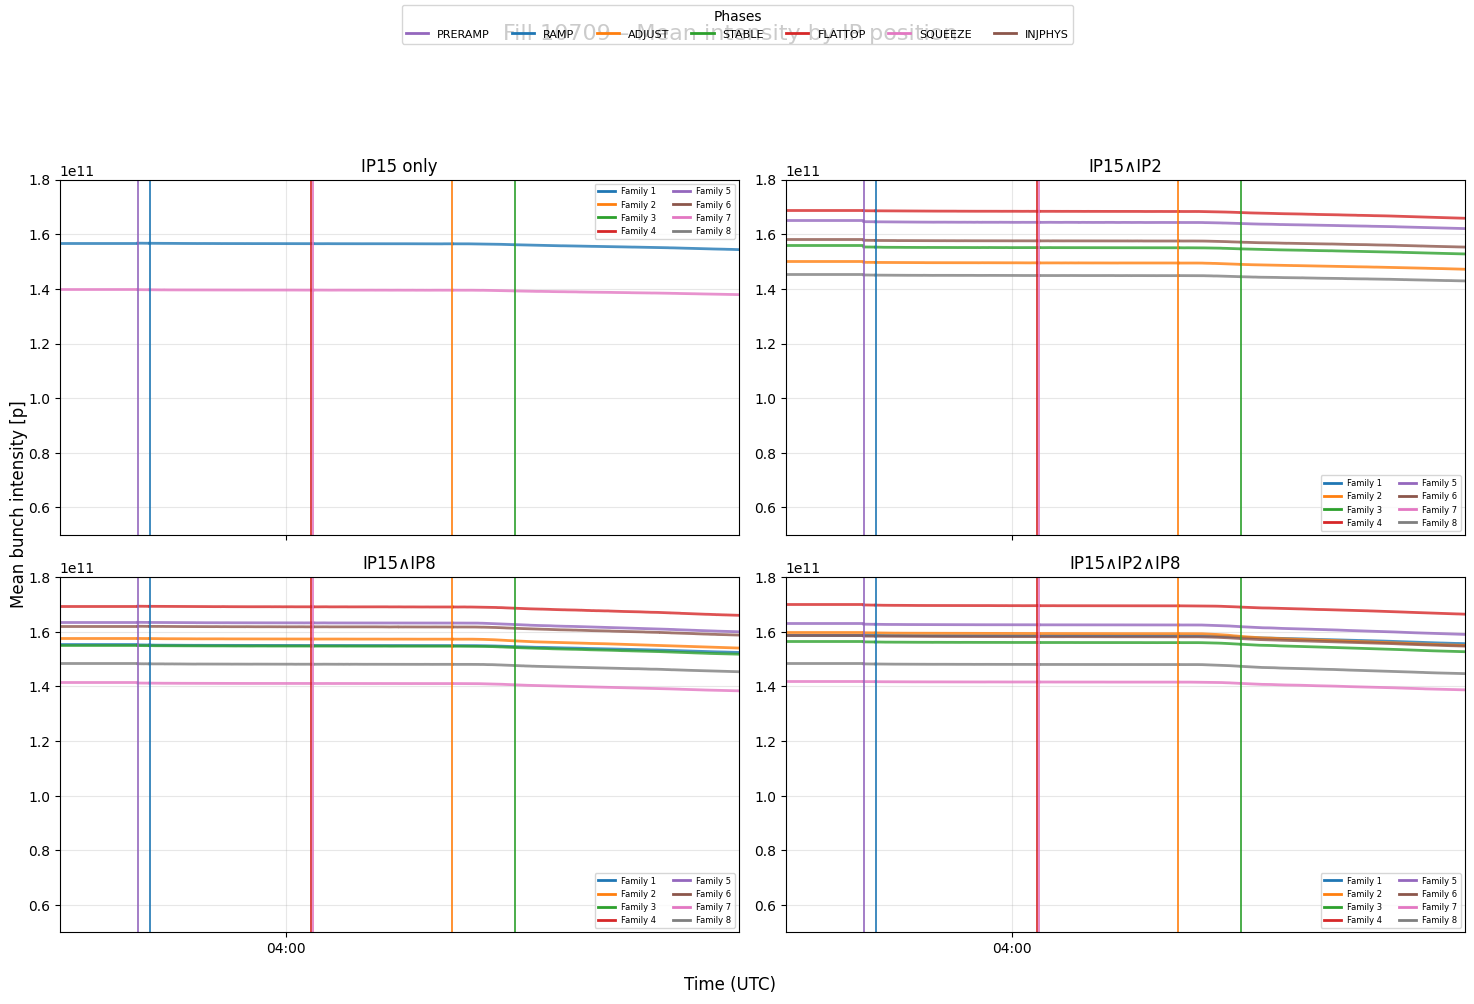

In [58]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D

# ───────────────────────────────────────────────────────────────
# 0) Read the full‐fill intensity series
# ───────────────────────────────────────────────────────────────
int_var = f"LHC.BCTFR.B6R4.{beam}:BUNCH_INTENSITY"
ser_full = (
    pd.read_parquet(RAWPATH / f"HX:FILLN={fno}", columns=[int_var])[int_var]
      .dropna().sort_index()
)
ser_full.index = pd.to_datetime(ser_full.index, utc=True, errors="coerce")

# ───────────────────────────────────────────────────────────────
# 1) Helper to load a single BMODE window (stack → mask zeros→NaN)
# ───────────────────────────────────────────────────────────────
def load_phase_data(phase):
    df   = fbmodes.loc[fno]
    rows = df.query("BMODE == @phase").sort_values("tsStart")
    if rows.empty:
        rows = (
            df.sort_values("tsEnd").iloc[[-1]] if phase=="STABLE"
            else df.sort_values("tsStart").iloc[[0]]
        )
    t0 = pd.to_datetime(rows.tsStart.iloc[0], utc=True)
    t1 = pd.to_datetime(rows.tsEnd  .iloc[0], utc=True)

    ser = (
        pd.read_parquet(RAWPATH / f"HX:FILLN={fno}", columns=[int_var])[int_var]
          .dropna().sort_index()
    )
    ser.index = pd.to_datetime(ser.index, utc=True, errors="coerce")
    ser = ser.loc[t0:t1]
    if ser.empty:
        raise RuntimeError(f"No non-NaN samples in {phase}")

    M_ph = np.stack(ser.values).astype(float)
    M_ph[M_ph == 0]      = np.nan
    M_ph[M_ph < 0.5e10]  = np.nan
    return M_ph, ser.index, t0, t1

# ───────────────────────────────────────────────────────────────
# 2) Build all seven phase windows
# ───────────────────────────────────────────────────────────────
phase_names = ["PRERAMP","RAMP","ADJUST","STABLE","FLATTOP","SQUEEZE","INJPHYS"]
phase_data  = {}
for ph in phase_names:
    M, ti, t0, t1 = load_phase_data(ph)
    phase_data[ph] = (M, ti, t0, t1)

phase_styles = {ph:"-" for ph in phase_names}
phase_colors = {
    "PRERAMP":"tab:purple","RAMP":"tab:blue","ADJUST":"tab:orange",
    "STABLE":"tab:green",  "FLATTOP":"tab:red",   "SQUEEZE":"tab:pink",
    "INJPHYS":"tab:brown"
}

# ───────────────────────────────────────────────────────────────
# 3) Injection: second‐sample extraction
# ───────────────────────────────────────────────────────────────
M_inj, ti_inj_full, t0_inj, t1_inj = phase_data["INJPHYS"]
# for each slot, pick the second non‐NaN in time:
inj2 = np.full(M_inj.shape[1], np.nan)
for j in range(M_inj.shape[1]):
    col = M_inj[:, j]
    valid = np.where(~np.isnan(col))[0]
    if len(valid) >= 2:
        inj2[j] = col[valid[1]]

# ───────────────────────────────────────────────────────────────
# 4) Mean‐curve helper (per‐phase only)
# ───────────────────────────────────────────────────────────────
def mean_curve_phase(M_ph, slots):
    return None if slots.size==0 else np.nanmean(M_ph[:, slots], axis=1)

# ───────────────────────────────────────────────────────────────
# 5) IP panels
# ───────────────────────────────────────────────────────────────
IP_panels = {
    "IP15 only"    : [Family_1_in_only_15,  Family_2_in_only_15,
                      Family_3_in_only_15,  Family_4_in_only_15,
                      Family_5_in_only_15,  Family_6_in_only_15,
                      Family_7_in_only_15,  Family_8_in_only_15],
    "IP15∧IP2"     : [Family_1_in_only_15_2,Family_2_in_only_15_2,
                      Family_3_in_only_15_2,Family_4_in_only_15_2,
                      Family_5_in_only_15_2,Family_6_in_only_15_2,
                      Family_7_in_only_15_2,Family_8_in_only_15_2],
    "IP15∧IP8"     : [Family_1_in_only_15_8,Family_2_in_only_15_8,
                      Family_3_in_only_15_8,Family_4_in_only_15_8,
                      Family_5_in_only_15_8,Family_6_in_only_15_8,
                      Family_7_in_only_15_8,Family_8_in_only_15_8],
    "IP2 only"     : [Family_1_in_only_2,   Family_2_in_only_2,
                      Family_3_in_only_2,   Family_4_in_only_2,
                      Family_5_in_only_2,   Family_6_in_only_2,
                      Family_7_in_only_2,   Family_8_in_only_2],
    "IP2∧IP8"      : [Family_1_in_only_2_8, Family_2_in_only_2_8,
                      Family_3_in_only_2_8, Family_4_in_only_2_8,
                      Family_5_in_only_2_8, Family_6_in_only_2_8,
                      Family_7_in_only_2_8, Family_8_in_only_2_8],
    "IP15∧IP2∧IP8" : [Family_1_in_only_15_2_8,Family_2_in_only_15_2_8,
                      Family_3_in_only_15_2_8,Family_4_in_only_15_2_8,
                      Family_5_in_only_15_2_8,Family_6_in_only_15_2_8,
                      Family_7_in_only_15_2_8,Family_8_in_only_15_2_8],
    "IP8 only"     : [Family_1_in_only_8,   Family_2_in_only_8,
                      Family_3_in_only_8,   Family_4_in_only_8,
                      Family_5_in_only_8,   Family_6_in_only_8,
                      Family_7_in_only_8,   Family_8_in_only_8],
}
IP_panels = {k:v for k,v in IP_panels.items() if any(a.size>0 for a in v)}

# ───────────────────────────────────────────────────────────────
# 6) Plot
# ───────────────────────────────────────────────────────────────
tidx = ser_full.index
fill_date = tidx[0].normalize()
tmin = fill_date + pd.Timedelta(hours=3,minutes=30)
tmax = fill_date + pd.Timedelta(hours=5)

family_colors = plt.cm.get_cmap("tab10").colors
ncols, nrows = 2, math.ceil(len(IP_panels)/2)
fig, axes    = plt.subplots(nrows,ncols,figsize=(15,5*nrows),sharex=True)
axes = axes.flatten()[:len(IP_panels)]

for ax,(ip_label,fams) in zip(axes,IP_panels.items()):
    for idx,slots in enumerate(fams):
        c = family_colors[idx]
        # phases other than injection
        for ph in phase_names:
            if ph!="INJPHYS":
                M_ph,ti0,_,_ = phase_data[ph]
                curve = mean_curve_phase(M_ph,slots)
                if curve is None: continue
                ax.plot(ti0, curve, color=c, linestyle=phase_styles[ph], lw=2,alpha=0.8)
        # injection: flat line at second‐sample mean
        fam_mean = np.nanmean(inj2[slots])
        ax.hlines(fam_mean, t0_inj, t1_inj,
                  color=c, linestyle=phase_styles["INJPHYS"],
                  linewidth=2, alpha=0.8)

    # vertical lines
    for ph in phase_names:
        _,_,t0p,_ = phase_data[ph]
        ax.axvline(t0p, color=phase_colors[ph],
                   linestyle=phase_styles[ph], linewidth=1.2)

    ax.set_title(ip_label,fontsize=12)
    ax.set_xlim(tmin,tmax); ax.set_ylim(0.5e11,1.8e11)
    ax.grid(alpha=0.3)
    # family legend
    handles = [
        Line2D([],[],color=family_colors[i],lw=2,label=f"Family {i+1}")
        for i in range(len(fams))
    ]
    ax.legend(handles=handles,fontsize=6,ncol=2)
for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
  # ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
# overall phase legend
phase_handles = [
    Line2D([], [], color=phase_colors[p], linestyle=phase_styles[p], lw=2, label=p)
    for p in phase_names
]
phase_labels = phase_names

fig.legend(
    handles=phase_handles,
    labels=phase_labels,
    title="Phases",
    loc="upper center",
    ncol=len(phase_names),
    frameon=True,
    fontsize=8
)

fig.suptitle(
    f"Fill {fno} – Mean intensity by IP position\n"
    ,
    fontsize=16
)
fig.supxlabel("Time (UTC)")
fig.supylabel("Mean bunch intensity [p]")
fig.tight_layout(rect=[0,0,1,0.92])
plt.show()


/tmp/ipykernel_339335/2404539118.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  ip_palette = plt.cm.get_cmap("tab10").colors
/tmp/ipykernel_339335/1147002203.py:84: RuntimeWarning: Mean of empty slice
  return None if slots.size == 0 else np.nanmean(M_ph[:, slots], axis=1)


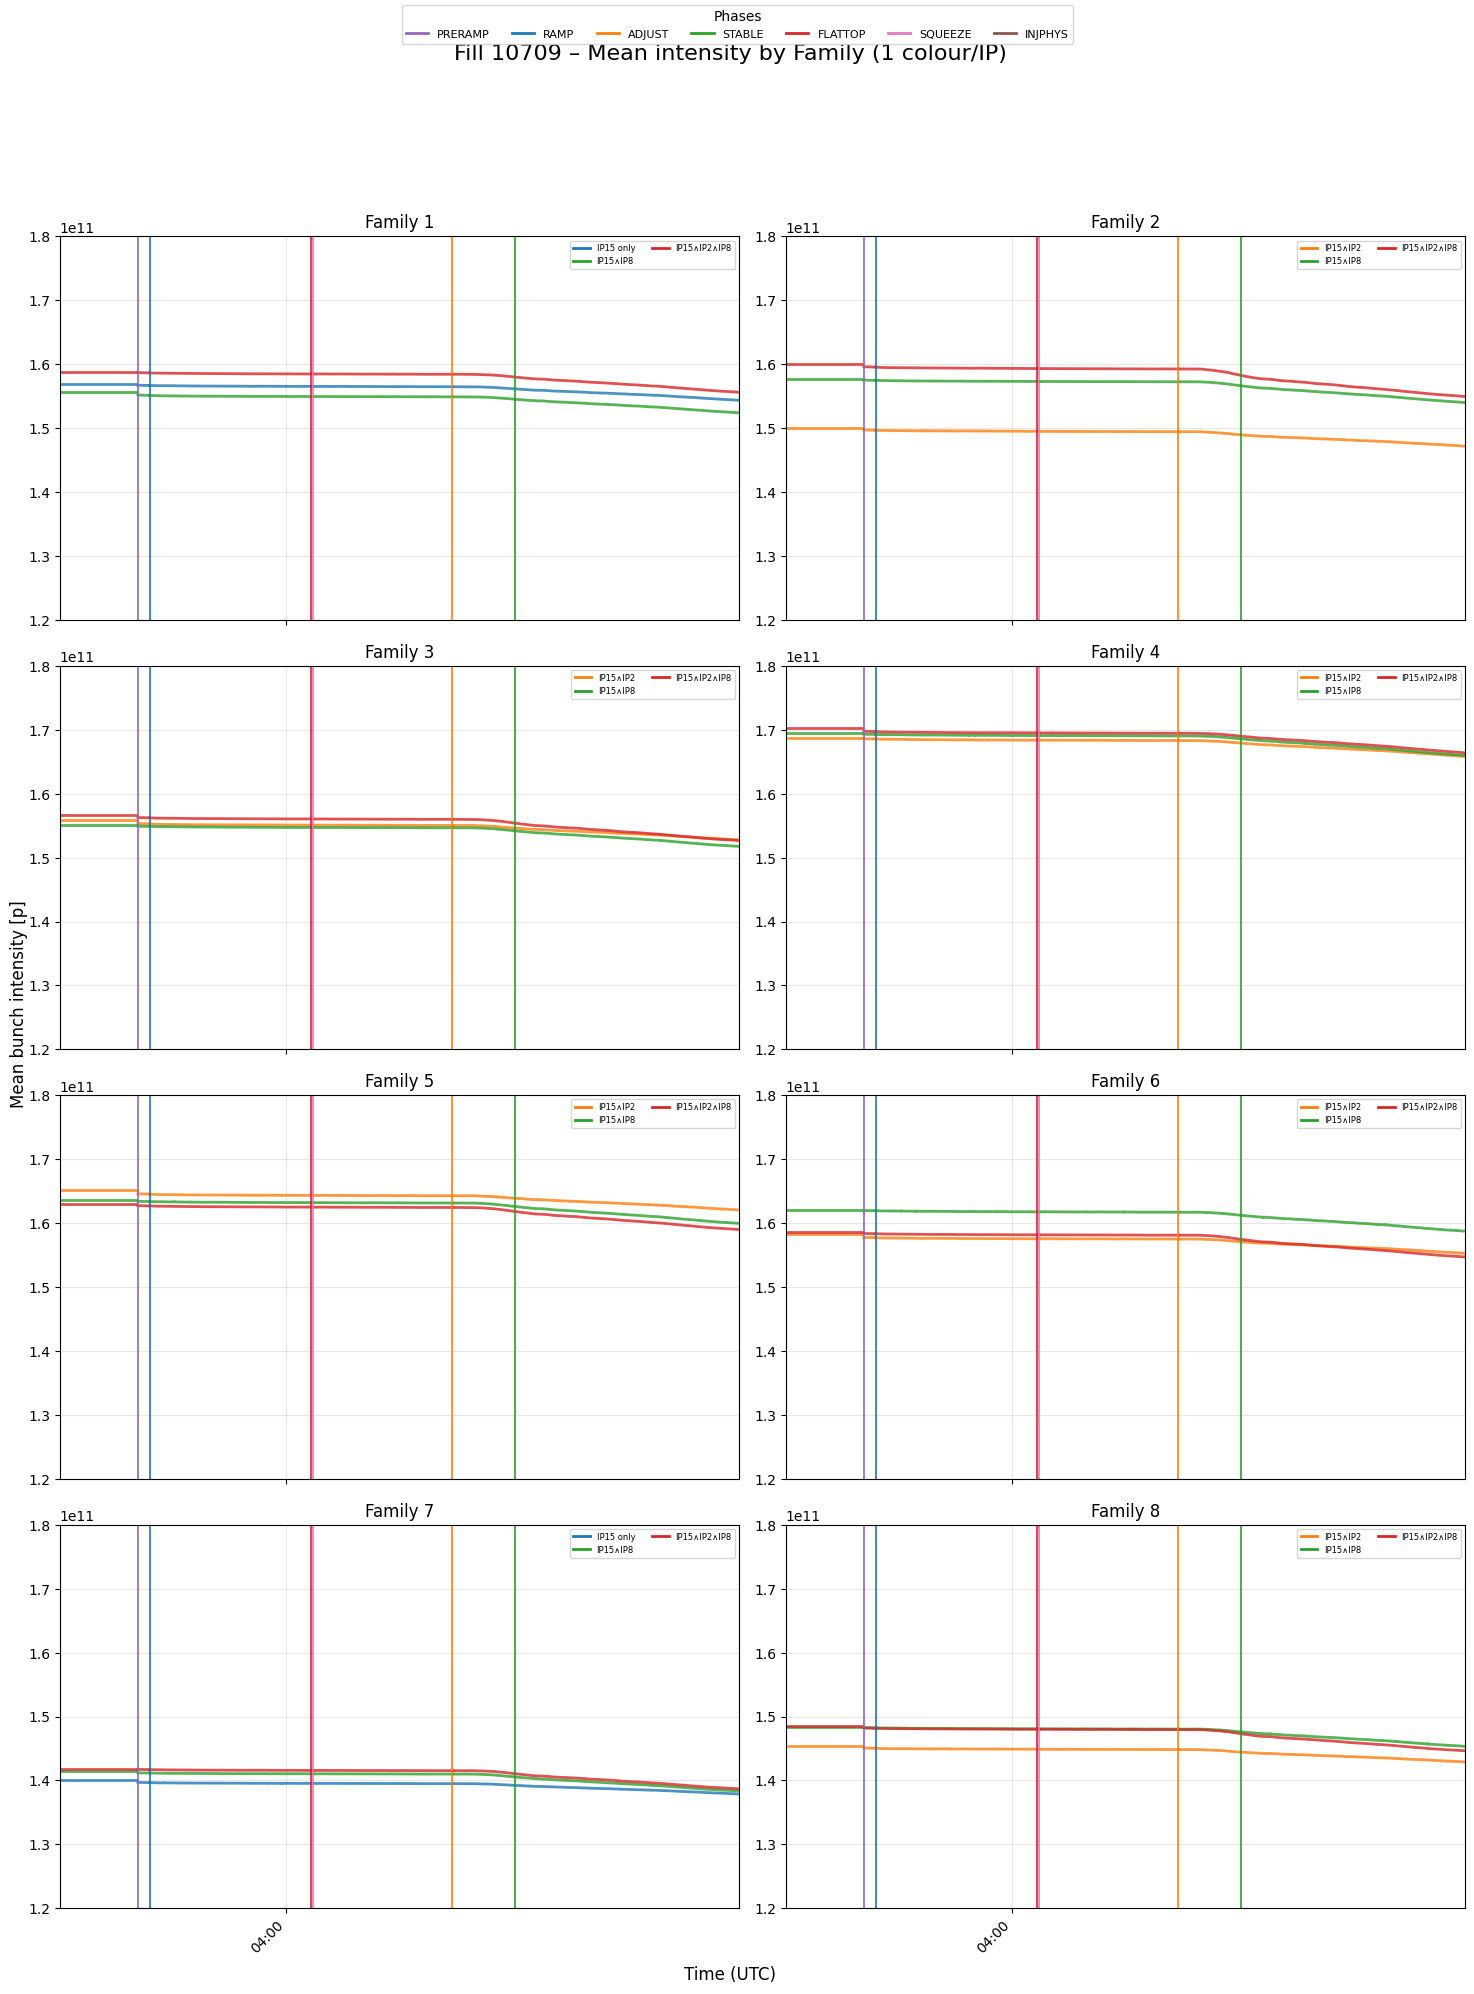

In [65]:
# ───────────────────────────────────────────────────────────────
# 6) Plot: one subplot per Family, with one colour per IP group
# ───────────────────────────────────────────────────────────────

# first build family_panels exactly as before
family_panels = {}
for fam_idx in range(8):
    fam_label = f"Family {fam_idx+1}"
    ip_list = []
    for ip_label, fam_arrays in IP_panels.items():
        slots = fam_arrays[fam_idx]
        if slots.size > 0:
            ip_list.append((ip_label, slots))
    if ip_list:
        family_panels[fam_label] = ip_list

# pick a color for each IP group
ip_labels = list(IP_panels.keys())
ip_palette = plt.cm.get_cmap("tab10").colors
ip_colors = {ip: ip_palette[i % len(ip_palette)] for i, ip in enumerate(ip_labels)}

# set up 4×2 grid
ncols, nrows = 2, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5*nrows), sharex=True)
axes = axes.flatten()[:len(family_panels)]

tidx      = ser_full.index
fill_date = tidx[0].normalize()
tmin      = fill_date + pd.Timedelta(hours=3, minutes=30)
tmax      = fill_date + pd.Timedelta(hours=5)

for ax, (fam_label, ip_list) in zip(axes, family_panels.items()):
    # for each IP group that this family sits in
    for ip_label, slots in ip_list:
        colour = ip_colors[ip_label]

        # non-injection phases
        for ph in phase_names:
            if ph != "INJPHYS":
                M_ph, ti_ph, t0_ph, _ = phase_data[ph]
                curve = mean_curve_phase(M_ph, slots)
                if curve is not None:
                    ax.plot(
                        ti_ph, curve,
                        color=colour,
                        linestyle=phase_styles[ph],
                        lw=2, alpha=0.8,
                        label=f"{ip_label} {ph}"
                    )

        # injection: plot horizontal line at the 2nd-sample mean
        fam_mean = np.nanmean(inj2[slots])
        ax.hlines(
            fam_mean, t0_inj, t1_inj,
            color=colour,
            linestyle=phase_styles["INJPHYS"],
            linewidth=2, alpha=0.8,
            label=f"{ip_label} INJ₂"
        )

    # vertical phase lines (still use phase_colors here)
    for ph in phase_names:
        _, _, t0_ph, _ = phase_data[ph]
        ax.axvline(
            t0_ph,
            color=phase_colors[ph],
            linestyle=phase_styles[ph],
            linewidth=1.2
        )

    ax.set_title(fam_label, fontsize=12)
    ax.set_xlim(tmin, tmax)
    ax.set_ylim(1.2e11, 1.8e11)
    ax.grid(alpha=0.3)
    # legend: one entry per IP group for this family
    handles = [
        Line2D([], [], color=ip_colors[ip], lw=2, label=ip)
        for ip, _ in ip_list
    ]
    ax.legend(handles=handles, fontsize=6, ncol=2)

# x-axis formatting
for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
for ax in axes[-2:]:
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

# overall phase legend along top
phase_handles = [
    Line2D([], [], color=phase_colors[p], linestyle=phase_styles[p], lw=2, label=p)
    for p in phase_names
]
fig.legend(
    handles=phase_handles,
    title="Phases",
    loc="upper center",
    ncol=len(phase_names),
    frameon=True,
    fontsize=8
)

fig.suptitle(f"Fill {fno} – Mean intensity by Family (1 colour/IP)", fontsize=16)
fig.supxlabel("Time (UTC)")
fig.supylabel("Mean bunch intensity [p]")
fig.tight_layout(rect=[0,0,1,0.92])
plt.show()


### Mean Intensities classified by Ip position

/tmp/ipykernel_3449522/2301362658.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap("tab10").colors


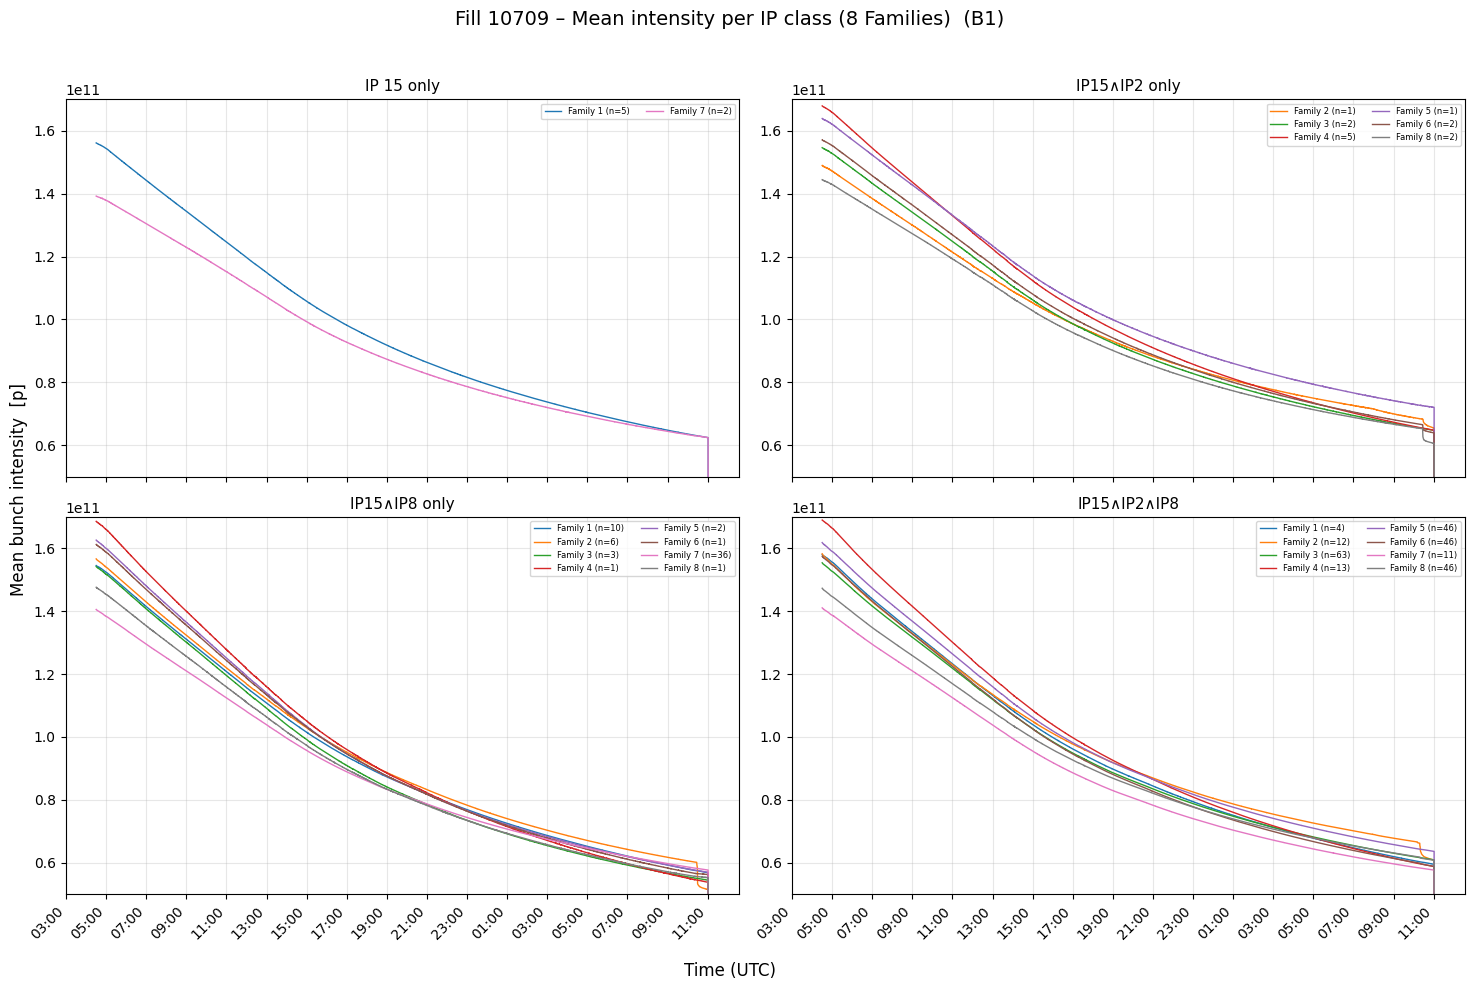

In [48]:
def mean_curve(slots):
    if slots.size == 0:
        return None
    return np.nanmean(M[:, slots], axis=1)

palette = plt.cm.get_cmap("tab10").colors
family_labels = [
    "Family 1", "Family 2", "Family 3", "Family 4", "Family 5",
    "Family 6", "Family 7", "Family 8"
]
IP_panels = {
    "IP 15 only"    : [Family_1_in_only_15,  Family_2_in_only_15,  Family_3_in_only_15,
                       Family_4_in_only_15,  Family_5_in_only_15,  Family_6_in_only_15,
                       Family_7_in_only_15,  Family_8_in_only_15],
    "IP 2 only"     : [Family_1_in_only_2,   Family_2_in_only_2,   Family_3_in_only_2,
                       Family_4_in_only_2,   Family_5_in_only_2,   Family_6_in_only_2,
                       Family_7_in_only_2,   Family_8_in_only_2],
    "IP 8 only"     : [Family_1_in_only_8,   Family_2_in_only_8,   Family_3_in_only_8,
                       Family_4_in_only_8,   Family_5_in_only_8,   Family_6_in_only_8,
                       Family_7_in_only_8,   Family_8_in_only_8],
    "IP15∧IP2 only" : [Family_1_in_only_15_2, Family_2_in_only_15_2, Family_3_in_only_15_2,
                       Family_4_in_only_15_2, Family_5_in_only_15_2, Family_6_in_only_15_2,
                       Family_7_in_only_15_2, Family_8_in_only_15_2],
    "IP15∧IP8 only" : [Family_1_in_only_15_8, Family_2_in_only_15_8, Family_3_in_only_15_8,
                       Family_4_in_only_15_8, Family_5_in_only_15_8, Family_6_in_only_15_8,
                       Family_7_in_only_15_8, Family_8_in_only_15_8],
    "IP2∧IP8 only"  : [Family_1_in_only_2_8,  Family_2_in_only_2_8,  Family_3_in_only_2_8,
                       Family_4_in_only_2_8,  Family_5_in_only_2_8,  Family_6_in_only_2_8,
                       Family_7_in_only_2_8,  Family_8_in_only_2_8],
    "IP15∧IP2∧IP8"  : [Family_1_in_only_15_2_8, Family_2_in_only_15_2_8, Family_3_in_only_15_2_8,
                       Family_4_in_only_15_2_8, Family_5_in_only_15_2_8, Family_6_in_only_15_2_8,
                       Family_7_in_only_15_2_8, Family_8_in_only_15_2_8]
}

# 2) Filter out any IP class where *all* families are empty
IP_panels = {
    ip_label: fam_arrays
    for ip_label, fam_arrays in IP_panels.items()
    if any(arr.size > 0 for arr in fam_arrays)
}

# 3) Prepare subplots grid based on how many panels survived
n_panels = len(IP_panels)
ncols    = 2
nrows    = math.ceil(n_panels / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5*nrows), sharex=True)
axes = axes.flatten()[:n_panels]

# 4) Plot and collect stats
table_rows = []
for ax, (ip_label, fam_arrays) in zip(axes, IP_panels.items()):
    for i, (fam_label, slots) in enumerate(zip(family_labels, fam_arrays)):
        curve = mean_curve(slots)
        if curve is None:
            continue
        ax.plot(time_index, curve,
                label=f"{fam_label} (n={len(slots)})",
                color=palette[i], lw=1)
        table_rows.append({
            "IP class": ip_label,
            "Family"  : fam_label,
            "n"       : len(slots),
            "mean"    : np.nanmean(curve),
            "std"     : np.nanstd(curve)
        })

    ax.set_title(ip_label, fontsize=11)
    ax.grid(alpha=0.3)
    ax.set_ylim(0.5e11, 1.7e11)
    ax.legend(fontsize=6, ncol=2)

for ax in axes:
    # 1) only show HH:MM
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    # 2) tick every 2 hours
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))

# 3) rotate the bottom‐row labels so they don’t overlap
for ax in axes[-2:]:
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# 5) Tidy up
fig.suptitle(f"Fill {fno} – Mean intensity per IP class (8 Families)  ({beam})", fontsize=14)
fig.supxlabel("Time (UTC)")
fig.supylabel("Mean bunch intensity  [p]")
fig.tight_layout(rect=[0,0,1,0.96])
plt.show()

/tmp/ipykernel_3449522/1373390410.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap("tab10").colors


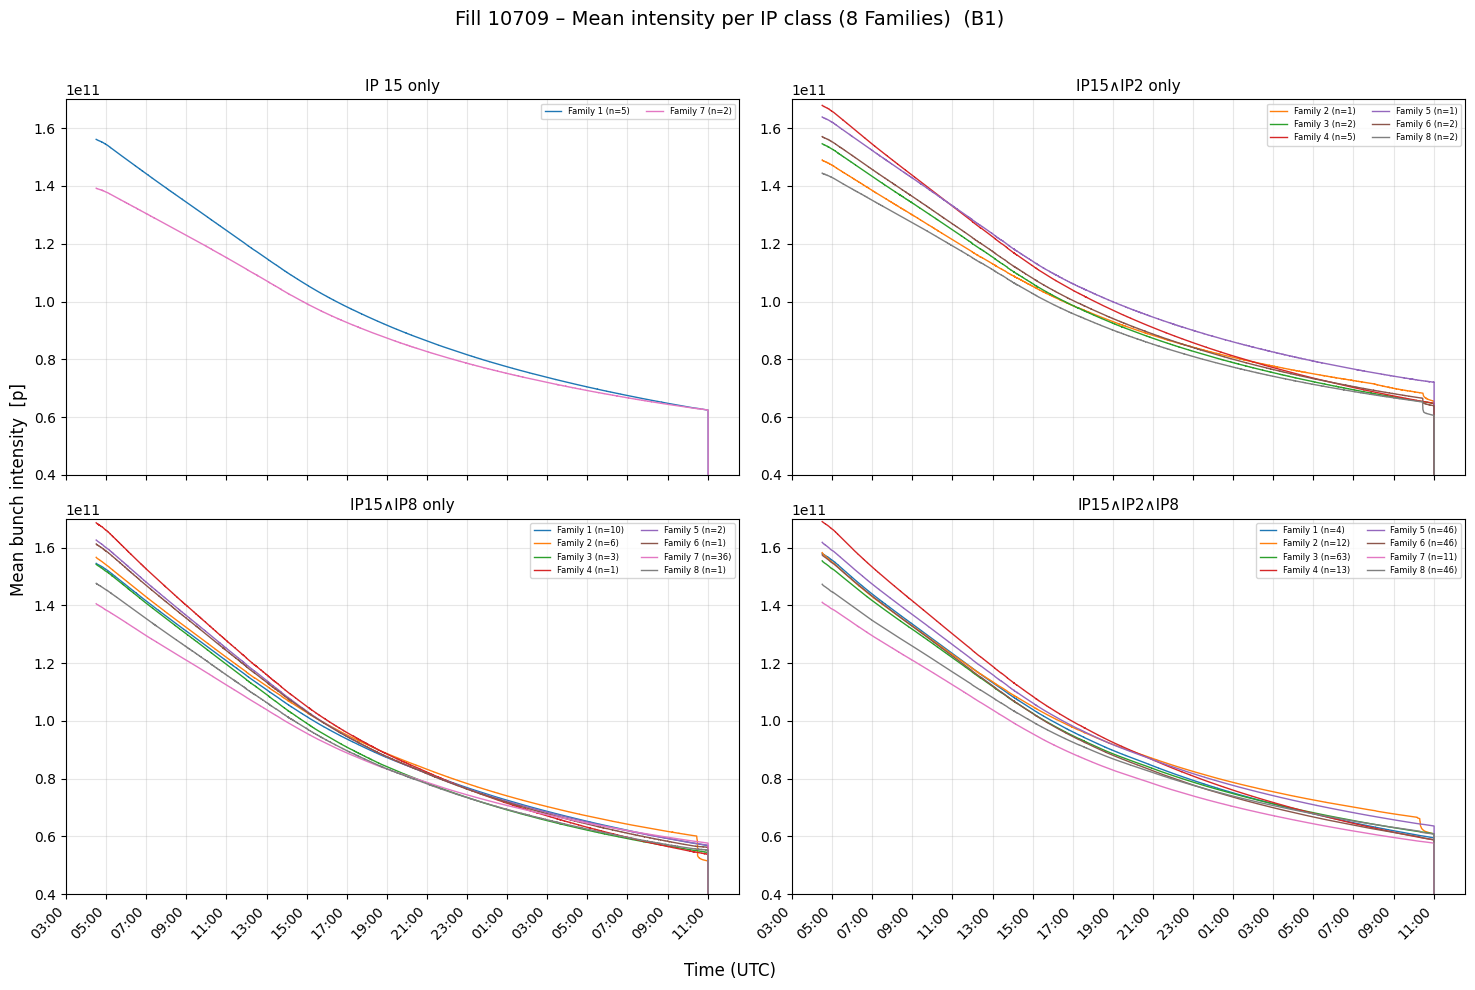

n          mean           std
IP class      Family                                  
IP 15 only    Family 1   5  9.694698e+10  2.764967e+10
              Family 7   2  9.147290e+10  2.306623e+10
IP15∧IP2 only Family 2   1  9.758643e+10  2.389593e+10
              Family 3   2  9.774928e+10  2.667307e+10
              Family 4   5  1.026284e+11  3.036721e+10
              Family 5   1  1.054626e+11  2.733292e+10
              Family 6   2  9.933499e+10  2.719554e+10
              Family 8   2  9.446241e+10  2.409846e+10
IP15∧IP2∧IP8  Family 1   4  9.512085e+10  2.853668e+10
              Family 2  12  9.733627e+10  2.650401e+10
              Family 3  63  9.436899e+10  2.753094e+10
              Family 4  13  9.856071e+10  3.197123e+10
              Family 5  46  9.799226e+10  2.858993e+10
              Family 6  46  9.396709e+10  2.863685e+10
              Family 7  11  8.779247e+10  2.447037e+10
              Family 8  46  9.185015e+10  2.513693e+10
IP15∧IP8 only Family 1  10  9.257176e+10  2.853129e+10
              Family 2   6  9.402198e+10  2.848884e+10
              Family 3   3  9.017863e+10  2.936756e+10
              Family 4   1  9.501952e+10  3.337313e+10
              Family 5   2  9.429227e+10  3.100715e+10
              Family 6   1  9.373880e+10  3.084938e+10
              Family 7  36  8.796063e+10  2.435168e+10
              Family 8   1  8.867208e+10  2.724517e+10

In [49]:
def mean_curve(slots):
    if slots.size == 0:
        return None
    return np.nanmean(M[:, slots], axis=1)

palette = plt.cm.get_cmap("tab10").colors
family_labels = [
    "Family 1", "Family 2", "Family 3", "Family 4", "Family 5",
    "Family 6", "Family 7", "Family 8"
]
IP_panels = {
    "IP 15 only"    : [Family_1_in_only_15,  Family_2_in_only_15,  Family_3_in_only_15,
                       Family_4_in_only_15,  Family_5_in_only_15,  Family_6_in_only_15,
                       Family_7_in_only_15,  Family_8_in_only_15],
    "IP 2 only"     : [Family_1_in_only_2,   Family_2_in_only_2,   Family_3_in_only_2,
                       Family_4_in_only_2,   Family_5_in_only_2,   Family_6_in_only_2,
                       Family_7_in_only_2,   Family_8_in_only_2],
    "IP 8 only"     : [Family_1_in_only_8,   Family_2_in_only_8,   Family_3_in_only_8,
                       Family_4_in_only_8,   Family_5_in_only_8,   Family_6_in_only_8,
                       Family_7_in_only_8,   Family_8_in_only_8],
    "IP15∧IP2 only" : [Family_1_in_only_15_2, Family_2_in_only_15_2, Family_3_in_only_15_2,
                       Family_4_in_only_15_2, Family_5_in_only_15_2, Family_6_in_only_15_2,
                       Family_7_in_only_15_2, Family_8_in_only_15_2],
    "IP15∧IP8 only" : [Family_1_in_only_15_8, Family_2_in_only_15_8, Family_3_in_only_15_8,
                       Family_4_in_only_15_8, Family_5_in_only_15_8, Family_6_in_only_15_8,
                       Family_7_in_only_15_8, Family_8_in_only_15_8],
    "IP2∧IP8 only"  : [Family_1_in_only_2_8,  Family_2_in_only_2_8,  Family_3_in_only_2_8,
                       Family_4_in_only_2_8,  Family_5_in_only_2_8,  Family_6_in_only_2_8,
                       Family_7_in_only_2_8,  Family_8_in_only_2_8],
    "IP15∧IP2∧IP8"  : [Family_1_in_only_15_2_8, Family_2_in_only_15_2_8, Family_3_in_only_15_2_8,
                       Family_4_in_only_15_2_8, Family_5_in_only_15_2_8, Family_6_in_only_15_2_8,
                       Family_7_in_only_15_2_8, Family_8_in_only_15_2_8]
}

# 2) Filter out any IP class where *all* families are empty
IP_panels = {
    ip_label: fam_arrays
    for ip_label, fam_arrays in IP_panels.items()
    if any(arr.size > 0 for arr in fam_arrays)
}

# 3) Prepare subplots grid based on how many panels survived
n_panels = len(IP_panels)
ncols    = 2
nrows    = math.ceil(n_panels / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5*nrows), sharex=True)
axes = axes.flatten()[:n_panels]

# 4) Plot and collect stats
table_rows = []
for ax, (ip_label, fam_arrays) in zip(axes, IP_panels.items()):
    for i, (fam_label, slots) in enumerate(zip(family_labels, fam_arrays)):
        curve = mean_curve(slots)
        if curve is None:
            continue
        ax.plot(time_index, curve,
                label=f"{fam_label} (n={len(slots)})",
                color=palette[i], lw=1)
        table_rows.append({
            "IP class": ip_label,
            "Family"  : fam_label,
            "n"       : len(slots),
            "mean"    : np.nanmean(curve),
            "std"     : np.nanstd(curve)
        })

    ax.set_title(ip_label, fontsize=11)
    ax.grid(alpha=0.3)
    ax.set_ylim(0.4e11, 1.7e11)
    ax.legend(fontsize=6, ncol=2)

for ax in axes:
    # only show hours:minutes
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    # put a tick every 2 hours
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))

# rotate the bottom‐row tick labels for readability
for ax in axes[-2:]:
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# 5) Tidy up
fig.suptitle(
    f"Fill {fno} – Mean intensity per IP class (8 Families)  ({beam})",
    fontsize=14
)
fig.supxlabel("Time (UTC)")
fig.supylabel("Mean bunch intensity  [p]")
fig.tight_layout(rect=[0,0,1,0.96])
plt.show()

# 6) Display stats table
stats_df = (
    pd.DataFrame(table_rows)
      .set_index(["IP class", "Family"])
      .sort_index()
)
display(stats_df)


### Choose graph for better visibility

/tmp/ipykernel_3449522/2885532538.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette     = plt.cm.get_cmap("tab10").colors


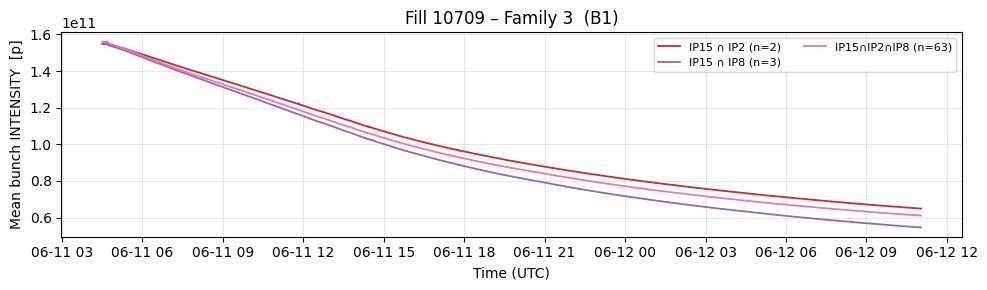

n          mean           std
IP class     Family                                  
IP15 ∩ IP2   Family 3   2  9.842905e+10  2.685785e+10
IP15 ∩ IP8   Family 3   3  9.092221e+10  2.962545e+10
IP15∩IP2∩IP8 Family 3  63  9.507927e+10  2.793955e+10

In [50]:

fno   = 10709
beam  = "B1"
intensity_var = f"LHC.BCTFR.B6R4.{beam}:BUNCH_INTENSITY"

DATADIR  = Path("/eos/project/l/lhc-lumimod/LuminosityFollowUp/2025/")
RAWPATH  = DATADIR / "rawdata"
FILLINFO = DATADIR / "fills-info"

fbmodes = pd.read_parquet(FILLINFO / "fills_and_bmodes_2025.parquet")
rowST   = (fbmodes.loc[fno]
                    .query("BMODE=='STABLE'")
                    .sort_values("tsStart"))
if rowST.empty:
    rowST = fbmodes.loc[fno].sort_values("tsEnd").iloc[[-1]]

t_start = pd.to_datetime(rowST["tsStart"].iloc[0], utc=True)
t_end   = pd.to_datetime(rowST["tsEnd"].iloc[0],   utc=True)

ser = (pd.read_parquet(RAWPATH / f"HX:FILLN={fno}",
                       columns=[intensity_var])[intensity_var])
ser.index = (pd.to_datetime(ser.index, utc=True, errors="coerce")
               .sort_values())
ser = ser[(ser.index >= t_start) & (ser.index <= t_end)].dropna()
if ser.empty:
    raise RuntimeError("no intensity data in STABLE window")

M           = np.stack(ser.values)         
time_index  = ser.index
palette     = plt.cm.get_cmap("tab10").colors

def a(x): return np.asarray(x, int)
families = {
    "Family 1" : {
    "IP15"         : np.asarray(Family_1_in_only_15,       int),
    "IP2"          : np.asarray(Family_1_in_only_2,        int),
    "IP8"          : np.asarray(Family_1_in_only_8,        int),
    "IP15 ∩ IP2"   : np.asarray(Family_1_in_only_15_2,     int),
    "IP15 ∩ IP8"   : np.asarray(Family_1_in_only_15_8,     int),
    "IP2  ∩ IP8"   : np.asarray(Family_1_in_only_2_8,      int),
    "IP15∩IP2∩IP8" : np.asarray(Family_1_in_only_15_2_8,   int),
    },
    "Family 2" : {
    "IP15"         : np.asarray(Family_2_in_only_15,       int),
    "IP2"          : np.asarray(Family_2_in_only_2,        int),
    "IP8"          : np.asarray(Family_2_in_only_8,        int),
    "IP15 ∩ IP2"   : np.asarray(Family_2_in_only_15_2,     int),
    "IP15 ∩ IP8"   : np.asarray(Family_2_in_only_15_8,     int),
    "IP2  ∩ IP8"   : np.asarray(Family_2_in_only_2_8,      int),
    "IP15∩IP2∩IP8" : np.asarray(Family_2_in_only_15_2_8,   int),
    },
    "Family 3" : {
    "IP15"         : np.asarray(Family_3_in_only_15,       int),
    "IP2"          : np.asarray(Family_3_in_only_2,        int),
    "IP8"          : np.asarray(Family_3_in_only_8,        int),
    "IP15 ∩ IP2"   : np.asarray(Family_3_in_only_15_2,     int),
    "IP15 ∩ IP8"   : np.asarray(Family_3_in_only_15_8,     int),
    "IP2  ∩ IP8"   : np.asarray(Family_3_in_only_2_8,      int),
    "IP15∩IP2∩IP8" : np.asarray(Family_3_in_only_15_2_8,   int),
    },
    "Family 4" : {
    "IP15"         : np.asarray(Family_4_in_only_15,       int),
    "IP2"          : np.asarray(Family_4_in_only_2,        int),
    "IP8"          : np.asarray(Family_4_in_only_8,        int),
    "IP15 ∩ IP2"   : np.asarray(Family_4_in_only_15_2,     int),
    "IP15 ∩ IP8"   : np.asarray(Family_4_in_only_15_8,     int),
    "IP2  ∩ IP8"   : np.asarray(Family_4_in_only_2_8,      int),
    "IP15∩IP2∩IP8" : np.asarray(Family_4_in_only_15_2_8,   int),
    },
    "Family 5" : {
    "IP15"         : np.asarray(Family_5_in_only_15,       int),
    "IP2"          : np.asarray(Family_5_in_only_2,        int),
    "IP8"          : np.asarray(Family_5_in_only_8,        int),
    "IP15 ∩ IP2"   : np.asarray(Family_5_in_only_15_2,     int),
    "IP15 ∩ IP8"   : np.asarray(Family_5_in_only_15_8,     int),
    "IP2  ∩ IP8"   : np.asarray(Family_5_in_only_2_8,      int),
    "IP15∩IP2∩IP8" : np.asarray(Family_5_in_only_15_2_8,   int),
    },
    "Family 6" : {
    "IP15"         : np.asarray(Family_6_in_only_15,       int),
    "IP2"          : np.asarray(Family_6_in_only_2,        int),
    "IP8"          : np.asarray(Family_6_in_only_8,        int),
    "IP15 ∩ IP2"   : np.asarray(Family_6_in_only_15_2,     int),
    "IP15 ∩ IP8"   : np.asarray(Family_6_in_only_15_8,     int),
    "IP2  ∩ IP8"   : np.asarray(Family_6_in_only_2_8,      int),
    "IP15∩IP2∩IP8" : np.asarray(Family_6_in_only_15_2_8,   int),
    },
    "Family 7" : {
    "IP15"         : np.asarray(Family_7_in_only_15,       int),
    "IP2"          : np.asarray(Family_7_in_only_2,        int),
    "IP8"          : np.asarray(Family_7_in_only_8,        int),
    "IP15 ∩ IP2"   : np.asarray(Family_7_in_only_15_2,     int),
    "IP15 ∩ IP8"   : np.asarray(Family_7_in_only_15_8,     int),
    "IP2  ∩ IP8"   : np.asarray(Family_7_in_only_2_8,      int),
    "IP15∩IP2∩IP8" : np.asarray(Family_7_in_only_15_2_8,   int),
    },
    "Family 8" : {
    "IP15"         : np.asarray(Family_8_in_only_15,       int),
    "IP2"          : np.asarray(Family_8_in_only_2,        int),
    "IP8"          : np.asarray(Family_8_in_only_8,        int),
    "IP15 ∩ IP2"   : np.asarray(Family_8_in_only_15_2,     int),
    "IP15 ∩ IP8"   : np.asarray(Family_8_in_only_15_8,     int),
    "IP2  ∩ IP8"   : np.asarray(Family_8_in_only_2_8,      int),
    "IP15∩IP2∩IP8" : np.asarray(Family_8_in_only_15_2_8,   int),
    },
}

IP_keys = [
    "IP15",      "IP2",      "IP8",
    "IP15 ∩ IP2","IP15 ∩ IP8","IP2  ∩ IP8",
    "IP15∩IP2∩IP8"
]
IP_panels = {ip: [families[f][ip] for f in families] for ip in IP_keys}


big_rows = []
for ip, fam_arrays in IP_panels.items():
    for fam_lbl, slots in zip(family_labels, fam_arrays):
        if slots.size == 0: continue
        big_rows.append({
            "IP class": ip,
            "Family"  : fam_lbl,
            "n"       : len(slots),
            "mean"    : np.nanmean(M[:, slots]),
            "std"     : np.nanstd(M[:, slots]),
        })
stats_df = (pd.DataFrame(big_rows)
            .set_index(["IP class", "Family"])
            .sort_index())


long_to_short = {k: v for k, v in zip(families.keys(), family_labels)}
short_to_long = {v: k for k, v in long_to_short.items()}

def plot_single(*, ip_class=None, family=None):
    """Zoom plot (INTENSITY).  Choose exactly one argument."""
    if (ip_class is None) == (family is None):
        raise ValueError("Specify exactly one of ip_class or family")

    if ip_class is not None:                 # ---- by IP class ----
        curves = zip(family_labels, IP_panels[ip_class])
        title  = ip_class
        table  = stats_df.loc[ip_class]
    else:                                    # ---- by Family ------
        fam_long  = short_to_long.get(family, family)   # accept short or long
        if fam_long not in families:
            raise KeyError(f"Family '{family}' not found.")
        fam_short = long_to_short[fam_long]
        curves = families[fam_long].items()
        title  = fam_long
        table  = stats_df.xs(fam_short, level="Family", drop_level=False)

    plt.figure(figsize=(10, 3))
    for i, (lbl, slots) in enumerate(curves):
        slots = np.asarray(slots, int)
        if slots.size == 0: continue
        y = np.nanmean(M[:, slots], axis=1)
        plt.plot(time_index, y,
                 label=f"{lbl} (n={len(slots)})",
                 color=palette[i % len(palette)], lw=1.3)
    plt.xlabel("Time (UTC)")
    plt.ylabel("Mean bunch INTENSITY  [p]")
    plt.title(f"Fill {fno} – {title}  ({beam})")
    plt.grid(alpha=.3); plt.legend(ncol=2, fontsize=8)
    plt.tight_layout(); plt.show()
    display(table)
# plot_single(ip_class="IP15")           # eight family curves
plot_single(family="Family 3")     # seven IP curves (long name)
# plot_single(family="Max")              # seven IP curves (short name)


## Emmitance H

### Mean Horizontal Emmitance classified by bunch position

/tmp/ipykernel_3449522/1887906702.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette    = plt.cm.get_cmap("tab10").colors


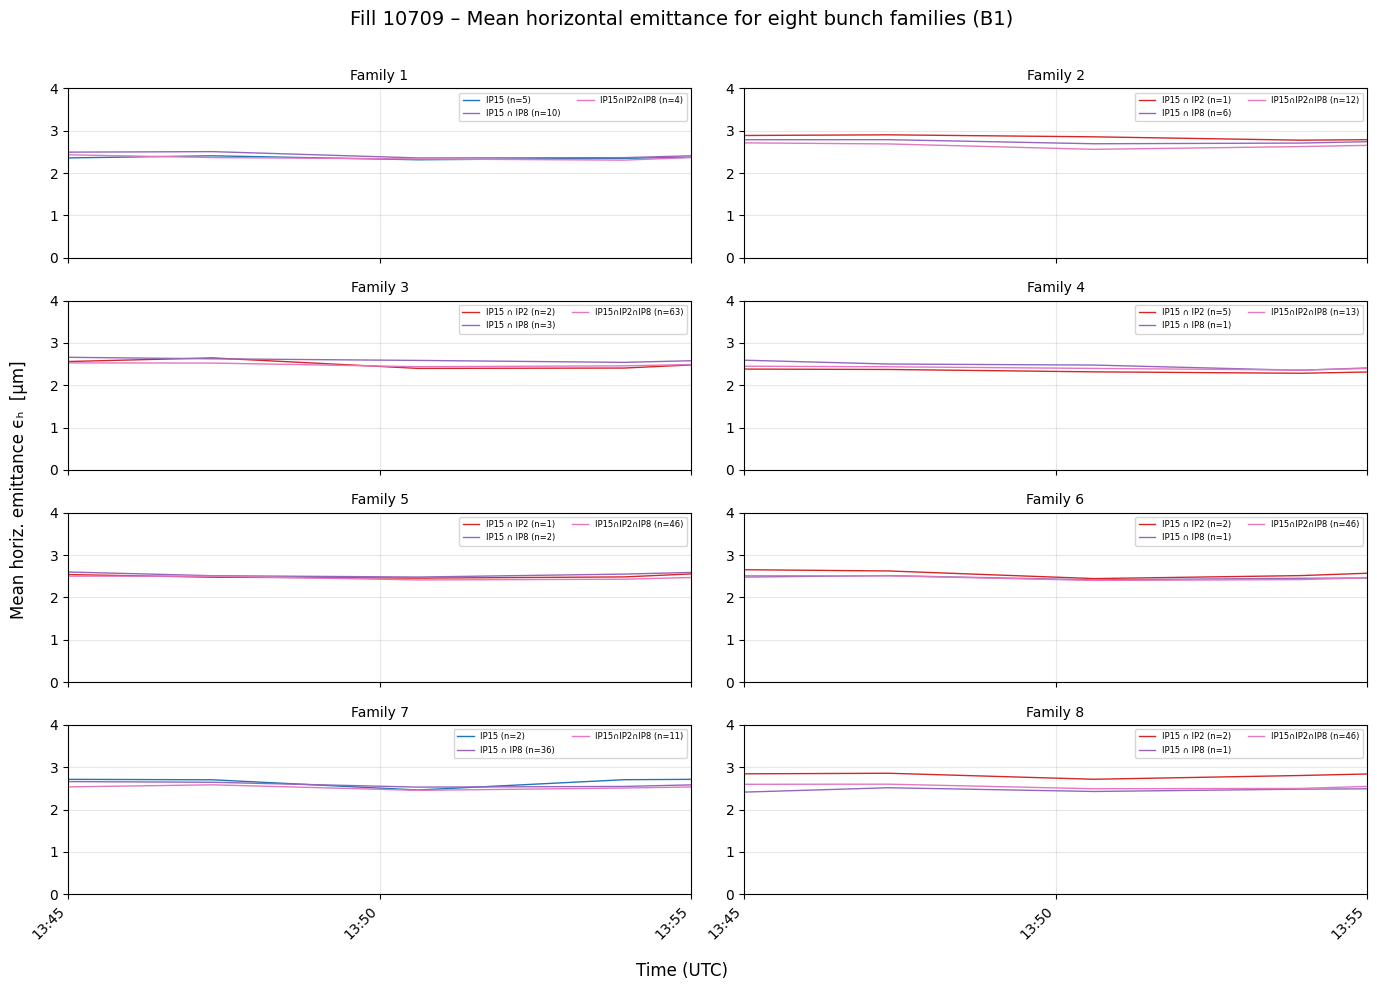

n      mean       std
Family   Group                               
Family 1 IP15           5  2.507051  0.867167
         IP15 ∩ IP8    10  2.486025  1.857531
         IP15∩IP2∩IP8   4  2.365549  0.524755
Family 2 IP15 ∩ IP2     1  2.982884  0.578309
         IP15 ∩ IP8     6  2.657469  0.869215
         IP15∩IP2∩IP8  12  2.969201  2.349660
Family 3 IP15 ∩ IP2     2  2.599407  0.296739
         IP15 ∩ IP8     3  2.237219  1.119793
         IP15∩IP2∩IP8  63  2.659050  2.681535
Family 4 IP15 ∩ IP2     5  2.458973  1.059336
         IP15 ∩ IP8     1  2.330682  0.878237
         IP15∩IP2∩IP8  13  2.480017  1.018410
Family 5 IP15 ∩ IP2     1  2.588298  0.273536
         IP15 ∩ IP8     2  2.489057  0.872608
         IP15∩IP2∩IP8  46  2.664610  1.294497
Family 6 IP15 ∩ IP2     2  2.705909  0.357903
         IP15 ∩ IP8     1  2.434249  0.882359
         IP15∩IP2∩IP8  46  2.581294  1.472509
Family 7 IP15           2  2.692086  0.397330
         IP15 ∩ IP8    36  2.600765  2.133935
         IP15∩IP2∩IP8  11  2.373893  0.762494
Family 8 IP15 ∩ IP2     2  2.958496  0.434905
         IP15 ∩ IP8     1  2.282452  1.175863
         IP15∩IP2∩IP8  46  2.598026  0.695129

In [89]:


fno   = 10709
beam  = "B1"
emit_H_var = f"LHC.BSRT.5R4.{beam}:BUNCH_EMITTANCE_H"   # horizontal εH

# ── STABLE‐beam window ─────────────────────────────────────
fbmodes = pd.read_parquet(FILLINFO / "fills_and_bmodes_2025.parquet")
rowST   = (fbmodes.loc[fno]
                    .query("BMODE=='STABLE'")
                    .sort_values("tsStart"))
if rowST.empty:
    rowST = fbmodes.loc[fno].sort_values("tsEnd").iloc[[-1]]

t_start = pd.to_datetime(rowST["tsStart"].iloc[0], utc=True)
t_end   = pd.to_datetime(rowST["tsEnd"].iloc[0],   utc=True)

# ── load εH parquet and slice to STABLE interval ───────────
ser = (pd.read_parquet(RAWPATH / f"HX:FILLN={fno}",
                       columns=[emit_H_var])[emit_H_var])
ser.index = pd.to_datetime(ser.index, utc=True,
                           errors="coerce").sort_values()
ser = ser[(ser.index >= t_start) & (ser.index <= t_end)].dropna()
if ser.empty:
    raise RuntimeError("No horizontal-emittance samples in STABLE window.")

M          = np.stack(ser.values)       # shape  nTimes × 3564
time_index = ser.index                  # x-axis (≈ hundreds of points)
palette    = plt.cm.get_cmap("tab10").colors


plot_date   = time_index[0].date().isoformat()  # e.g. "2025-06-11"
window_start = "13:45"   # ← change this
window_end   = "13:55"   # ← and this

xmin = pd.to_datetime(f"{plot_date} {window_start}:00+00:00")
xmax = pd.to_datetime(f"{plot_date} {window_end  }:00+00:00")
# ╔══════════════════════════════════════════════════════════╗
# ║ 2.  helpers                                              ║
# ╚══════════════════════════════════════════════════════════╝
def to_arr(x): return np.asarray(x, int)     # convert to 1-D int array
a = to_arr                                    # handy alias

def mean_curve(slots):
    """Time-series mean over the given bunch IDs."""
    slots = np.asarray(slots, int)
    return None if slots.size == 0 else np.nanmean(M[:, slots], axis=1)

fig, axes = plt.subplots(4, 2, figsize=(14, 10), sharex=True)
axes = axes.flatten()
all_stats = []

for ax, (fam_name, fam_groups) in zip(axes, families.items()):
    for i, (grp_lbl, slots) in enumerate(fam_groups.items()):
        curve = mean_curve(slots)
        if curve is None:
            continue
        ax.plot(time_index, curve,
                label=f"{grp_lbl} (n={len(slots)})",
                color=palette[i % len(palette)], lw=1)
        all_stats.append({
            "Family": fam_name,
            "Group" : grp_lbl,
            "n"     : len(slots),
            "mean"  : np.nanmean(curve),
            "std"   : np.nanstd(curve),
        })
    ax.set_title(fam_name, fontsize=10)
    ax.set_ylim(0, 4)
    ax.grid(alpha=.3)
    ax.set_xlim(xmin,xmax)
    ax.legend(fontsize=6, ncol=2)

for ax in axes:
    # only show hours:minutes
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    # tick every 2 hours
    ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
    #ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    #ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))

# tilt the bottom-row labels for readability
for ax in axes[-2:]:
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# 5) Tidy up
fig.suptitle(
    f"Fill {fno} – Mean horizontal emittance for eight bunch families ({beam})",
    fontsize=14
)
fig.supxlabel("Time (UTC)")
fig.supylabel("Mean horiz. emittance ϵₕ  [µm]")
fig.tight_layout(rect=[0,0,1,0.97])
plt.show()

# 6) Display stats table
stats_df = (
    pd.DataFrame(all_stats)
      .set_index(["Family", "Group"])
      .sort_index()
)
display(stats_df)

Normalizing against: 2025-06-11 05:41:14.015000+00:00


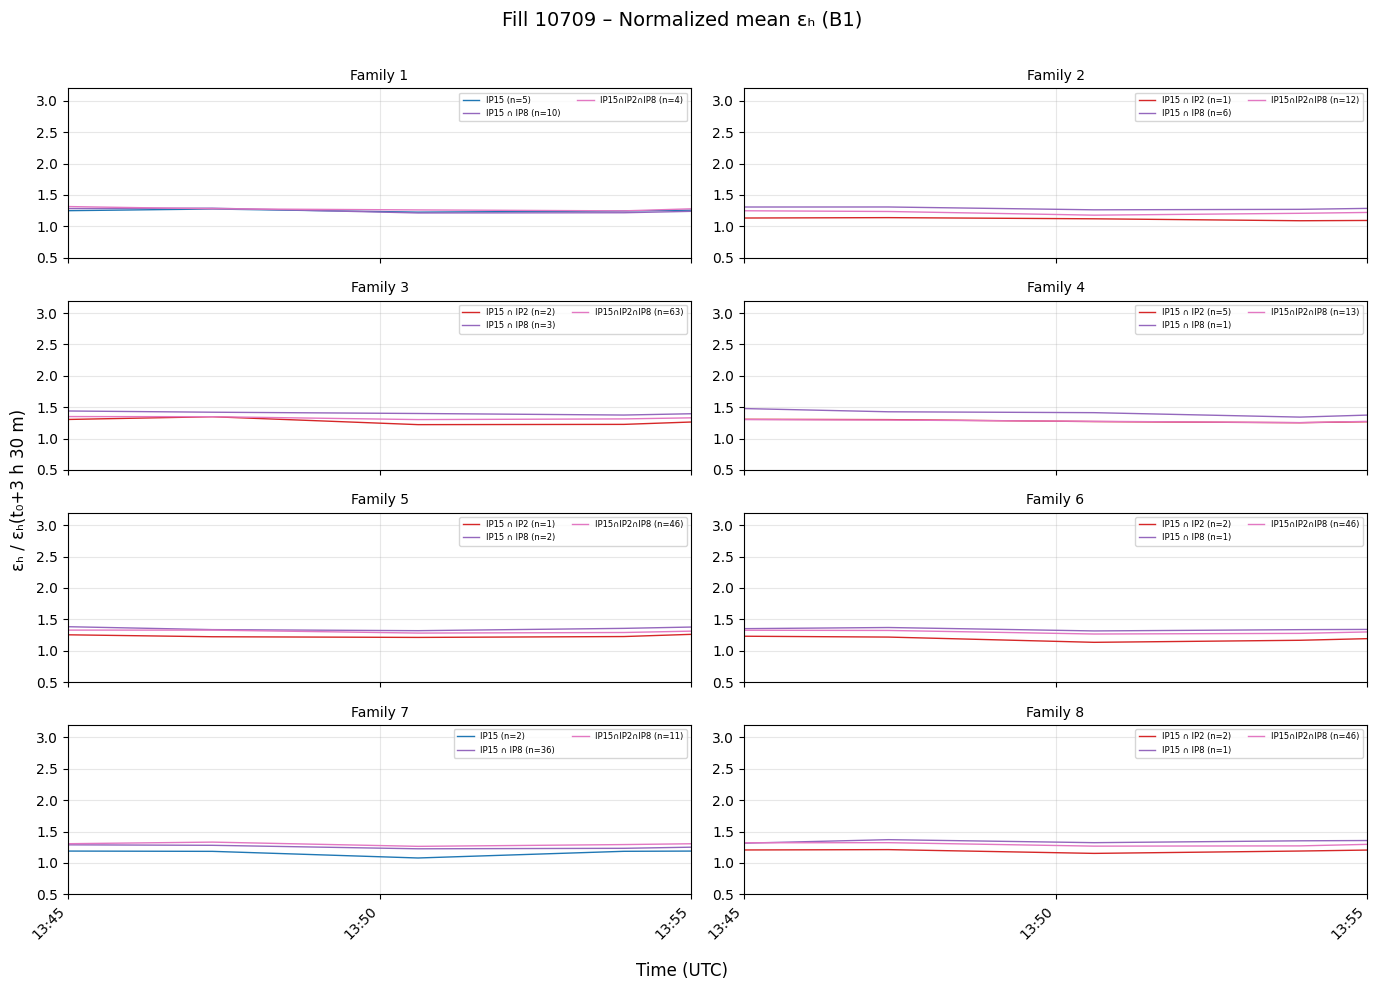

n  mean_norm  std_norm  ref_value
Family   Group                                           
Family 1 IP15           5   1.329306  0.459795   1.885985
         IP15 ∩ IP8    10   1.279995  0.956399   1.942214
         IP15∩IP2∩IP8   4   1.279737  0.283887   1.848464
Family 2 IP15 ∩ IP2     1   1.170439  0.226920   2.548518
         IP15 ∩ IP8     6   1.247485  0.408032   2.130261
         IP15∩IP2∩IP8  12   1.366602  1.081452   2.172689
Family 3 IP15 ∩ IP2     2   1.324488  0.151199   1.962575
         IP15 ∩ IP8     3   1.210610  0.605946   1.848010
         IP15∩IP2∩IP8  63   1.420629  1.432641   1.871742
Family 4 IP15 ∩ IP2     5   1.349185  0.581235   1.822561
         IP15 ∩ IP8     1   1.329462  0.500962   1.753102
         IP15∩IP2∩IP8  13   1.318543  0.541455   1.880876
Family 5 IP15 ∩ IP2     1   1.277601  0.135019   2.025904
         IP15 ∩ IP8     2   1.323800  0.464095   1.880237
         IP15∩IP2∩IP8  46   1.415314  0.687575   1.882699
Family 6 IP15 ∩ IP2     2   1.255147  0.166015   2.155850
         IP15 ∩ IP8     1   1.326246  0.480733   1.835443
         IP15∩IP2∩IP8  46   1.361512  0.776679   1.895903
Family 7 IP15           2   1.178931  0.174001   2.283498
         IP15 ∩ IP8    36   1.258880  1.032914   2.065936
         IP15∩IP2∩IP8  11   1.222568  0.392688   1.941727
Family 8 IP15 ∩ IP2     2   1.254472  0.184410   2.358360
         IP15 ∩ IP8     1   1.243343  0.640540   1.835738
         IP15∩IP2∩IP8  46   1.321364  0.353545   1.966169

In [90]:
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# ── reference at t_start ───────────────────────────────────────
ref_time = t_start + pd.Timedelta(hours=1, minutes=10)
ref_idx  = (np.abs(time_index - ref_time)).argmin()
print("Normalizing against:", time_index[ref_idx])

fig, axes = plt.subplots(4, 2, figsize=(14, 10), sharex=True)
axes = axes.flatten()
all_stats = []

for ax, (fam_name, fam_groups) in zip(axes, families.items()):
    for i, (grp_lbl, slots) in enumerate(fam_groups.items()):
        curve = mean_curve(slots)
        if curve is None:
            continue

        # value of that mean at ~3:30
        ref_val = curve[ref_idx]
        if not np.isfinite(ref_val) or ref_val == 0:
            continue

        norm_curve = curve / ref_val   # now norm_curve[ref_idx] == 1.0

        ax.plot(time_index, norm_curve,
                label=f"{grp_lbl} (n={len(slots)})",
                color=palette[i % len(palette)], lw=1)

        all_stats.append({
            "Family":       fam_name,
            "Group":        grp_lbl,
            "n":            len(slots),
            "mean_norm":    np.nanmean(norm_curve),
            "std_norm":     np.nanstd(norm_curve),
            "ref_value":    ref_val,
        })

    ax.set_title(fam_name, fontsize=10)
    ax.set_ylim(0.5, 3.2)
    ax.set_xlim(xmin,xmax)
    ax.grid(alpha=0.3)
    ax.legend(fontsize=6, ncol=2)

# ── format x-axis ─────────────────────────────────────────────────────────
for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    #ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
for ax in axes[-2:]:
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# ── final touches ─────────────────────────────────────────────────────────
fig.suptitle(
    f"Fill {fno} – Normalized mean εₕ ({beam})",
    fontsize=14
)
fig.supxlabel("Time (UTC)")
fig.supylabel("εₕ / εₕ(t₀+3 h 30 m)")
fig.tight_layout(rect=[0,0,1,0.97])
plt.show()

# ── stats table ───────────────────────────────────────────────────────────
stats_df = (
    pd.DataFrame(all_stats)
      .set_index(["Family", "Group"])
      .sort_index()
)
display(stats_df)


### Mean Horizontal Emmitance classified by IP position


/tmp/ipykernel_3449522/853619778.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_palette  = plt.cm.get_cmap("tab10").colors


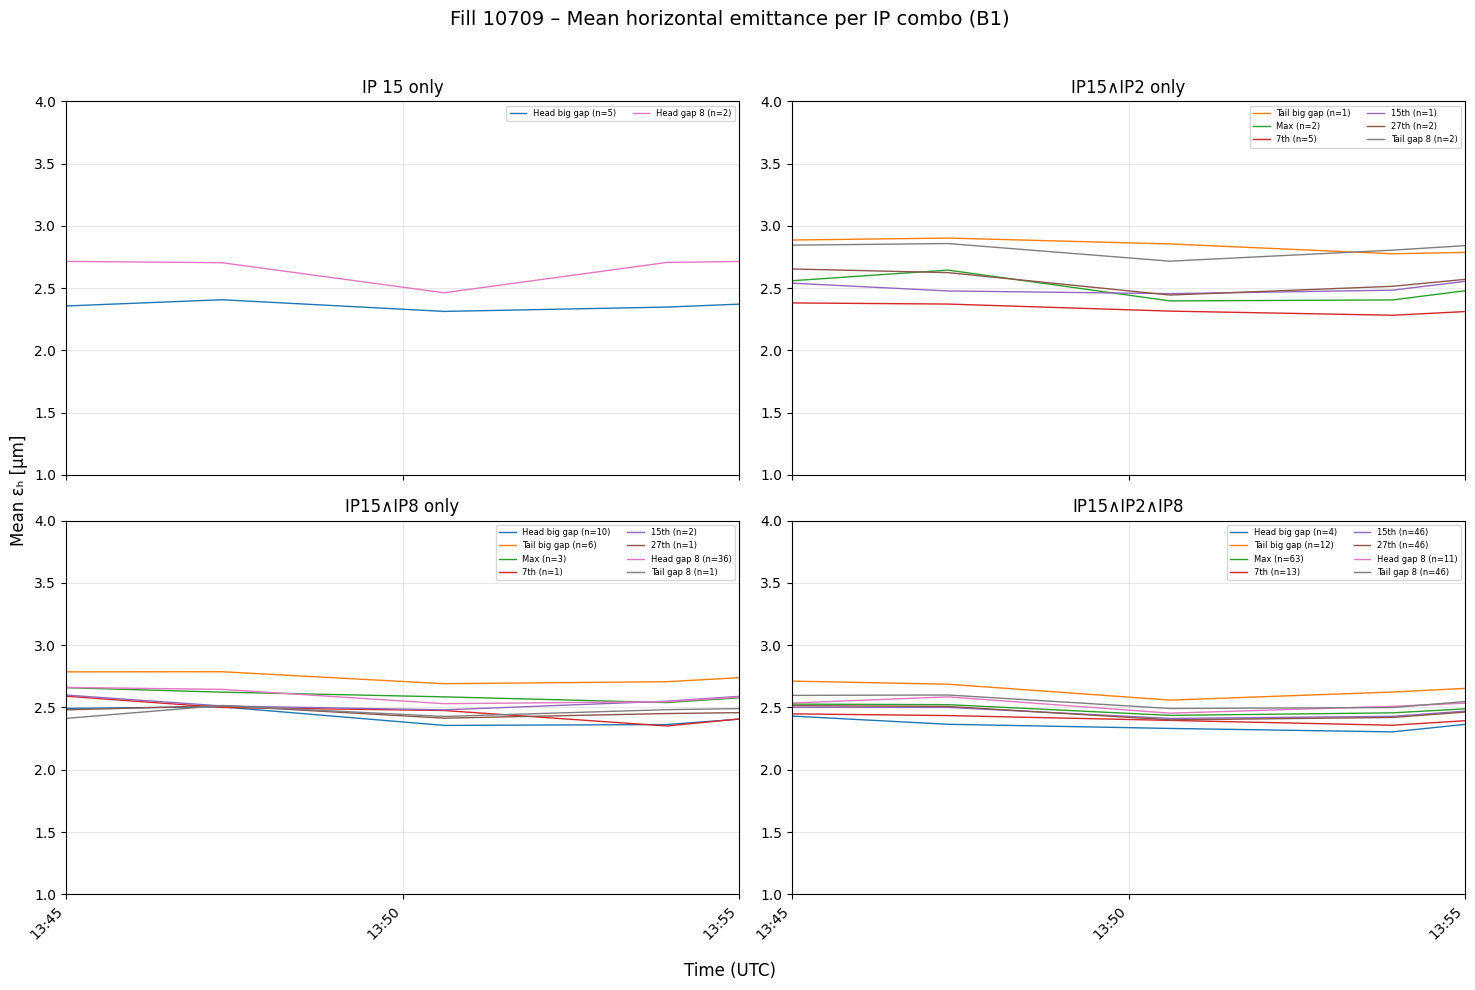

n      mean       std
IP combo      Family                              
IP 15 only    Head big gap   5  2.507051  0.867167
              Head gap 8     2  2.692086  0.397330
IP15∧IP2 only 15th           1  2.588298  0.273536
              27th           2  2.705909  0.357903
              7th            5  2.458973  1.059336
              Max            2  2.599407  0.296739
              Tail big gap   1  2.982884  0.578309
              Tail gap 8     2  2.958496  0.434905
IP15∧IP2∧IP8  15th          46  2.664610  1.294497
              27th          46  2.581294  1.472509
              7th           13  2.480017  1.018410
              Head big gap   4  2.365549  0.524755
              Head gap 8    11  2.373893  0.762494
              Max           63  2.659050  2.681535
              Tail big gap  12  2.969201  2.349660
              Tail gap 8    46  2.598026  0.695129
IP15∧IP8 only 15th           2  2.489057  0.872608
              27th           1  2.434249  0.882359
              7th            1  2.330682  0.878237
              Head big gap  10  2.486025  1.857531
              Head gap 8    36  2.600765  2.133935
              Max            3  2.237219  1.119793
              Tail big gap   6  2.657469  0.869215
              Tail gap 8     1  2.282452  1.175863

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ── Assumed preloaded data ─────────────────────────────────────────────────
#  M           : 2D array shape (n_times, n_bunches)
#  time_index  : DatetimeIndex of length n_times
#  families    : dict of dicts, families["Family 1"]["IP15"] → np.ndarray
#  family_labels = list(families.keys())

# ── 1. Build a consistent color map for each Family ────────────────────────
base_palette  = plt.cm.get_cmap("tab10").colors
family_colors = {
    fam: base_palette[i % len(base_palette)]
    for i, fam in enumerate(family_labels)
}

# ── 2. Helper to compute the mean‐curve for a given slot list ─────────────
def mean_curve(slots):
    return None if slots.size == 0 else np.nanmean(M[:, slots], axis=1)

# ── 3. Your IP_panels definition (must match these exact keys) ─────────────
IP_panels = {
    "IP 15 only":    [np.asarray(Family_i_in_only_15,   int) for Family_i_in_only_15 in [
                       Family_1_in_only_15, Family_2_in_only_15, Family_3_in_only_15,
                       Family_4_in_only_15, Family_5_in_only_15, Family_6_in_only_15,
                       Family_7_in_only_15, Family_8_in_only_15]],
    "IP15∧IP2 only": [np.asarray(Family_i_in_only_15_2, int) for Family_i_in_only_15_2 in [
                       Family_1_in_only_15_2, Family_2_in_only_15_2, Family_3_in_only_15_2,
                       Family_4_in_only_15_2, Family_5_in_only_15_2, Family_6_in_only_15_2,
                       Family_7_in_only_15_2, Family_8_in_only_15_2]],
    "IP15∧IP8 only": [np.asarray(Family_i_in_only_15_8, int) for Family_i_in_only_15_8 in [
                       Family_1_in_only_15_8, Family_2_in_only_15_8, Family_3_in_only_15_8,
                       Family_4_in_only_15_8, Family_5_in_only_15_8, Family_6_in_only_15_8,
                       Family_7_in_only_15_8, Family_8_in_only_15_8]],
    "IP15∧IP2∧IP8":   [np.asarray(Family_i_in_only_15_2_8, int) for Family_i_in_only_15_2_8 in [
                       Family_1_in_only_15_2_8, Family_2_in_only_15_2_8, Family_3_in_only_15_2_8,
                       Family_4_in_only_15_2_8, Family_5_in_only_15_2_8, Family_6_in_only_15_2_8,
                       Family_7_in_only_15_2_8, Family_8_in_only_15_2_8]],
}

# ── 4. Which panels to draw (exactly the keys above) ───────────────────────
keep_panels = list(IP_panels.keys())

# ── 5. Plot setup ─────────────────────────────────────────────────────────
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True)
axes = axes.flatten()[:len(keep_panels)]
big_stats = []

for ax, ip_lbl in zip(axes, keep_panels):
    slot_arrays = IP_panels[ip_lbl]
    for fam_name, slots in zip(family_labels, slot_arrays):
        slots = np.asarray(slots, int)
        if slots.size == 0:
            continue

        curve = mean_curve(slots)
        if curve is None:
            continue

        ax.plot(time_index, curve,
                label=f"{fam_name} (n={len(slots)})",
                color=family_colors[fam_name],
                lw=1)

        big_stats.append({
            "IP combo": ip_lbl,
            "Family":   fam_name,
            "n":        len(slots),
            "mean":     np.nanmean(curve),
            "std":      np.nanstd(curve),
        })

    ax.set_title(ip_lbl, fontsize=12)
    ax.set_ylim(1, 4)
    ax.grid(alpha=0.3)
    ax.set_xlim(xmin,xmax)
    ax.legend(fontsize=6, ncol=2)

# ── 6. Shared x-axis formatting ────────────────────────────────────────────
for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    #ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
for ax in axes[-2:]:
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# ── 7. Final touches ──────────────────────────────────────────────────────
fig.suptitle(f"Fill {fno} – Mean horizontal emittance per IP combo ({beam})",
             fontsize=14)
fig.supxlabel("Time (UTC)")
fig.supylabel("Mean εₕ [µm]")
fig.tight_layout(rect=[0,0,1,0.96])
plt.show()

# ── 8. Display stats table ─────────────────────────────────────────────────
stats_df = (
    pd.DataFrame(big_stats)
      .set_index(["IP combo", "Family"])
      .sort_index()
)
display(stats_df)


Normalizing each family at: 2025-06-11 05:41:14.015000+00:00


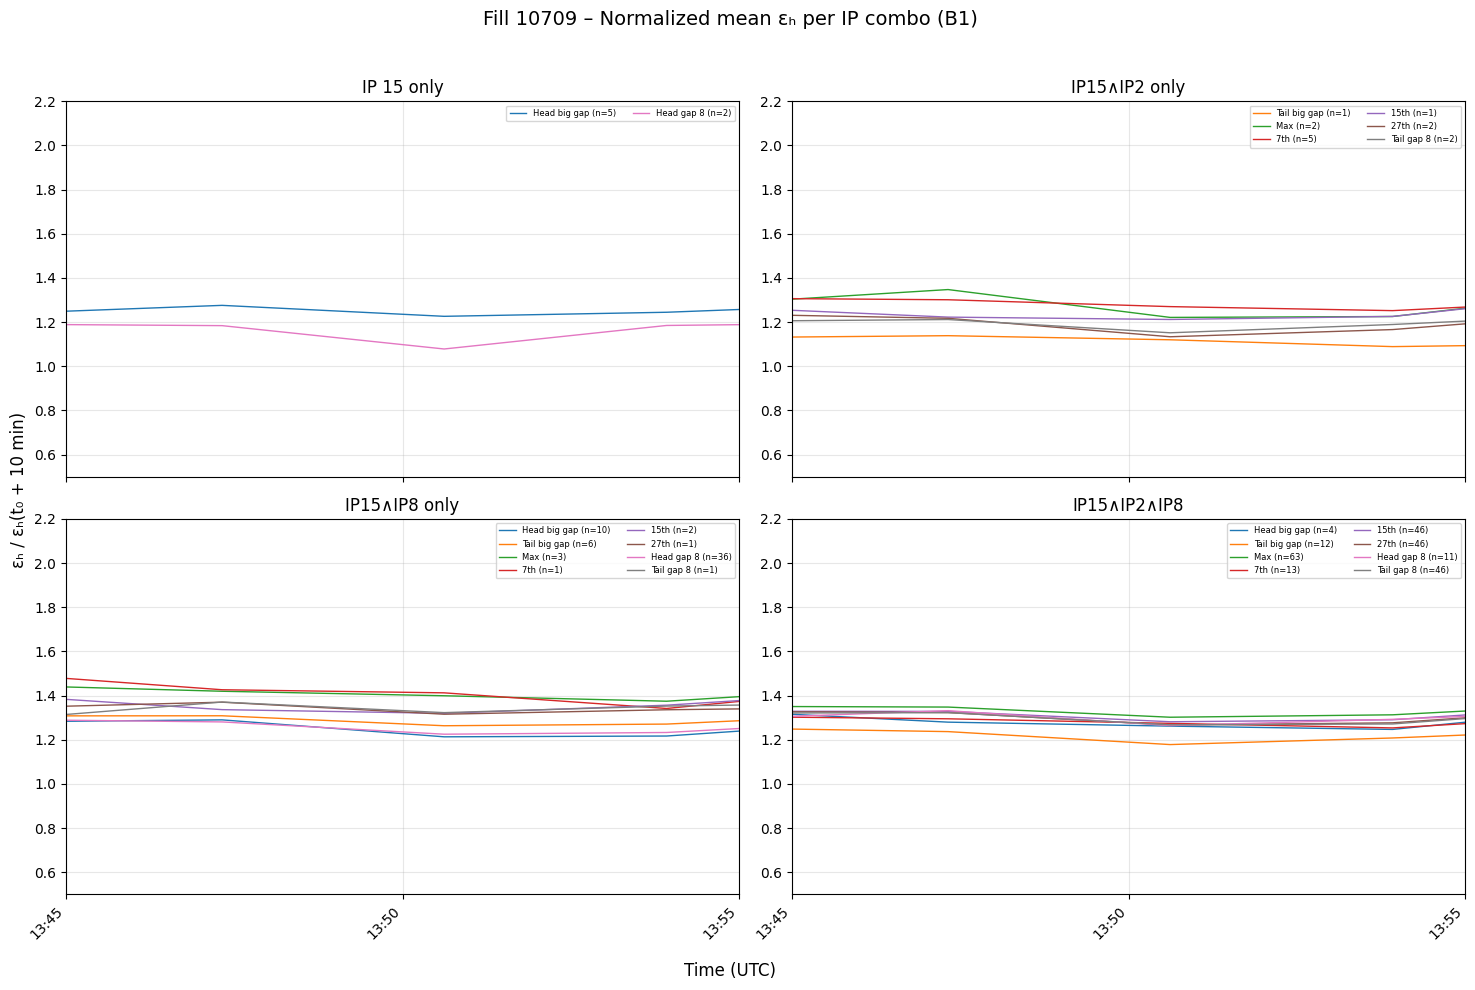

n      mean       std
IP combo      Family                              
IP 15 only    Head big gap   5  1.329306  0.459795
              Head gap 8     2  1.178931  0.174001
IP15∧IP2 only 15th           1  1.277601  0.135019
              27th           2  1.255147  0.166015
              7th            5  1.349185  0.581235
              Max            2  1.324488  0.151199
              Tail big gap   1  1.170439  0.226920
              Tail gap 8     2  1.254472  0.184410
IP15∧IP2∧IP8  15th          46  1.415314  0.687575
              27th          46  1.361512  0.776679
              7th           13  1.318543  0.541455
              Head big gap   4  1.279737  0.283887
              Head gap 8    11  1.222568  0.392688
              Max           63  1.420629  1.432641
              Tail big gap  12  1.366602  1.081452
              Tail gap 8    46  1.321364  0.353545
IP15∧IP8 only 15th           2  1.323800  0.464095
              27th           1  1.326246  0.480733
              7th            1  1.329462  0.500962
              Head big gap  10  1.279995  0.956399
              Head gap 8    36  1.258880  1.032914
              Max            3  1.210610  0.605946
              Tail big gap   6  1.247485  0.408032
              Tail gap 8     1  1.243343  0.640540

In [92]:

ref_time = time_index[0] + pd.Timedelta(hours=1,minutes=10)
ref_idx  = (np.abs(time_index - ref_time)).argmin()
print("Normalizing each family at:", time_index[ref_idx])

# ── 5. Plot setup ─────────────────────────────────────────────────────────
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True)
axes = axes.flatten()[: len(keep_panels)]
big_stats = []

for ax, ip_lbl in zip(axes, keep_panels):
    slot_arrays = IP_panels[ip_lbl]
    for fam_name, slots in zip(family_labels, slot_arrays):
        slots = np.asarray(slots, int)
        if slots.size == 0:
            continue

        curve = mean_curve(slots)
        if curve is None:
            continue

        # ── normalize by the value at first 10 min ─────────────────────────
        ref_val = curve[ref_idx]
        if not np.isfinite(ref_val) or ref_val == 0:
            continue
        norm_curve = curve / ref_val

        ax.plot(time_index, norm_curve,
                label=f"{fam_name} (n={len(slots)})",
                color=family_colors[fam_name],
                lw=1)

        big_stats.append({
            "IP combo": ip_lbl,
            "Family"   : fam_name,
            "n"        : len(slots),
            "mean"     : np.nanmean(norm_curve),
            "std"      : np.nanstd(norm_curve),
        })

    ax.set_title(ip_lbl, fontsize=12)
    ax.set_ylim(0.5, 2.2)
    ax.set_xlim(xmin,xmax)
    ax.grid(alpha=0.3)
    ax.legend(fontsize=6, ncol=2)

# ── 6. Shared x-axis formatting ────────────────────────────────────────────
for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    #ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
for ax in axes[-2:]:
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# ── 7. Final touches ──────────────────────────────────────────────────────
fig.suptitle(f"Fill {fno} – Normalized mean εₕ per IP combo ({beam})",
             fontsize=14)
fig.supxlabel("Time (UTC)")
fig.supylabel("εₕ / εₕ(t₀ + 10 min)")
fig.tight_layout(rect=[0,0,1,0.96])
plt.show()

# ── 8. Display stats table ─────────────────────────────────────────────────
stats_df = (
    pd.DataFrame(big_stats)
      .set_index(["IP combo", "Family"])
      .sort_index()
)
display(stats_df)

### Choose graph for better visibility

/tmp/ipykernel_3449522/1269105099.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette     = plt.cm.get_cmap("tab10").colors


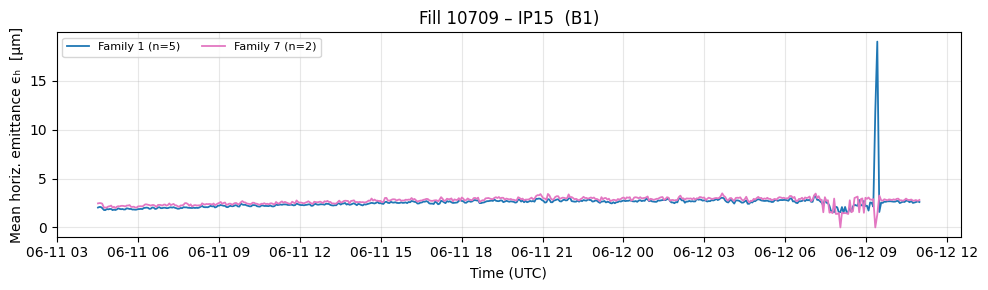

n      mean       std
Family                         
Family 1  5  2.507051  1.947304
Family 7  2  2.692086  0.479123

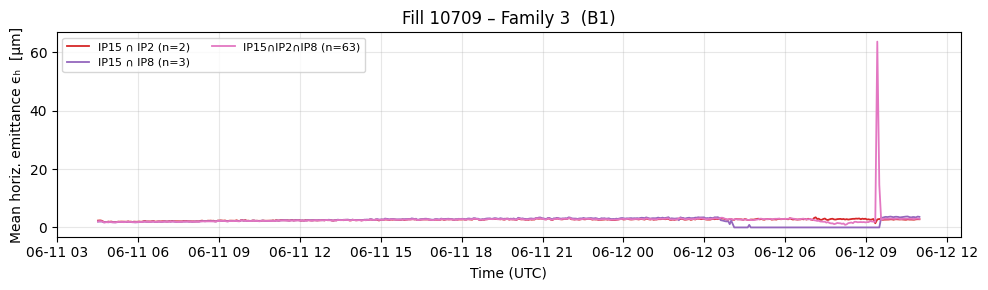

n      mean       std
IP class     Family                          
IP15 ∩ IP2   Family 3   2  2.599407  0.312516
IP15 ∩ IP8   Family 3   3  2.237219  1.144229
IP15∩IP2∩IP8 Family 3  63  2.659050  8.166789

In [55]:

fno   = 10709
beam  = "B1"
emit_H_var = f"LHC.BSRT.5R4.{beam}:BUNCH_EMITTANCE_H"
fbmodes = pd.read_parquet(FILLINFO / "fills_and_bmodes_2025.parquet")
rowST   = (fbmodes.loc[fno]
                    .query("BMODE=='STABLE'")
                    .sort_values("tsStart"))
if rowST.empty:
    rowST = fbmodes.loc[fno].sort_values("tsEnd").iloc[[-1]]

t_start = pd.to_datetime(rowST["tsStart"].iloc[0], utc=True)
t_end   = pd.to_datetime(rowST["tsEnd"].iloc[0],   utc=True)

ser = (pd.read_parquet(RAWPATH / f"HX:FILLN={fno}",
                       columns=[emit_H_var])[emit_H_var])

ser.index = (pd.to_datetime(ser.index, utc=True, errors="coerce")
               .sort_values())
ser = ser[(ser.index >= t_start) & (ser.index <= t_end)].dropna()
if ser.empty:
    raise RuntimeError("no horizontal-emittance data in STABLE window")

M           = np.stack(ser.values)  
palette     = plt.cm.get_cmap("tab10").colors

def a(x): return np.asarray(x, int)
IP_panels = {ip: [families[f][ip] for f in families] for ip in IP_keys}

big_rows = []
for ip, fam_arrays in IP_panels.items():
    for fam_lbl, slots in zip(family_labels, fam_arrays):
        if slots.size == 0: continue
        big_rows.append({
            "IP class": ip,
            "Family"  : fam_lbl,
            "n"       : len(slots),
            "mean"    : np.nanmean(M[:, slots]),
            "std"     : np.nanstd(M[:, slots]),
        })
stats_df = (pd.DataFrame(big_rows)
            .set_index(["IP class", "Family"])
            .sort_index())

# translation dicts
long_to_short = {k: v for k, v in zip(families.keys(), family_labels)}
short_to_long = {v: k for k, v in long_to_short.items()}

def plot_single(*, ip_class=None, family=None):
    """Zoom plot (horizontal emittance).  Choose exactly one argument."""
    if (ip_class is None) == (family is None):
        raise ValueError("Specify exactly one of ip_class or family")

    if ip_class is not None:                      # by IP
        curves = zip(family_labels, IP_panels[ip_class])
        title  = ip_class
        table  = stats_df.loc[ip_class]
    else:                                         # by Family
        fam_long  = short_to_long.get(family, family)
        if fam_long not in families:
            raise KeyError(f"Family '{family}' not found.")
        fam_short = long_to_short[fam_long]
        curves = families[fam_long].items()
        title  = fam_long
        table  = stats_df.xs(fam_short, level="Family", drop_level=False)

    plt.figure(figsize=(10,3))
    for i, (lbl, slots) in enumerate(curves):
        slots = np.asarray(slots, int)
        if slots.size == 0: continue
        y = np.nanmean(M[:, slots], axis=1)
        plt.plot(time_index, y,
                 label=f"{lbl} (n={len(slots)})",
                 color=palette[i % len(palette)], lw=1.3)
    plt.xlabel("Time (UTC)")
    plt.ylabel("Mean horiz. emittance ϵₕ  [µm]")
    plt.title(f"Fill {fno} – {title}  ({beam})")
    plt.grid(alpha=.3); plt.legend(ncol=2, fontsize=8)
    plt.tight_layout(); plt.show()
    display(table)
plot_single(ip_class="IP15")           # eight family curves
plot_single(family="Family 3")     # seven IP curves (long name)
# plot_single(family="Max")              # seven IP curves (short name)


## Emmitance V

### Mean Vertical Emmitance classified by bunch position

/tmp/ipykernel_3449522/2634199500.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap("tab10").colors


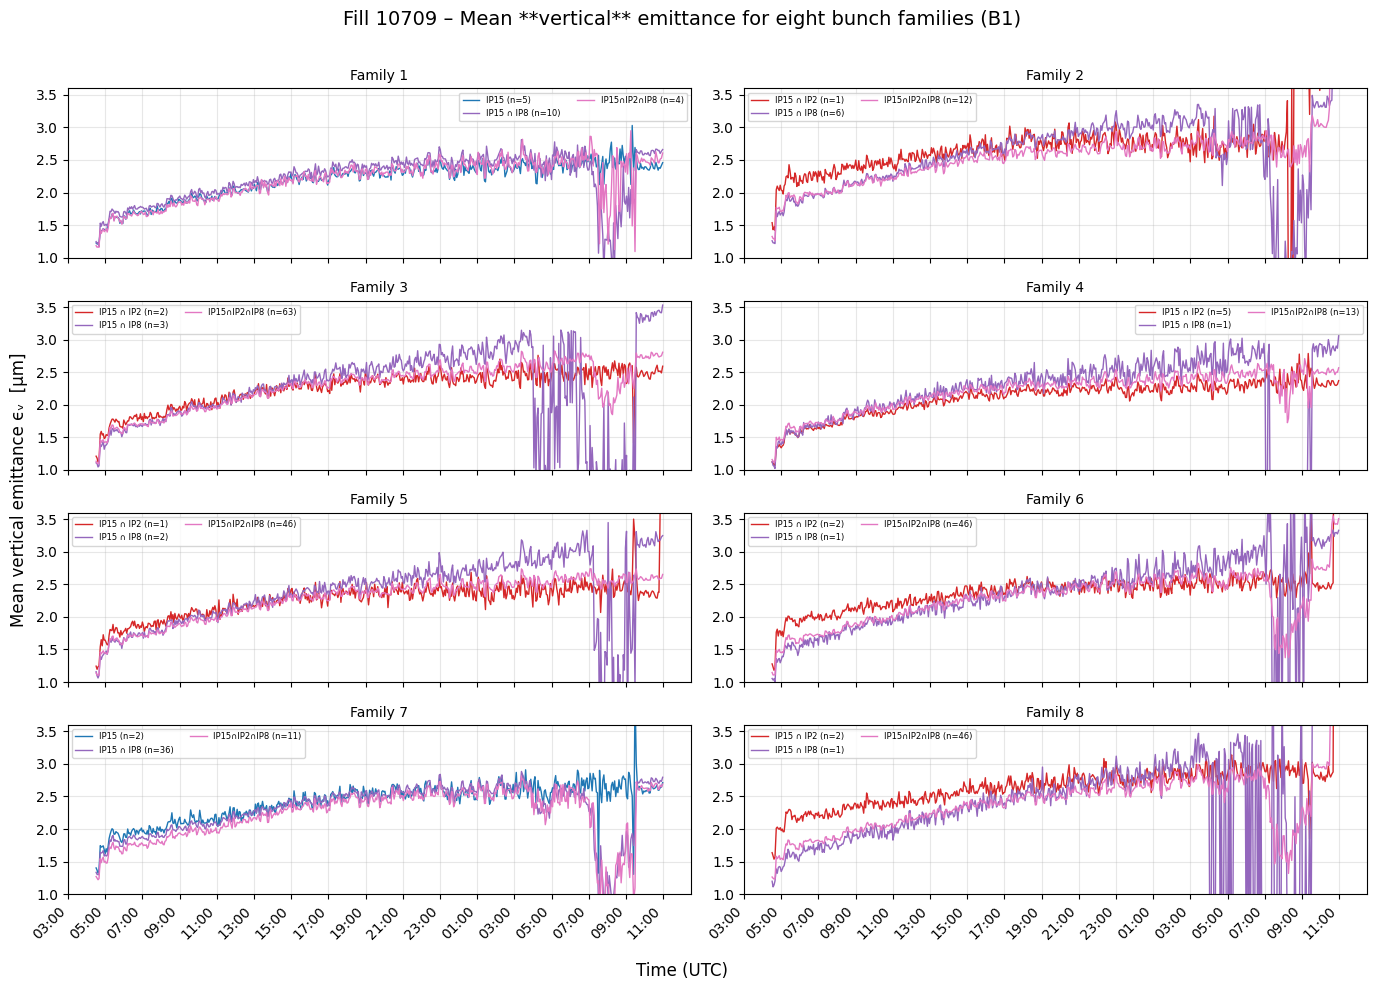

n      mean       std
Family   Group                               
Family 1 IP15           5  2.182126  0.288030
         IP15 ∩ IP8    10  2.216101  0.358820
         IP15∩IP2∩IP8   4  2.177560  0.332098
Family 2 IP15 ∩ IP2     1  2.729163  0.649739
         IP15 ∩ IP8     6  2.567301  0.633685
         IP15∩IP2∩IP8  12  2.560834  0.606298
Family 3 IP15 ∩ IP2     2  2.255930  0.276937
         IP15 ∩ IP8     3  2.202779  0.717590
         IP15∩IP2∩IP8  63  2.277200  0.353211
Family 4 IP15 ∩ IP2     5  2.102824  0.266052
         IP15 ∩ IP8     1  2.144183  0.697901
         IP15∩IP2∩IP8  13  2.202203  0.287279
Family 5 IP15 ∩ IP2     1  2.263925  0.271478
         IP15 ∩ IP8     2  2.352969  0.575697
         IP15∩IP2∩IP8  46  2.272703  0.326544
Family 6 IP15 ∩ IP2     2  2.390091  0.415044
         IP15 ∩ IP8     1  2.333756  0.605197
         IP15∩IP2∩IP8  46  2.262393  0.380778
Family 7 IP15           2  2.405624  0.294849
         IP15 ∩ IP8    36  2.295454  0.390388
         IP15∩IP2∩IP8  11  2.214126  0.413674
Family 8 IP15 ∩ IP2     2  2.660801  0.481611
         IP15 ∩ IP8     1  2.260622  0.918100
         IP15∩IP2∩IP8  46  2.379292  0.446885

In [56]:

fno   = 10709
beam  = "B1"
emit_V_var = f"LHC.BSRT.5R4.{beam}:BUNCH_EMITTANCE_V"   # ⬅️ vertical

DATADIR  = Path("/eos/project/l/lhc-lumimod/LuminosityFollowUp/2025/")
RAWPATH  = DATADIR / "rawdata"
FILLINFO = DATADIR / "fills-info"

fbmodes = pd.read_parquet(FILLINFO / "fills_and_bmodes_2025.parquet")
row_ST  = (fbmodes.loc[fno]
                     .query("BMODE == 'STABLE'")
                     .sort_values("tsStart"))
if row_ST.empty:
    row_ST = fbmodes.loc[fno].sort_values("tsEnd").iloc[[-1]]

t_start = pd.to_datetime(row_ST["tsStart"].iloc[0], utc=True)
t_end   = pd.to_datetime(row_ST["tsEnd"].iloc[0],   utc=True)


ser = (pd.read_parquet(RAWPATH / f"HX:FILLN={fno}",
                       columns=[emit_V_var])[emit_V_var])
ser.index = pd.to_datetime(ser.index, utc=True, errors="coerce").sort_values()
ser = ser[(ser.index >= t_start) & (ser.index <= t_end)].dropna()
if ser.empty:
    raise RuntimeError("No non-NaN vertical-emittance samples in STABLE window.")

M = np.stack(ser.values)          # nTimes × 3564
time_index = ser.index

def to_arr(x): return np.asarray(x, int)
def mean_curve(slots): return None if slots.size==0 else np.nanmean(M[:, slots],1)
palette = plt.cm.get_cmap("tab10").colors
fig, axes = plt.subplots(4, 2, figsize=(14, 10), sharex=True)
axes = axes.flatten()
all_stats = []

for ax, (fam_name, fam_groups) in zip(axes, families.items()):
    for i, (clabel, slots) in enumerate(fam_groups.items()):
        curve = mean_curve(slots)
        if curve is None: continue
        ax.plot(time_index, curve,
                label=f"{clabel} (n={len(slots)})",
                color=palette[i % len(palette)], lw=1)

        all_stats.append({
            "Family": fam_name,
            "Group" : clabel,
            "n"     : len(slots),
            "mean"  : np.nanmean(curve),
            "std"   : np.nanstd(curve),
        })
    ax.set_title(fam_name, fontsize=10)
    ax.grid(alpha=.3)
    ax.set_ylim(1,3.6)
    ax.legend(fontsize=6, ncol=2)
# ── format x-axis ─────────────────────────────────────────────────────────
for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
for ax in axes[-2:]:
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

fig.suptitle(f"Fill {fno} – Mean **vertical** emittance for eight bunch families ({beam})",
             fontsize=14)
fig.supxlabel("Time (UTC)")
fig.supylabel("Mean vertical emittance ϵᵥ  [µm]")
fig.tight_layout(rect=[0,0,1,0.97])
plt.show()

# ─────────────────────────────────────────────────────────────
# 6. statistics table
# ─────────────────────────────────────────────────────────────
stats_df = (pd.DataFrame(all_stats)
            .set_index(["Family", "Group"])
            .sort_index())
display(stats_df)


Normalizing to closest sample at: 2025-06-11 05:41:14.015000+00:00


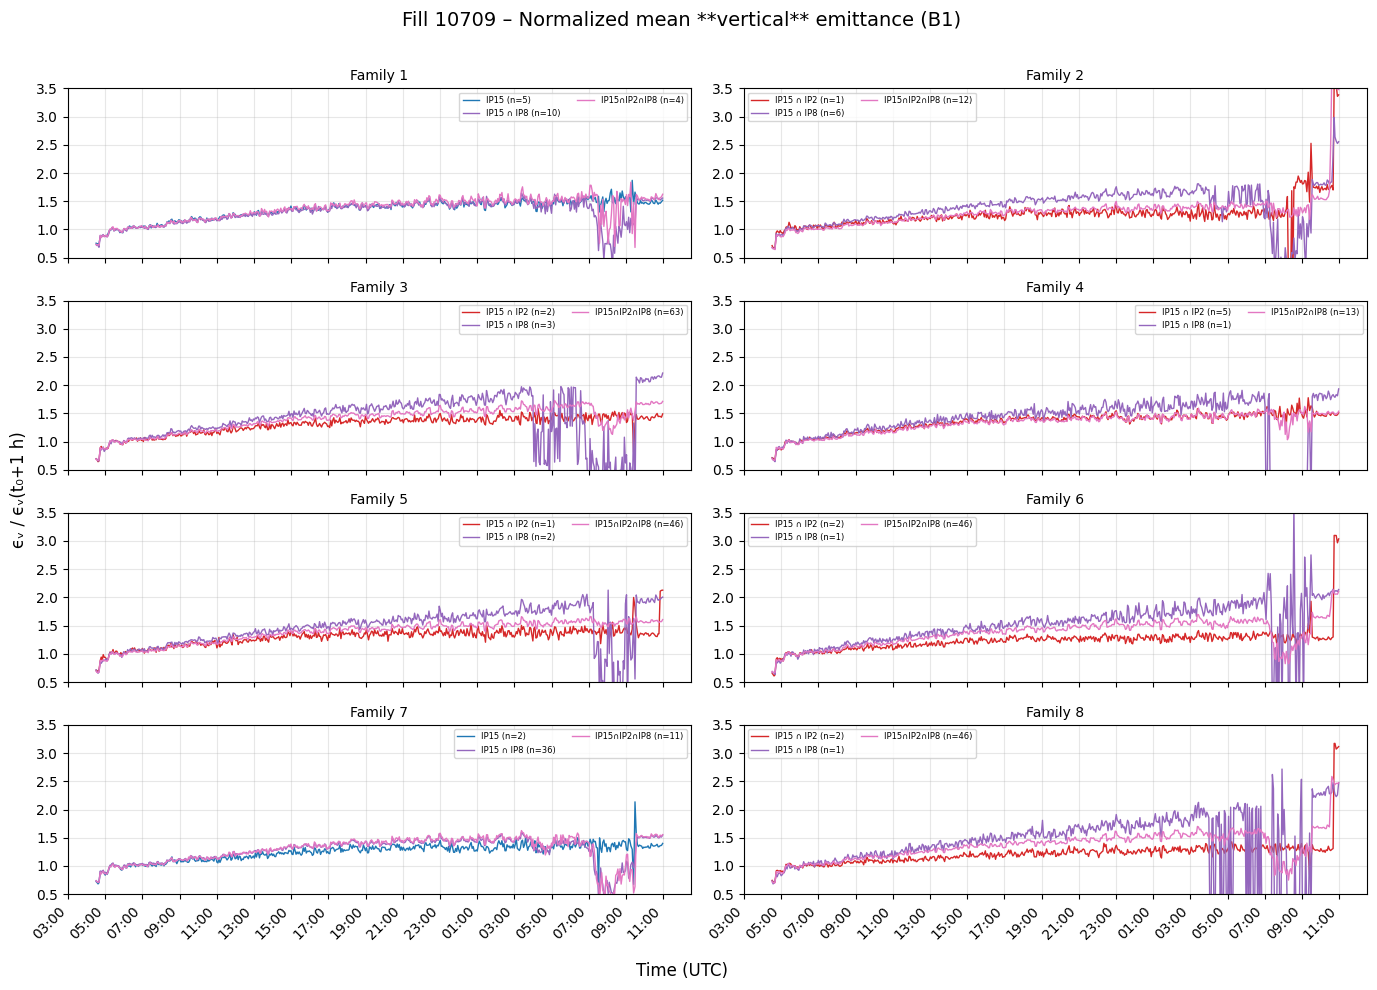

n  mean_norm  std_norm   ref_val
Family   Group                                          
Family 1 IP15           5   1.346825  0.177775  1.620200
         IP15 ∩ IP8    10   1.296608  0.209940  1.709153
         IP15∩IP2∩IP8   4   1.356310  0.206850  1.605504
Family 2 IP15 ∩ IP2     1   1.266713  0.301570  2.154523
         IP15 ∩ IP8     6   1.384773  0.341803  1.853950
         IP15∩IP2∩IP8  12   1.303157  0.308533  1.965101
Family 3 IP15 ∩ IP2     2   1.297755  0.159312  1.738334
         IP15 ∩ IP8     3   1.381984  0.450203  1.593925
         IP15∩IP2∩IP8  63   1.390516  0.215680  1.637665
Family 4 IP15 ∩ IP2     5   1.341279  0.169701  1.567775
         IP15 ∩ IP8     1   1.354430  0.440847  1.583089
         IP15∩IP2∩IP8  13   1.320065  0.172203  1.668254
Family 5 IP15 ∩ IP2     1   1.291777  0.154903  1.752567
         IP15 ∩ IP8     2   1.452014  0.355262  1.620487
         IP15∩IP2∩IP8  46   1.376296  0.197748  1.651319
Family 6 IP15 ∩ IP2     2   1.229254  0.213462  1.944344
         IP15 ∩ IP8     1   1.499145  0.388763  1.556725
         IP15∩IP2∩IP8  46   1.358648  0.228671  1.665180
Family 7 IP15           2   1.241364  0.152149  1.937888
         IP15 ∩ IP8    36   1.271121  0.216180  1.805850
         IP15∩IP2∩IP8  11   1.279810  0.239112  1.730042
Family 8 IP15 ∩ IP2     2   1.210161  0.219042  2.198717
         IP15 ∩ IP8     1   1.385308  0.562611  1.631855
         IP15∩IP2∩IP8  46   1.352845  0.254095  1.758732

In [57]:
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# ── compute reference at t_start + 1 h ───────────────────────────────────
ref_time = t_start + pd.Timedelta(hours=1, minutes = 10)
ref_idx  = (np.abs(time_index - ref_time)).argmin()
print("Normalizing to closest sample at:", time_index[ref_idx])

# ── prepare figure ──────────────────────────────────────────────────────
fig, axes = plt.subplots(4, 2, figsize=(14, 10), sharex=True)
axes = axes.flatten()
all_stats = []

# ── plot & normalize ─────────────────────────────────────────────────────
for ax, (fam_name, fam_groups) in zip(axes, families.items()):
    for i, (clabel, slots) in enumerate(fam_groups.items()):
        curve = mean_curve(slots)               # family‐mean over time
        if curve is None:
            continue

        # get the family‐mean at +1 h
        ref_val = curve[ref_idx]
        if not np.isfinite(ref_val) or ref_val == 0:
            continue

        norm_curve = curve / ref_val           # now norm_curve[ref_idx] == 1.0

        ax.plot(time_index, norm_curve,
                label=f"{clabel} (n={len(slots)})",
                color=palette[i % len(palette)], lw=1)

        all_stats.append({
            "Family":    fam_name,
            "Group":     clabel,
            "n":         len(slots),
            "mean_norm": np.nanmean(norm_curve),
            "std_norm":  np.nanstd(norm_curve),
            "ref_val":   ref_val,
        })

    ax.set_title(fam_name, fontsize=10)
    ax.set_ylim(0.5, 3.5)     # adjust as needed for your data
    ax.grid(alpha=0.3)
    ax.legend(fontsize=6, ncol=2)

# ── format x-axis ─────────────────────────────────────────────────────────
for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
for ax in axes[-2:]:
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# ── final touches ─────────────────────────────────────────────────────────
fig.suptitle(
    f"Fill {fno} – Normalized mean **vertical** emittance ({beam})",
    fontsize=14
)
fig.supxlabel("Time (UTC)")
fig.supylabel("ϵᵥ / ϵᵥ(t₀+1 h)")
fig.tight_layout(rect=[0,0,1,0.97])
plt.show()

# ── stats table ───────────────────────────────────────────────────────────
stats_df = (
    pd.DataFrame(all_stats)
      .set_index(["Family", "Group"])
      .sort_index()
)
display(stats_df)


### Mean Verical Emmitance classified by IP position 

/tmp/ipykernel_3449522/1410496656.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap("tab10").colors


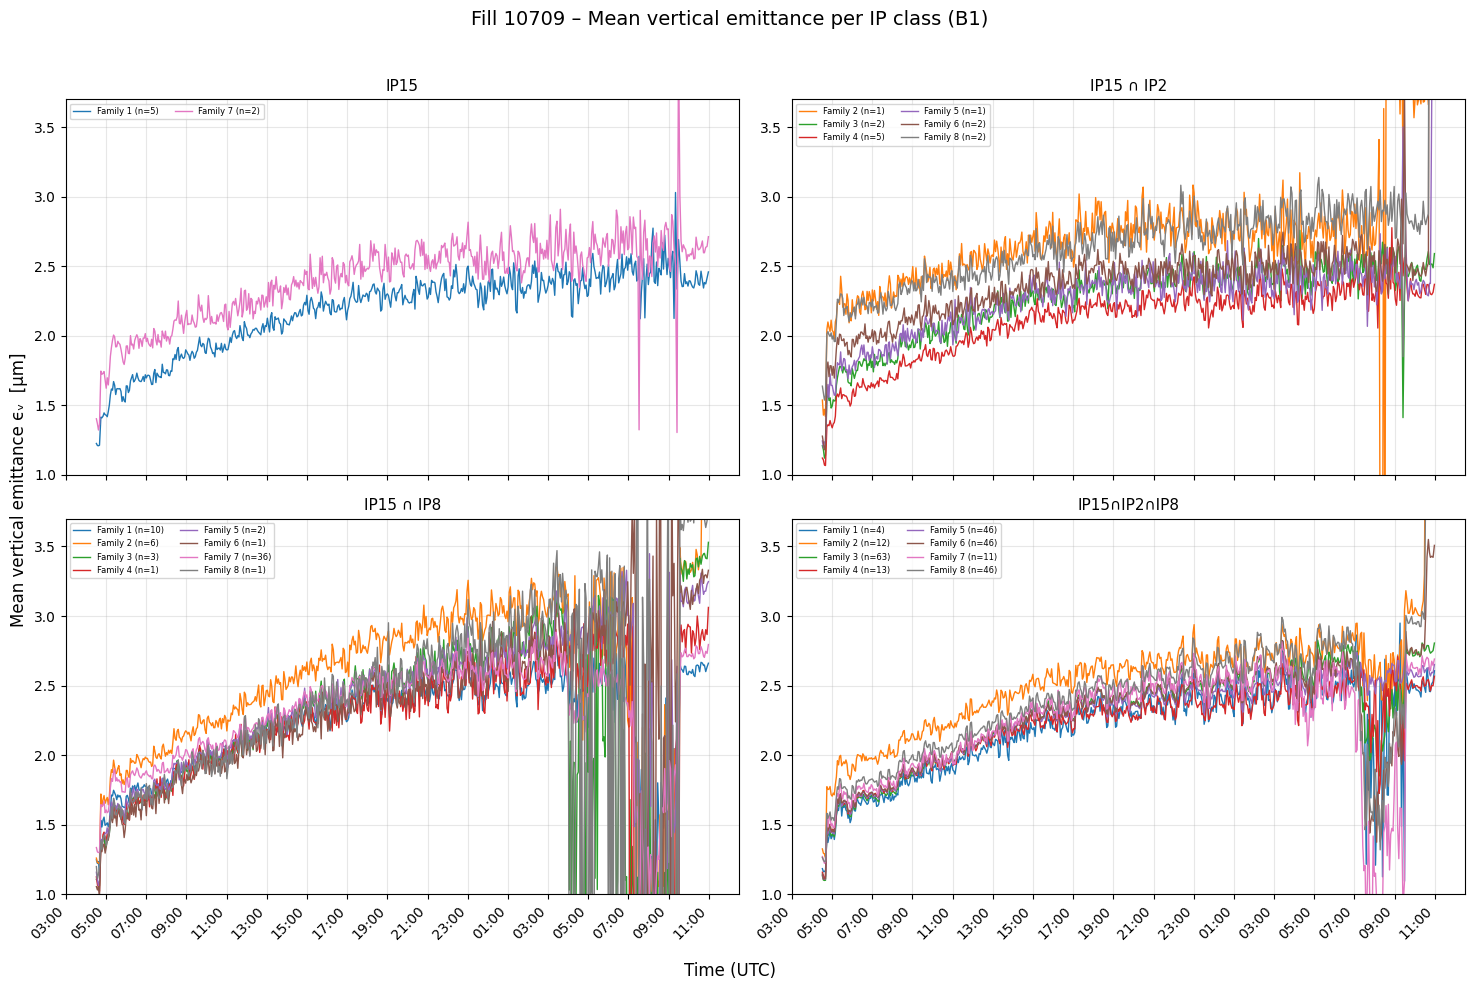

n      mean       std
IP class     Family                          
IP15         Family 1   5  2.182126  0.288030
             Family 7   2  2.405624  0.294849
IP15 ∩ IP2   Family 2   1  2.729163  0.649739
             Family 3   2  2.255930  0.276937
             Family 4   5  2.102824  0.266052
             Family 5   1  2.263925  0.271478
             Family 6   2  2.390091  0.415044
             Family 8   2  2.660801  0.481611
IP15 ∩ IP8   Family 1  10  2.216101  0.358820
             Family 2   6  2.567301  0.633685
             Family 3   3  2.202779  0.717590
             Family 4   1  2.144183  0.697901
             Family 5   2  2.352969  0.575697
             Family 6   1  2.333756  0.605197
             Family 7  36  2.295454  0.390388
             Family 8   1  2.260622  0.918100
IP15∩IP2∩IP8 Family 1   4  2.177560  0.332098
             Family 2  12  2.560834  0.606298
             Family 3  63  2.277200  0.353211
             Family 4  13  2.202203  0.287279
             Family 5  46  2.272703  0.326544
             Family 6  46  2.262393  0.380778
             Family 7  11  2.214126  0.413674
             Family 8  46  2.379292  0.446885

In [58]:
def mean_curve(slots):
    return None if slots.size == 0 else np.nanmean(M[:, slots], axis=1)

palette = plt.cm.get_cmap("tab10").colors

# ensure numpy arrays
IP_panels = {
    ip: [np.asarray(a, int) for a in arrs]
    for ip, arrs in IP_panels.items()
}
# drop any empty panels
clean_panels = {
    ip: arrs
    for ip, arrs in IP_panels.items()
    if any(arr.size for arr in arrs)
}

# take only the first 4 IP classes
ip_items = list(clean_panels.items())[:4]

# set up a 2×2 grid
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True)
axes = axes.flatten()
stats_rows = []

for ax, (ip_lbl, fam_arrays) in zip(axes, ip_items):
    for i, (fam_lbl, slots) in enumerate(zip(family_labels, fam_arrays)):
        curve = mean_curve(slots)
        if curve is None:
            continue
        ax.plot(time_index, curve,
                label=f"{fam_lbl} (n={len(slots)})",
                color=palette[i], lw=1)
        stats_rows.append({
            "IP class": ip_lbl,
            "Family"  : fam_lbl,
            "n"       : len(slots),
            "mean"    : np.nanmean(curve),
            "std"     : np.nanstd(curve),
        })
    ax.set_title(ip_lbl, fontsize=11)
    ax.grid(alpha=.3)
    ax.set_ylim(1,3.7)
    ax.legend(fontsize=6, ncol=2)
for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
for ax in axes[-2:]:
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
# remove any unused axes
for ax in axes[len(ip_items):]:
    fig.delaxes(ax)

fig.suptitle(f"Fill {fno} – Mean vertical emittance per IP class ({beam})",
             fontsize=14)
fig.supxlabel("Time (UTC)")
fig.supylabel("Mean vertical emittance ϵᵥ  [µm]")
fig.tight_layout(rect=[0,0,1,0.96])
plt.show()

# stats table
stats_df = pd.DataFrame(stats_rows).set_index(["IP class", "Family"]).sort_index()
display(stats_df)

Normalizing to closest sample at: 2025-06-11 05:41:14.015000+00:00


/tmp/ipykernel_3449522/1609914236.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap("tab10").colors


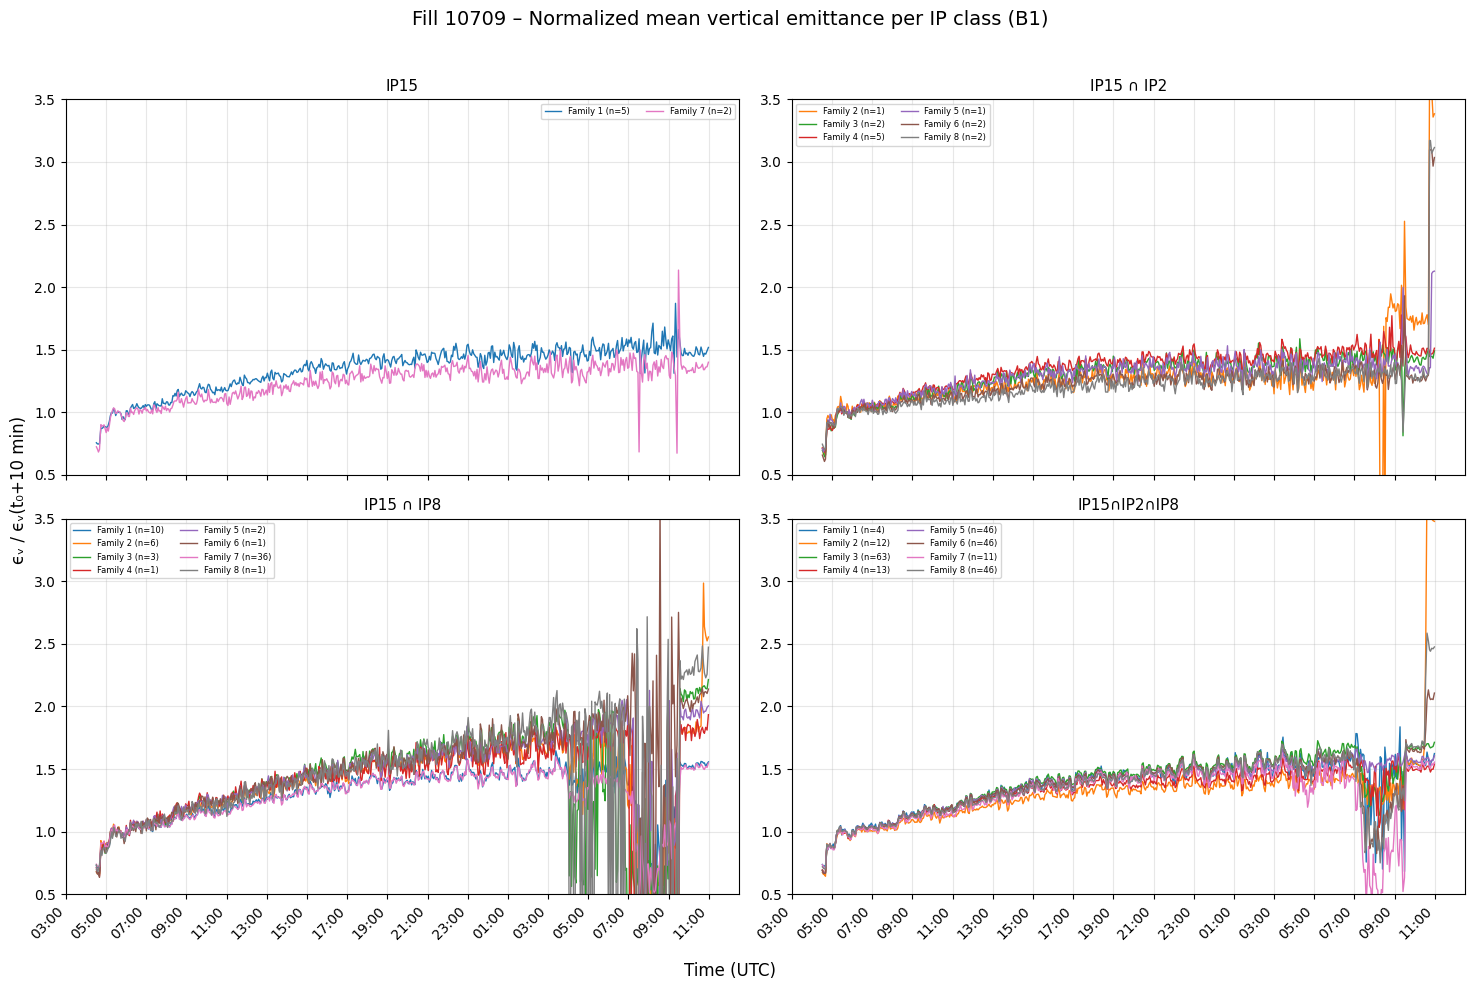

n  mean_norm  std_norm   ref_val
IP class     Family                                     
IP15         Family 1   5   1.346825  0.177775  1.620200
             Family 7   2   1.241364  0.152149  1.937888
IP15 ∩ IP2   Family 2   1   1.266713  0.301570  2.154523
             Family 3   2   1.297755  0.159312  1.738334
             Family 4   5   1.341279  0.169701  1.567775
             Family 5   1   1.291777  0.154903  1.752567
             Family 6   2   1.229254  0.213462  1.944344
             Family 8   2   1.210161  0.219042  2.198717
IP15 ∩ IP8   Family 1  10   1.296608  0.209940  1.709153
             Family 2   6   1.384773  0.341803  1.853950
             Family 3   3   1.381984  0.450203  1.593925
             Family 4   1   1.354430  0.440847  1.583089
             Family 5   2   1.452014  0.355262  1.620487
             Family 6   1   1.499145  0.388763  1.556725
             Family 7  36   1.271121  0.216180  1.805850
             Family 8   1   1.385308  0.562611  1.631855
IP15∩IP2∩IP8 Family 1   4   1.356310  0.206850  1.605504
             Family 2  12   1.303157  0.308533  1.965101
             Family 3  63   1.390516  0.215680  1.637665
             Family 4  13   1.320065  0.172203  1.668254
             Family 5  46   1.376296  0.197748  1.651319
             Family 6  46   1.358648  0.228671  1.665180
             Family 7  11   1.279810  0.239112  1.730042
             Family 8  46   1.352845  0.254095  1.758732

In [59]:
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# ── compute reference at t_start + 10 min ─────────────────────────────────
ref_time = t_start + pd.Timedelta(hours = 1,minutes=10)
ref_idx  = (np.abs(time_index - ref_time)).argmin()
print("Normalizing to closest sample at:", time_index[ref_idx])

# ── ensure numpy arrays and drop empty panels ─────────────────────────────
IP_panels = {
    ip: [np.asarray(a, int) for a in arrs]
    for ip, arrs in IP_panels.items()
}
clean_panels = {
    ip: arrs
    for ip, arrs in IP_panels.items()
    if any(arr.size for arr in arrs)
}
ip_items = list(clean_panels.items())[:4]   # first 4 IP classes

# ── set up a 2×2 grid ─────────────────────────────────────────────────────
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True)
axes = axes.flatten()
stats_rows = []

# ── helper unchanged ───────────────────────────────────────────────────────
def mean_curve(slots):
    return None if slots.size == 0 else np.nanmean(M[:, slots], axis=1)

palette = plt.cm.get_cmap("tab10").colors

# ── plot & normalize ─────────────────────────────────────────────────────
for ax, (ip_lbl, fam_arrays) in zip(axes, ip_items):
    for i, (fam_lbl, slots) in enumerate(zip(family_labels, fam_arrays)):
        curve = mean_curve(slots)
        if curve is None:
            continue

        ref_val = curve[ref_idx]
        if not np.isfinite(ref_val) or ref_val == 0:
            continue

        norm_curve = curve / ref_val  # now ==1.0 at ~10 min

        ax.plot(time_index, norm_curve,
                label=f"{fam_lbl} (n={len(slots)})",
                color=palette[i], lw=1)

        stats_rows.append({
            "IP class":  ip_lbl,
            "Family":    fam_lbl,
            "n":         len(slots),
            "mean_norm": np.nanmean(norm_curve),
            "std_norm":  np.nanstd(norm_curve),
            "ref_val":   ref_val,
        })

    ax.set_title(ip_lbl, fontsize=11)
    ax.set_ylim(0.5, 3.5)    # relative scale around 1.0
    ax.grid(alpha=0.3)
    ax.legend(fontsize=6, ncol=2)

# ── format x-axis ─────────────────────────────────────────────────────────
for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
for ax in axes[-2:]:
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# ── remove any unused axes ─────────────────────────────────────────────────
for ax in axes[len(ip_items):]:
    fig.delaxes(ax)

# ── final layout ──────────────────────────────────────────────────────────
fig.suptitle(
    f"Fill {fno} – Normalized mean vertical emittance per IP class ({beam})",
    fontsize=14
)
fig.supxlabel("Time (UTC)")
fig.supylabel("ϵᵥ / ϵᵥ(t₀+10 min)")
fig.tight_layout(rect=[0,0,1,0.96])
plt.show()

# ── stats table ───────────────────────────────────────────────────────────
stats_df = (
    pd.DataFrame(stats_rows)
      .set_index(["IP class", "Family"])
      .sort_index()
)
display(stats_df)


### Choose graph for better visibility

/tmp/ipykernel_3449522/2727781122.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette    = plt.cm.get_cmap("tab10").colors


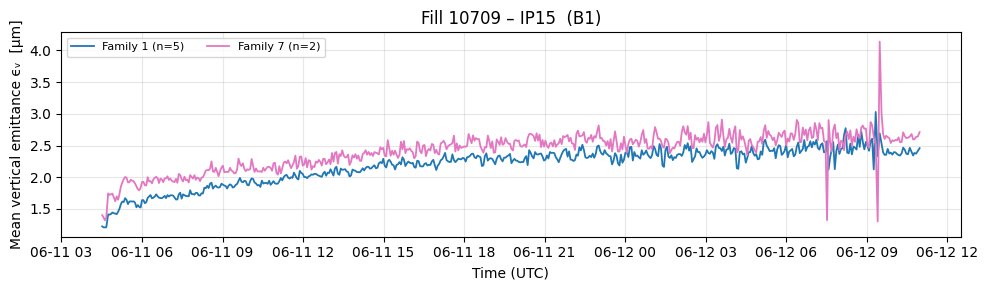

n      mean       std
Family                         
Family 1  5  2.182126  0.315041
Family 7  2  2.405624  0.311884

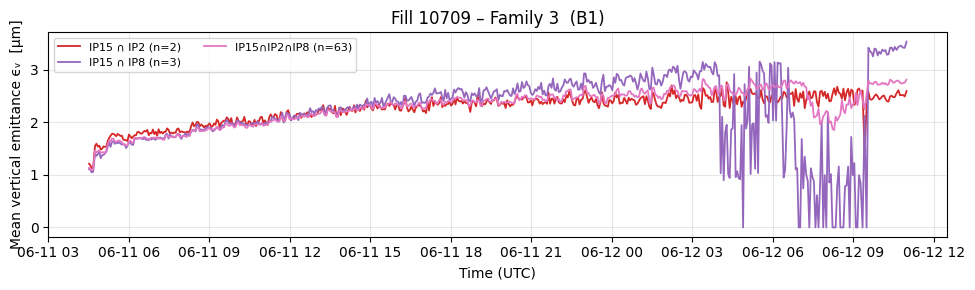

n      mean       std
IP class     Family                          
IP15 ∩ IP2   Family 3   2  2.255930  0.290635
IP15 ∩ IP8   Family 3   3  2.202779  0.861811
IP15∩IP2∩IP8 Family 3  63  2.277200  0.466526

In [60]:

fno   = 10709
beam  = "B1"
emit_V_var = f"LHC.BSRT.5R4.{beam}:BUNCH_EMITTANCE_V"   

DATADIR  = Path("/eos/project/l/lhc-lumimod/LuminosityFollowUp/2025/")
RAWPATH  = DATADIR / "rawdata"
FILLINFO = DATADIR / "fills-info"


fbmodes = pd.read_parquet(FILLINFO / "fills_and_bmodes_2025.parquet")
rowST   = (fbmodes.loc[fno]
                    .query("BMODE=='STABLE'")
                    .sort_values("tsStart"))
if rowST.empty:
    rowST = fbmodes.loc[fno].sort_values("tsEnd").iloc[[-1]]

t_start = pd.to_datetime(rowST["tsStart"].iloc[0], utc=True)
t_end   = pd.to_datetime(rowST["tsEnd"].iloc[0],   utc=True)


ser = (pd.read_parquet(RAWPATH / f"HX:FILLN={fno}",
                       columns=[emit_V_var])[emit_V_var])
ser.index = pd.to_datetime(ser.index, utc=True, errors="coerce").sort_values()
ser = ser[(ser.index >= t_start) & (ser.index <= t_end)].dropna()
if ser.empty:
    raise RuntimeError("no vertical-emittance data in STABLE window")

M          = np.stack(ser.values)       
time_index = ser.index
palette    = plt.cm.get_cmap("tab10").colors


def a(x): return np.asarray(x, int)
def mean_curve(slots):
    return None if slots.size == 0 else np.nanmean(M[:, slots], axis=1)
IP_panels = {ip: [families[f][ip] for f in families] for ip in IP_keys}


big_rows = []
for ip, fam_arrays in IP_panels.items():
    for fam_lbl, slots in zip(family_labels, fam_arrays):
        if slots.size == 0: continue
        big_rows.append({
            "IP class": ip,
            "Family"  : fam_lbl,
            "n"       : len(slots),
            "mean"    : np.nanmean(M[:, slots]),
            "std"     : np.nanstd(M[:, slots]),
        })
stats_df = (pd.DataFrame(big_rows)
            .set_index(["IP class", "Family"])
            .sort_index())


long_to_short = {k: v for k, v in zip(families.keys(), family_labels)}
short_to_long = {v: k for k, v in long_to_short.items()}


def plot_single(*, ip_class=None, family=None):
    """Zoom plot (vertical emittance).  Choose exactly ONE argument."""
    if (ip_class is None) == (family is None):
        raise ValueError("Specify exactly one of ip_class or family")

    if ip_class is not None:                         # by IP class
        curves = zip(family_labels, IP_panels[ip_class])
        title  = ip_class
        table  = stats_df.loc[ip_class]
    else:                                            # by Family
        fam_long  = short_to_long.get(family, family)
        if fam_long not in families:
            raise KeyError(f"Family '{family}' not found.")
        fam_short = long_to_short[fam_long]
        curves = families[fam_long].items()
        title  = fam_long
        table  = stats_df.xs(fam_short, level="Family", drop_level=False)

    plt.figure(figsize=(10,3))
    for i, (lbl, slots) in enumerate(curves):
        slots = np.asarray(slots, int)
        if slots.size == 0: continue
        y = np.nanmean(M[:, slots], axis=1)
        plt.plot(time_index, y,
                 label=f"{lbl} (n={len(slots)})",
                 color=palette[i % len(palette)], lw=1.3)

    plt.xlabel("Time (UTC)")
    plt.ylabel("Mean vertical emittance ϵᵥ  [µm]")
    plt.title(f"Fill {fno} – {title}  ({beam})")
    plt.grid(alpha=.3); plt.legend(ncol=2, fontsize=8)
    plt.tight_layout(); plt.show()
    display(table)

plot_single(ip_class="IP15")          # eight families for IP15
plot_single(family="Family 3")    # seven IP curves for that family
# plot_single(family="Max")           # equivalent short name


## Luminosity for ATLAS


/tmp/ipykernel_3449522/3829929894.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  atlas_palette    = plt.cm.get_cmap("tab10").colors


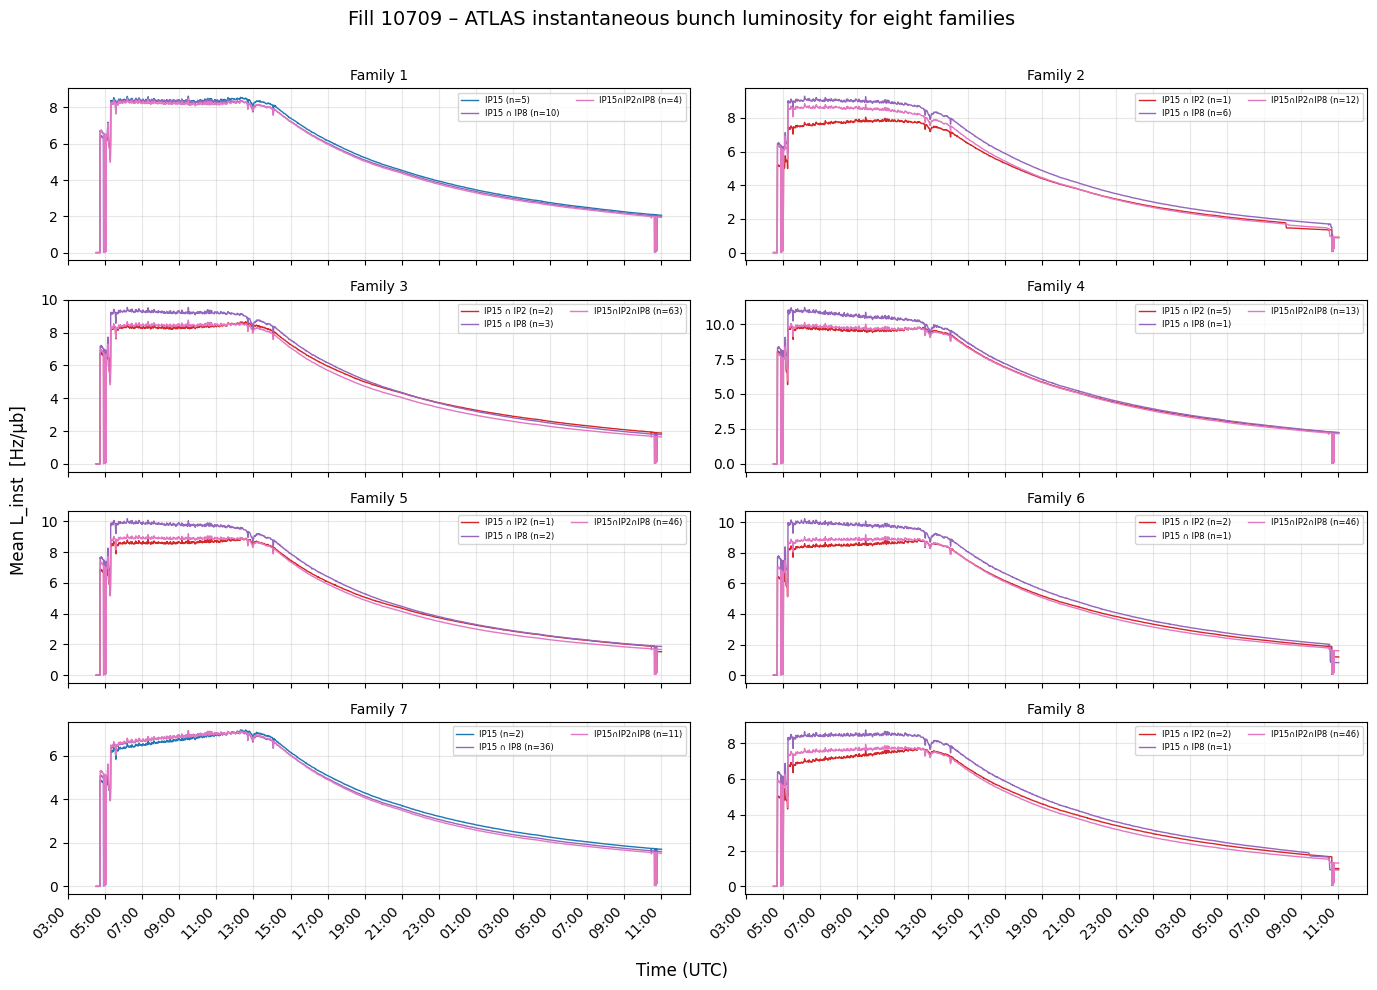

n      mean       std
Family   Group                               
Family 1 IP15           5  5.176699  2.551162
         IP15 ∩ IP8    10  5.082108  2.536154
         IP15∩IP2∩IP8   4  5.028492  2.530793
Family 2 IP15 ∩ IP2     1  4.436965  2.480583
         IP15 ∩ IP8     6  5.041430  2.886147
         IP15∩IP2∩IP8  12  4.697769  2.795715
Family 3 IP15 ∩ IP2     2  5.054366  2.596012
         IP15 ∩ IP8     3  5.289004  2.941424
         IP15∩IP2∩IP8  63  4.894543  2.714517
Family 4 IP15 ∩ IP2     5  5.859152  2.962004
         IP15 ∩ IP8     1  6.197955  3.294362
         IP15∩IP2∩IP8  13  5.843097  3.016792
Family 5 IP15 ∩ IP2     1  5.140325  2.730360
         IP15 ∩ IP8     2  5.543740  3.134913
         IP15∩IP2∩IP8  46  5.086243  2.883234
Family 6 IP15 ∩ IP2     2  5.130797  2.689588
         IP15 ∩ IP8     1  5.670283  3.129995
         IP15∩IP2∩IP8  46  5.151855  2.836462
Family 7 IP15           2  4.201776  2.049454
         IP15 ∩ IP8    36  4.145077  2.114347
         IP15∩IP2∩IP8  11  4.106431  2.153493
Family 8 IP15 ∩ IP2     2  4.445636  2.283797
         IP15 ∩ IP8     1  4.935406  2.678685
         IP15∩IP2∩IP8  46  4.445298  2.440727

In [61]:
fno            = 10709
atlas_lumi_var = "ATLAS:BUNCH_LUMI_INST"
DATADIR        = Path("/eos/project/l/lhc-lumimod/LuminosityFollowUp/2025/")
RAWPATH        = DATADIR / "rawdata"
FILLINFO       = DATADIR / "fills-info"

fbmodes = pd.read_parquet(FILLINFO / "fills_and_bmodes_2025.parquet")
rowST   = (fbmodes.loc[fno]
             .query("BMODE=='STABLE'")
             .sort_values("tsStart"))
if rowST.empty:
    rowST = fbmodes.loc[fno].sort_values("tsEnd").iloc[[-1]]

t_start_atlas = pd.to_datetime(rowST["tsStart"].iloc[0], utc=True)
t_end_atlas   = pd.to_datetime(rowST["tsEnd"].iloc[0],   utc=True)

ser_atlas = pd.read_parquet(
    RAWPATH / f"HX:FILLN={fno}", columns=[atlas_lumi_var]
)[atlas_lumi_var]
ser_atlas.index = (
    pd.to_datetime(ser_atlas.index, utc=True, errors="coerce")
      .sort_values()
)
ser_atlas = ser_atlas[
    (ser_atlas.index >= t_start_atlas) &
    (ser_atlas.index <= t_end_atlas)
].dropna()
if ser_atlas.empty:
    raise RuntimeError("No ATLAS per-bunch lumi samples in STABLE window.")

M_atlas          = np.stack(ser_atlas.values)   # shape: (nTimes, 3564)
time_index_atlas = ser_atlas.index
atlas_palette    = plt.cm.get_cmap("tab10").colors

# 2. helper for ATLAS mean curves & labels
def mean_curve_atlas(slots):
    """Return mean over slots or None if empty."""
    slots = np.asarray(slots, int)
    if slots.size == 0:
        return None
    return np.nanmean(M_atlas[:, slots], axis=1)

family_labels = [
    "Head big gap", "Tail big gap", "Max",
    "7th", "15th", "27th",
    "Head gap 8", "Tail gap 8"
]

# 3. Plotting eight families for ATLAS
fig, axes = plt.subplots(4, 2, figsize=(14, 10), sharex=True)
axes = axes.flatten()
atlas_all_stats = []

for ax, (fam_name, fam_groups) in zip(axes, families.items()):
    for i, (grp_lbl, slots) in enumerate(fam_groups.items()):
        curve = mean_curve_atlas(slots)
        if curve is None:
            continue
        ax.plot(
            time_index_atlas, curve,
            label=f"{grp_lbl} (n={len(slots)})",
            color=atlas_palette[i % len(atlas_palette)],
            lw=1
        )
        atlas_all_stats.append({
            "Family": fam_name,
            "Group" : grp_lbl,
            "n"     : len(slots),
            "mean"  : np.nanmean(curve),
            "std"   : np.nanstd(curve),
        })

    ax.set_title(fam_name, fontsize=10)
    ax.grid(alpha=0.3)
    ax.legend(fontsize=6, ncol=2)
# ── format x-axis ─────────────────────────────────────────────────────────
for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
for ax in axes[-2:]:
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')


fig.suptitle(
    f"Fill {fno} – ATLAS instantaneous bunch luminosity for eight families",
    fontsize=14
)
fig.supxlabel("Time (UTC)")
fig.supylabel("Mean L_inst  [Hz/µb]")
fig.tight_layout(rect=[0,0,1,0.97])
plt.show()

# 4. ATLAS statistics table
stats_atlas_df = (
    pd.DataFrame(atlas_all_stats)
      .set_index(["Family", "Group"])
      .sort_index()
)
display(stats_atlas_df)


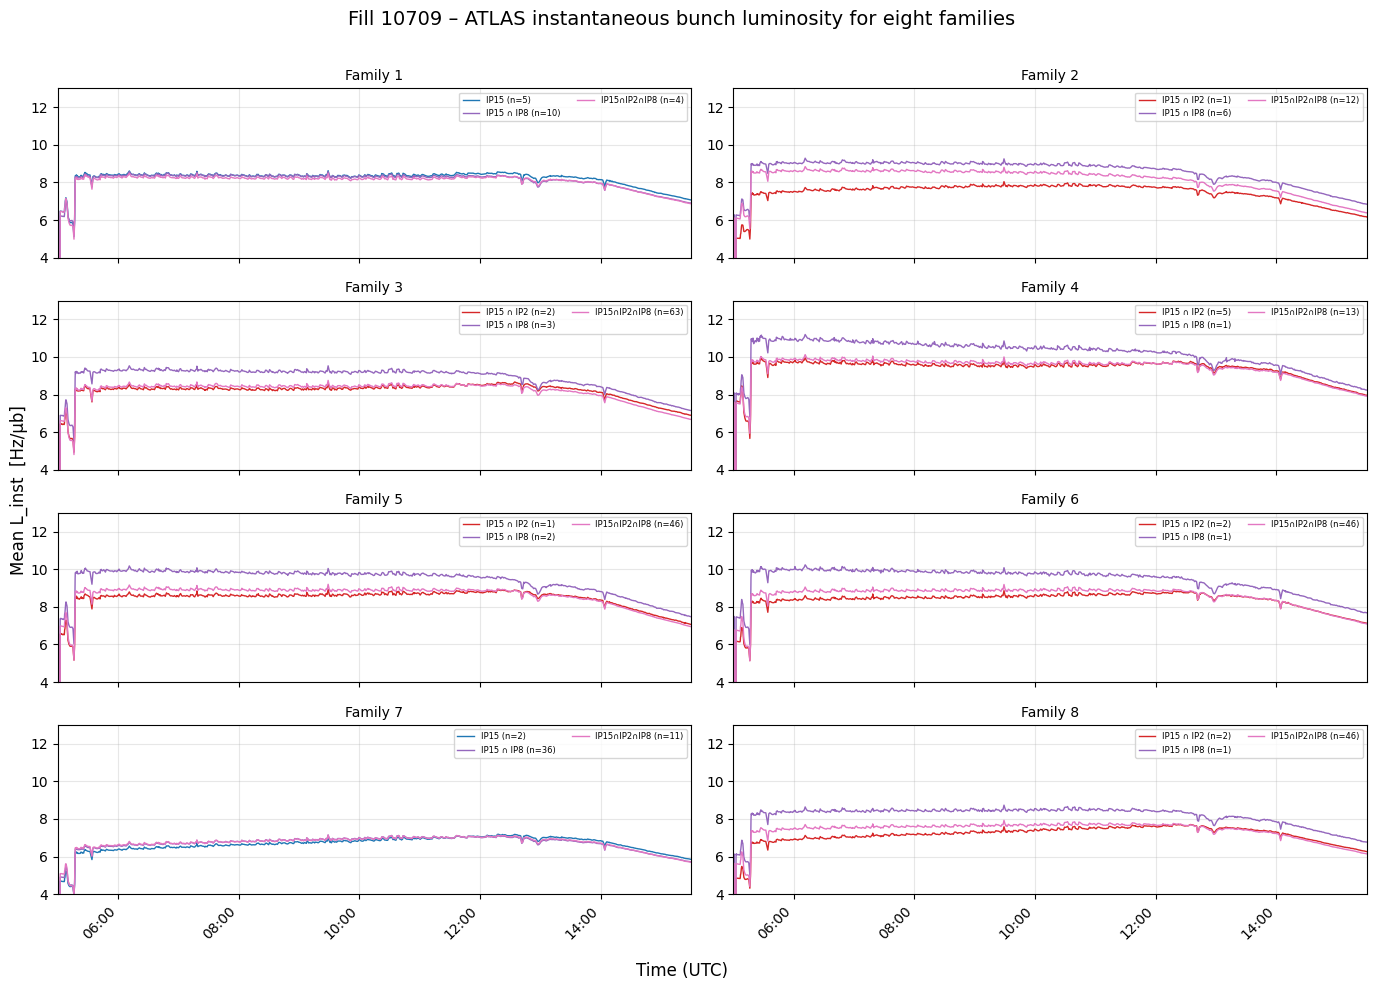

n      mean       std
Family   Group                               
Family 1 IP15           5  5.176699  2.551162
         IP15 ∩ IP8    10  5.082108  2.536154
         IP15∩IP2∩IP8   4  5.028492  2.530793
Family 2 IP15 ∩ IP2     1  4.436965  2.480583
         IP15 ∩ IP8     6  5.041430  2.886147
         IP15∩IP2∩IP8  12  4.697769  2.795715
Family 3 IP15 ∩ IP2     2  5.054366  2.596012
         IP15 ∩ IP8     3  5.289004  2.941424
         IP15∩IP2∩IP8  63  4.894543  2.714517
Family 4 IP15 ∩ IP2     5  5.859152  2.962004
         IP15 ∩ IP8     1  6.197955  3.294362
         IP15∩IP2∩IP8  13  5.843097  3.016792
Family 5 IP15 ∩ IP2     1  5.140325  2.730360
         IP15 ∩ IP8     2  5.543740  3.134913
         IP15∩IP2∩IP8  46  5.086243  2.883234
Family 6 IP15 ∩ IP2     2  5.130797  2.689588
         IP15 ∩ IP8     1  5.670283  3.129995
         IP15∩IP2∩IP8  46  5.151855  2.836462
Family 7 IP15           2  4.201776  2.049454
         IP15 ∩ IP8    36  4.145077  2.114347
         IP15∩IP2∩IP8  11  4.106431  2.153493
Family 8 IP15 ∩ IP2     2  4.445636  2.283797
         IP15 ∩ IP8     1  4.935406  2.678685
         IP15∩IP2∩IP8  46  4.445298  2.440727

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# … your code to load M_atlas, time_index_atlas, families, mean_curve_atlas, etc. …

# determine the date to use for 03:30 and 15:30
plot_date = time_index_atlas[0].date().isoformat()
xmin = pd.to_datetime(f"{plot_date} 05:00:00+00:00")
xmax = pd.to_datetime(f"{plot_date} 15:30:00+00:00")

fig, axes = plt.subplots(4, 2, figsize=(14, 10), sharex=True)
axes = axes.flatten()
atlas_all_stats = []

for ax, (fam_name, fam_groups) in zip(axes, families.items()):
    for i, (grp_lbl, slots) in enumerate(fam_groups.items()):
        curve = mean_curve_atlas(slots)
        if curve is None:
            continue

        ax.plot(
            time_index_atlas, curve,
            label=f"{grp_lbl} (n={len(slots)})",
            color=atlas_palette[i % len(atlas_palette)],
            lw=1
        )
        atlas_all_stats.append({
            "Family": fam_name,
            "Group" : grp_lbl,
            "n"     : len(slots),
            "mean"  : np.nanmean(curve),
            "std"   : np.nanstd(curve),
        })

    ax.set_title(fam_name, fontsize=10)
    ax.grid(alpha=0.3)
    ax.legend(fontsize=6, ncol=2)
    ax.set_ylim(4, 13)
    # ← set x‐limits here
    ax.set_xlim(xmin, xmax)

# ── format x-axis ─────────────────────────────────────────────────────────
for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
for ax in axes[-2:]:
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

fig.suptitle(
    f"Fill {fno} – ATLAS instantaneous bunch luminosity for eight families",
    fontsize=14
)
fig.supxlabel("Time (UTC)")
fig.supylabel("Mean L_inst  [Hz/µb]")
fig.tight_layout(rect=[0,0,1,0.97])
plt.show()

# 4. ATLAS statistics table
stats_atlas_df = (
    pd.DataFrame(atlas_all_stats)
      .set_index(["Family", "Group"])
      .sort_index()
)
display(stats_atlas_df)


In [81]:
plot_date   = time_index_atlas[0].date().isoformat()  # e.g. "2025-06-11"
window_start = "13:45"   # ← change this
window_end   = "13:55"   # ← and this

xmin = pd.to_datetime(f"{plot_date} {window_start}:00+00:00")
xmax = pd.to_datetime(f"{plot_date} {window_end  }:00+00:00")

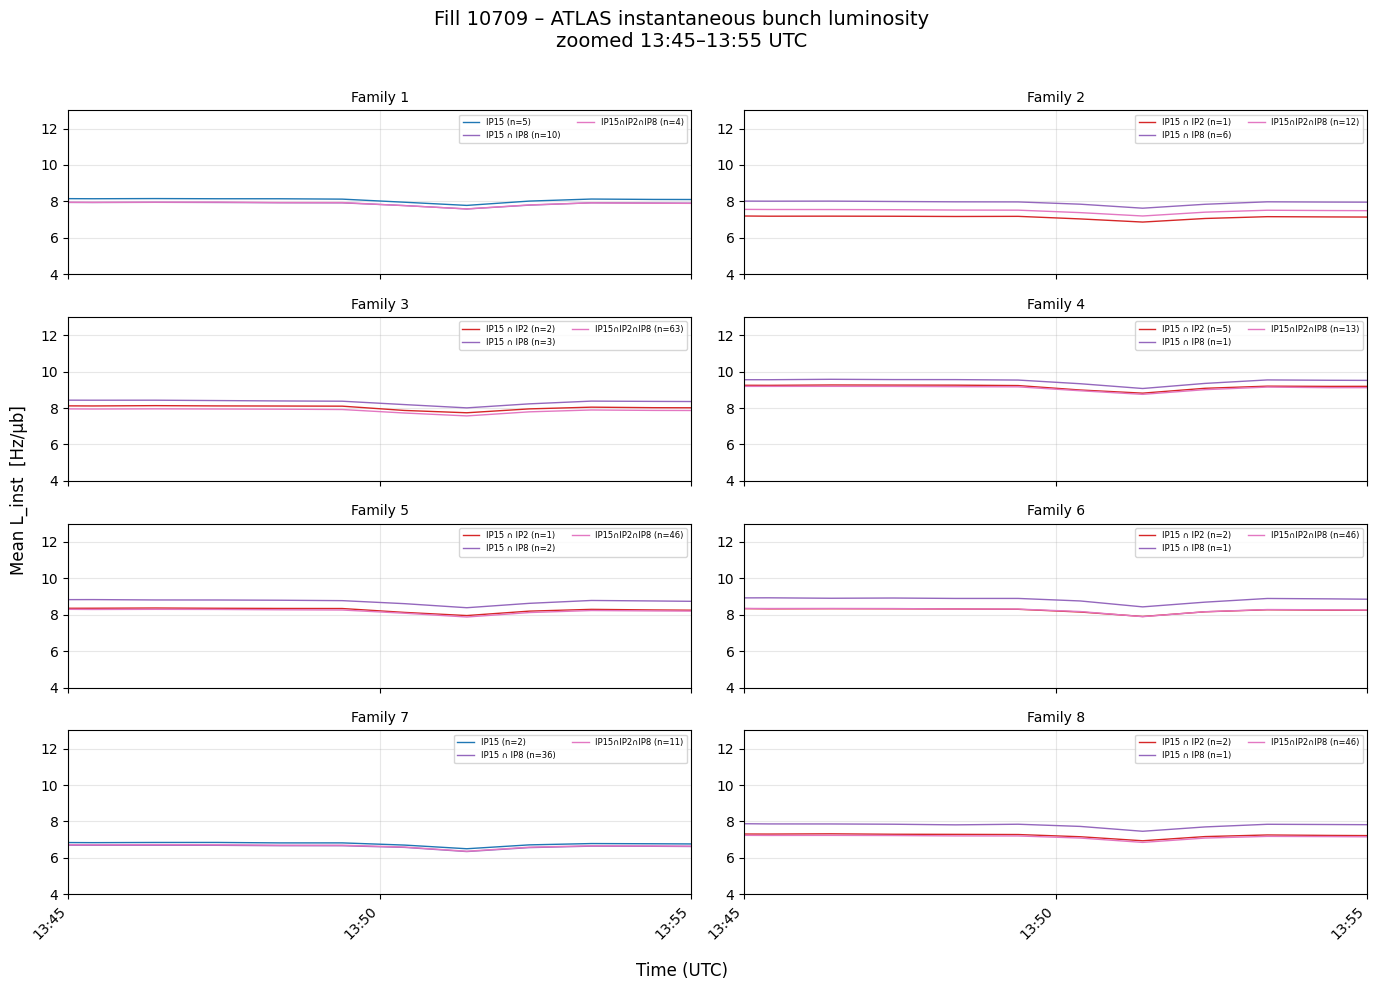

n      mean       std
Family   Group                               
Family 1 IP15           5  5.186642  2.532765
         IP15 ∩ IP8    10  5.091695  2.518519
         IP15∩IP2∩IP8   4  5.037821  2.513677
Family 2 IP15 ∩ IP2     1  4.440305  2.473125
         IP15 ∩ IP8     6  5.044431  2.878972
         IP15∩IP2∩IP8  12  4.701042  2.788577
Family 3 IP15 ∩ IP2     2  5.063282  2.579700
         IP15 ∩ IP8     3  5.297199  2.926902
         IP15∩IP2∩IP8  63  4.902131  2.701040
Family 4 IP15 ∩ IP2     5  5.869782  2.942443
         IP15 ∩ IP8     1  6.208498  3.275458
         IP15∩IP2∩IP8  13  5.853294  2.998163
Family 5 IP15 ∩ IP2     1  5.147080  2.717218
         IP15 ∩ IP8     2  5.552330  3.119920
         IP15∩IP2∩IP8  46  5.093896  2.869780
Family 6 IP15 ∩ IP2     2  5.135567  2.679110
         IP15 ∩ IP8     1  5.672567  3.123348
         IP15∩IP2∩IP8  46  5.159009  2.823219
Family 7 IP15           2  4.210076  2.034086
         IP15 ∩ IP8    36  4.152755  2.100427
         IP15∩IP2∩IP8  11  4.113678  2.140489
Family 8 IP15 ∩ IP2     2  4.449552  2.274882
         IP15 ∩ IP8     1  4.938654  2.670875
         IP15∩IP2∩IP8  46  4.451040  2.429825

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(14, 10), sharex=True)
axes = axes.flatten()
atlas_all_stats = []

for ax, (fam_name, fam_groups) in zip(axes, families.items()):
    for i, (grp_lbl, slots) in enumerate(fam_groups.items()):
        curve = mean_curve_atlas(slots)
        if curve is None:
            continue

        ax.plot(
            time_index_atlas, curve,
            label=f"{grp_lbl} (n={len(slots)})",
            color=atlas_palette[i % len(atlas_palette)],
            lw=1
        )
        atlas_all_stats.append({
            "Family": fam_name,
            "Group" : grp_lbl,
            "n"     : len(slots),
            "mean"  : np.nanmean(curve),
            "std"   : np.nanstd(curve),
        })

    ax.set_title(fam_name, fontsize=10)
    ax.grid(alpha=0.3)
    ax.legend(fontsize=6, ncol=2)
    ax.set_ylim(4, 13)
    ax.set_xlim(xmin, xmax)   # ← apply your chosen window here

# ── format x-axis ─────────────────────────────────────────────────────────
for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
for ax in axes[-2:]:
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

fig.suptitle(
    f"Fill {fno} – ATLAS instantaneous bunch luminosity\nzoomed {window_start}–{window_end} UTC",
    fontsize=14
)
fig.supxlabel("Time (UTC)")
fig.supylabel("Mean L_inst  [Hz/µb]")
fig.tight_layout(rect=[0,0,1,0.97])
plt.show()

# 4. ATLAS statistics table
stats_atlas_df = (
    pd.DataFrame(atlas_all_stats)
      .set_index(["Family", "Group"])
      .sort_index()
)
display(stats_atlas_df)


/tmp/ipykernel_3449522/2372741201.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette          = plt.cm.get_cmap("tab10").colors


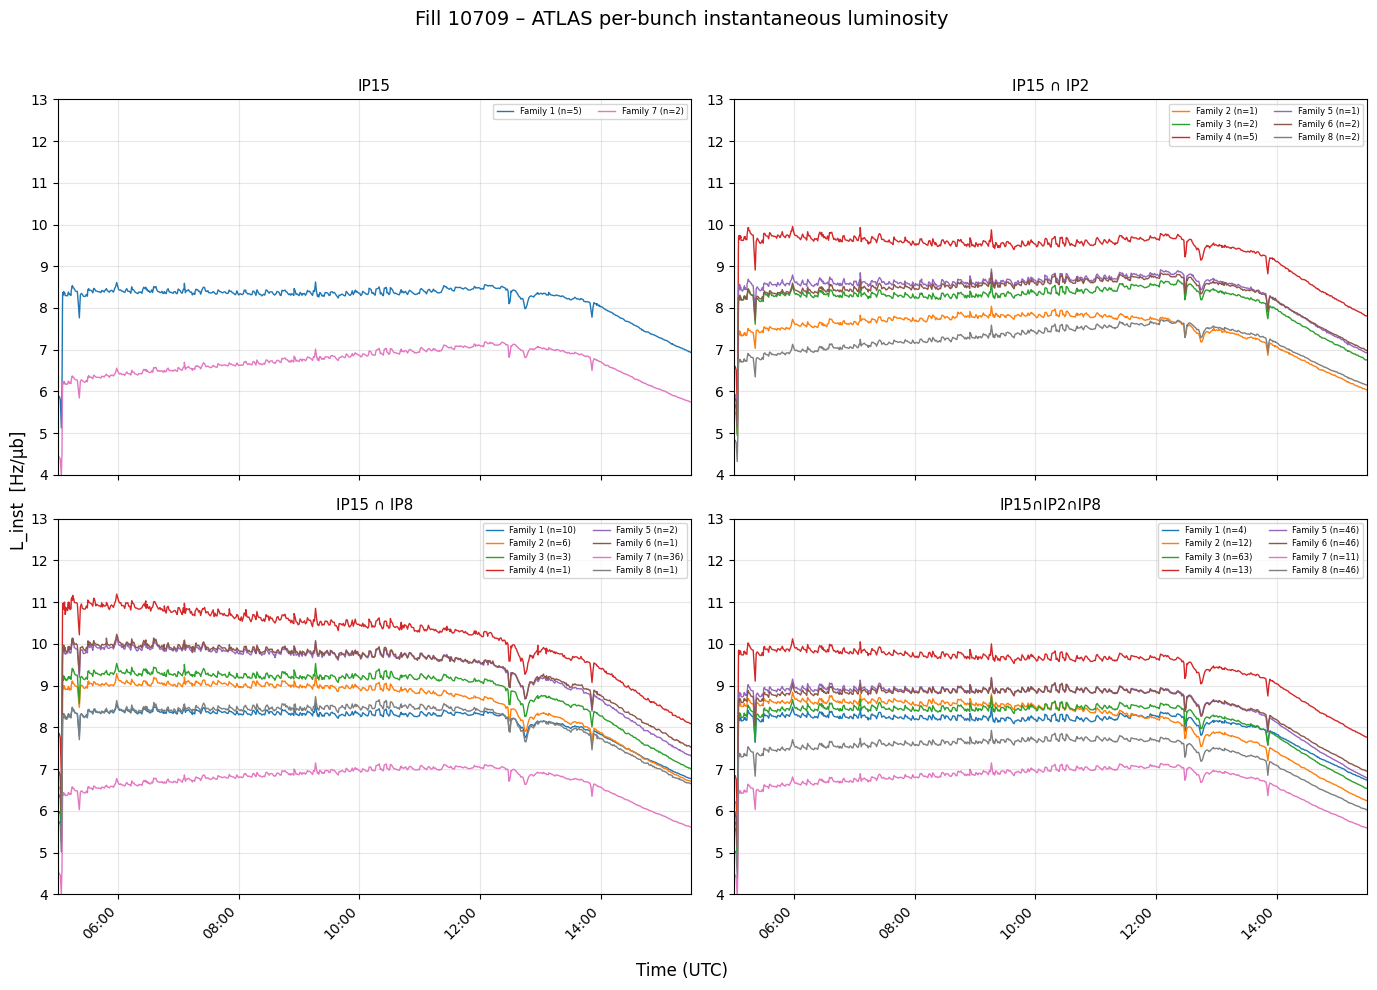

n      mean       std
IP class     Family                          
IP15         Family 1   5  5.186642  2.532765
             Family 7   2  4.210076  2.034086
IP15 ∩ IP2   Family 2   1  4.440305  2.473125
             Family 3   2  5.063282  2.579700
             Family 4   5  5.869782  2.942443
             Family 5   1  5.147080  2.717218
             Family 6   2  5.135567  2.679110
             Family 8   2  4.449552  2.274882
IP15 ∩ IP8   Family 1  10  5.091695  2.518519
             Family 2   6  5.044431  2.878972
             Family 3   3  5.297199  2.926902
             Family 4   1  6.208498  3.275458
             Family 5   2  5.552330  3.119920
             Family 6   1  5.672567  3.123348
             Family 7  36  4.152755  2.100427
             Family 8   1  4.938654  2.670875
IP15∩IP2∩IP8 Family 1   4  5.037821  2.513677
             Family 2  12  4.701042  2.788577
             Family 3  63  4.902131  2.701040
             Family 4  13  5.853294  2.998163
             Family 5  46  5.093896  2.869780
             Family 6  46  5.159009  2.823219
             Family 7  11  4.113678  2.140489
             Family 8  46  4.451040  2.429825

In [63]:
# ── 1. Load ATLAS per-bunch lumi in STABLE window ──────────────────────────
fno            = 10709
atlas_var      = "ATLAS:BUNCH_LUMI_INST"
DATADIR        = Path("/eos/project/l/lhc-lumimod/LuminosityFollowUp/2025/")
RAWPATH        = DATADIR / "rawdata"
FILLINFO       = DATADIR / "fills-info"

fbmodes = pd.read_parquet(FILLINFO / "fills_and_bmodes_2025.parquet")
rowST   = (fbmodes.loc[fno]
             .query("BMODE=='STABLE'")
             .sort_values("tsStart"))
if rowST.empty:
    rowST = fbmodes.loc[fno].sort_values("tsEnd").iloc[[-1]]

t1 = pd.to_datetime(rowST["tsStart"].iloc[0], utc=True)
t2 = pd.to_datetime(rowST["tsEnd"].iloc[0],   utc=True)

ser = pd.read_parquet(RAWPATH / f"HX:FILLN={fno}", columns=[atlas_var])[atlas_var]
ser.index = pd.to_datetime(ser.index, utc=True, errors="coerce")
# Boolean filter instead of .loc[t1:t2]
ser = ser[(ser.index >= t1) & (ser.index <= t2)].dropna()
if ser.empty:
    raise RuntimeError("No ATLAS lumi samples in STABLE window.")

M_atlas          = np.stack(ser.values)       # nTimes × 3564
time_index_atlas = ser.index
palette          = plt.cm.get_cmap("tab10").colors
# determine the date to use for 03:30 and 15:30
plot_date = time_index_atlas[0].date().isoformat()
xmin = pd.to_datetime(f"{plot_date} 05:00:00+00:00")
xmax = pd.to_datetime(f"{plot_date} 15:30:00+00:00")
# ── 2. helper for ATLAS mean curves ────────────────────────────────────────
def mean_curve_atlas(slots):
    slots = np.asarray(slots, int)
    return None if slots.size == 0 else np.nanmean(M_atlas[:, slots], axis=1)

# ── 3. Build & clean IP → Family panels ────────────────────────────────────
IP_panels = {ip: {fam: families[fam][ip] for fam in families} for ip in IP_keys}
clean_panels = {
    ip: fam_dict
    for ip, fam_dict in IP_panels.items()
    if any(np.asarray(slots, int).size for slots in fam_dict.values())
}

# ── 4. Take first 4 IP classes for 2×2 grid ───────────────────────────────
ip_items = list(clean_panels.items())[:4]

# ── 5. Plot ───────────────────────────────────────────────────────────────
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
axes = axes.flatten()
stats_rows = []

for ax, (ip_lbl, fam_dict) in zip(axes, ip_items):
    for i, (fam_lbl, slots) in enumerate(fam_dict.items()):
        curve = mean_curve_atlas(slots)
        if curve is None:
            continue
        ax.plot(time_index_atlas, curve,
                label=f"{fam_lbl} (n={len(slots)})",
                color=palette[i % len(palette)], lw=1)
        stats_rows.append({
            "IP class": ip_lbl,
            "Family"  : fam_lbl,
            "n"       : len(slots),
            "mean"    : np.nanmean(curve),
            "std"     : np.nanstd(curve),
        })
    ax.set_title(ip_lbl, fontsize=11)
    ax.grid(alpha=.3)
    ax.set_ylim(4, 13)
    # ← set x‐limits here
    ax.set_xlim(xmin, xmax)
    ax.legend(fontsize=6, ncol=2)

for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
for ax in axes[-2:]:
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

fig.suptitle(f"Fill {fno} – ATLAS per-bunch instantaneous luminosity", fontsize=14)
fig.supxlabel("Time (UTC)")
fig.supylabel("L_inst  [Hz/µb]")
fig.tight_layout(rect=[0,0,1,0.96])
plt.show()

# ── 6. Display stats table ─────────────────────────────────────────────────
stats_df = (pd.DataFrame(stats_rows)
            .set_index(["IP class", "Family"])
            .sort_index())
display(stats_df)


/tmp/ipykernel_3449522/1131106702.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette          = plt.cm.get_cmap("tab10").colors


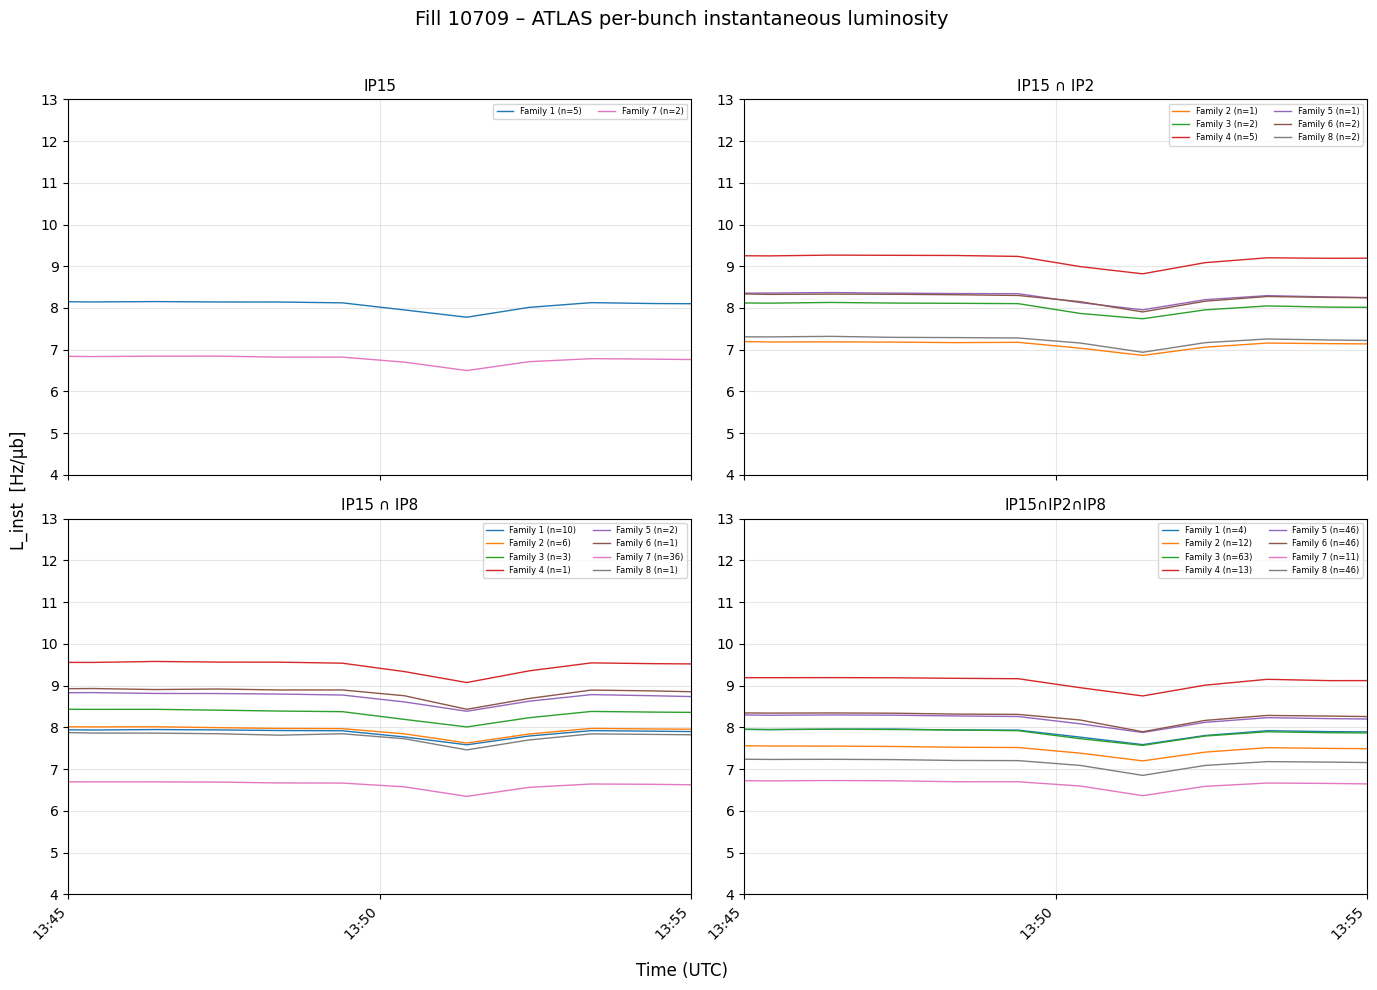

n      mean       std
IP class     Family                          
IP15         Family 1   5  5.186642  2.532765
             Family 7   2  4.210076  2.034086
IP15 ∩ IP2   Family 2   1  4.440305  2.473125
             Family 3   2  5.063282  2.579700
             Family 4   5  5.869782  2.942443
             Family 5   1  5.147080  2.717218
             Family 6   2  5.135567  2.679110
             Family 8   2  4.449552  2.274882
IP15 ∩ IP8   Family 1  10  5.091695  2.518519
             Family 2   6  5.044431  2.878972
             Family 3   3  5.297199  2.926902
             Family 4   1  6.208498  3.275458
             Family 5   2  5.552330  3.119920
             Family 6   1  5.672567  3.123348
             Family 7  36  4.152755  2.100427
             Family 8   1  4.938654  2.670875
IP15∩IP2∩IP8 Family 1   4  5.037821  2.513677
             Family 2  12  4.701042  2.788577
             Family 3  63  4.902131  2.701040
             Family 4  13  5.853294  2.998163
             Family 5  46  5.093896  2.869780
             Family 6  46  5.159009  2.823219
             Family 7  11  4.113678  2.140489
             Family 8  46  4.451040  2.429825

In [94]:
plot_date   = time_index_atlas[0].date().isoformat()  # e.g. "2025-06-11"
window_start = "13:45"   # ← change this
window_end   = "13:55"   # ← and this

# ── 1. Load ATLAS per-bunch lumi in STABLE window ──────────────────────────
fno            = 10709
atlas_var      = "ATLAS:BUNCH_LUMI_INST"
DATADIR        = Path("/eos/project/l/lhc-lumimod/LuminosityFollowUp/2025/")
RAWPATH        = DATADIR / "rawdata"
FILLINFO       = DATADIR / "fills-info"

fbmodes = pd.read_parquet(FILLINFO / "fills_and_bmodes_2025.parquet")
rowST   = (fbmodes.loc[fno]
             .query("BMODE=='STABLE'")
             .sort_values("tsStart"))
if rowST.empty:
    rowST = fbmodes.loc[fno].sort_values("tsEnd").iloc[[-1]]

t1 = pd.to_datetime(rowST["tsStart"].iloc[0], utc=True)
t2 = pd.to_datetime(rowST["tsEnd"].iloc[0],   utc=True)

ser = pd.read_parquet(RAWPATH / f"HX:FILLN={fno}", columns=[atlas_var])[atlas_var]
ser.index = pd.to_datetime(ser.index, utc=True, errors="coerce")
# Boolean filter instead of .loc[t1:t2]
ser = ser[(ser.index >= t1) & (ser.index <= t2)].dropna()
if ser.empty:
    raise RuntimeError("No ATLAS lumi samples in STABLE window.")

M_atlas          = np.stack(ser.values)       # nTimes × 3564
time_index_atlas = ser.index
palette          = plt.cm.get_cmap("tab10").colors
# determine the date to use for 03:30 and 15:30
# ── 2. helper for ATLAS mean curves ────────────────────────────────────────
def mean_curve_atlas(slots):
    slots = np.asarray(slots, int)
    return None if slots.size == 0 else np.nanmean(M_atlas[:, slots], axis=1)

# ── 3. Build & clean IP → Family panels ────────────────────────────────────
IP_panels = {ip: {fam: families[fam][ip] for fam in families} for ip in IP_keys}
clean_panels = {
    ip: fam_dict
    for ip, fam_dict in IP_panels.items()
    if any(np.asarray(slots, int).size for slots in fam_dict.values())
}

# ── 4. Take first 4 IP classes for 2×2 grid ───────────────────────────────
ip_items = list(clean_panels.items())[:4]

# ── 5. Plot ───────────────────────────────────────────────────────────────
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
axes = axes.flatten()
stats_rows = []
xmin = pd.to_datetime(f"{plot_date} {window_start}:00+00:00")
xmax = pd.to_datetime(f"{plot_date} {window_end  }:00+00:00")
for ax, (ip_lbl, fam_dict) in zip(axes, ip_items):
    for i, (fam_lbl, slots) in enumerate(fam_dict.items()):
        curve = mean_curve_atlas(slots)
        if curve is None:
            continue
        ax.plot(time_index_atlas, curve,
                label=f"{fam_lbl} (n={len(slots)})",
                color=palette[i % len(palette)], lw=1)
        stats_rows.append({
            "IP class": ip_lbl,
            "Family"  : fam_lbl,
            "n"       : len(slots),
            "mean"    : np.nanmean(curve),
            "std"     : np.nanstd(curve),
        })
    ax.set_title(ip_lbl, fontsize=11)
    ax.grid(alpha=.3)
    ax.set_ylim(4, 13)
    # ← set x‐limits here
    ax.set_xlim(xmin, xmax)
    ax.legend(fontsize=6, ncol=2)

for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
for ax in axes[-2:]:
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

fig.suptitle(f"Fill {fno} – ATLAS per-bunch instantaneous luminosity", fontsize=14)
fig.supxlabel("Time (UTC)")
fig.supylabel("L_inst  [Hz/µb]")
fig.tight_layout(rect=[0,0,1,0.96])
plt.show()

# ── 6. Display stats table ─────────────────────────────────────────────────
stats_df = (pd.DataFrame(stats_rows)
            .set_index(["IP class", "Family"])
            .sort_index())
display(stats_df)

## Luminosity CMS

/tmp/ipykernel_3449522/1723698295.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cms_palette      = plt.cm.get_cmap("tab10").colors


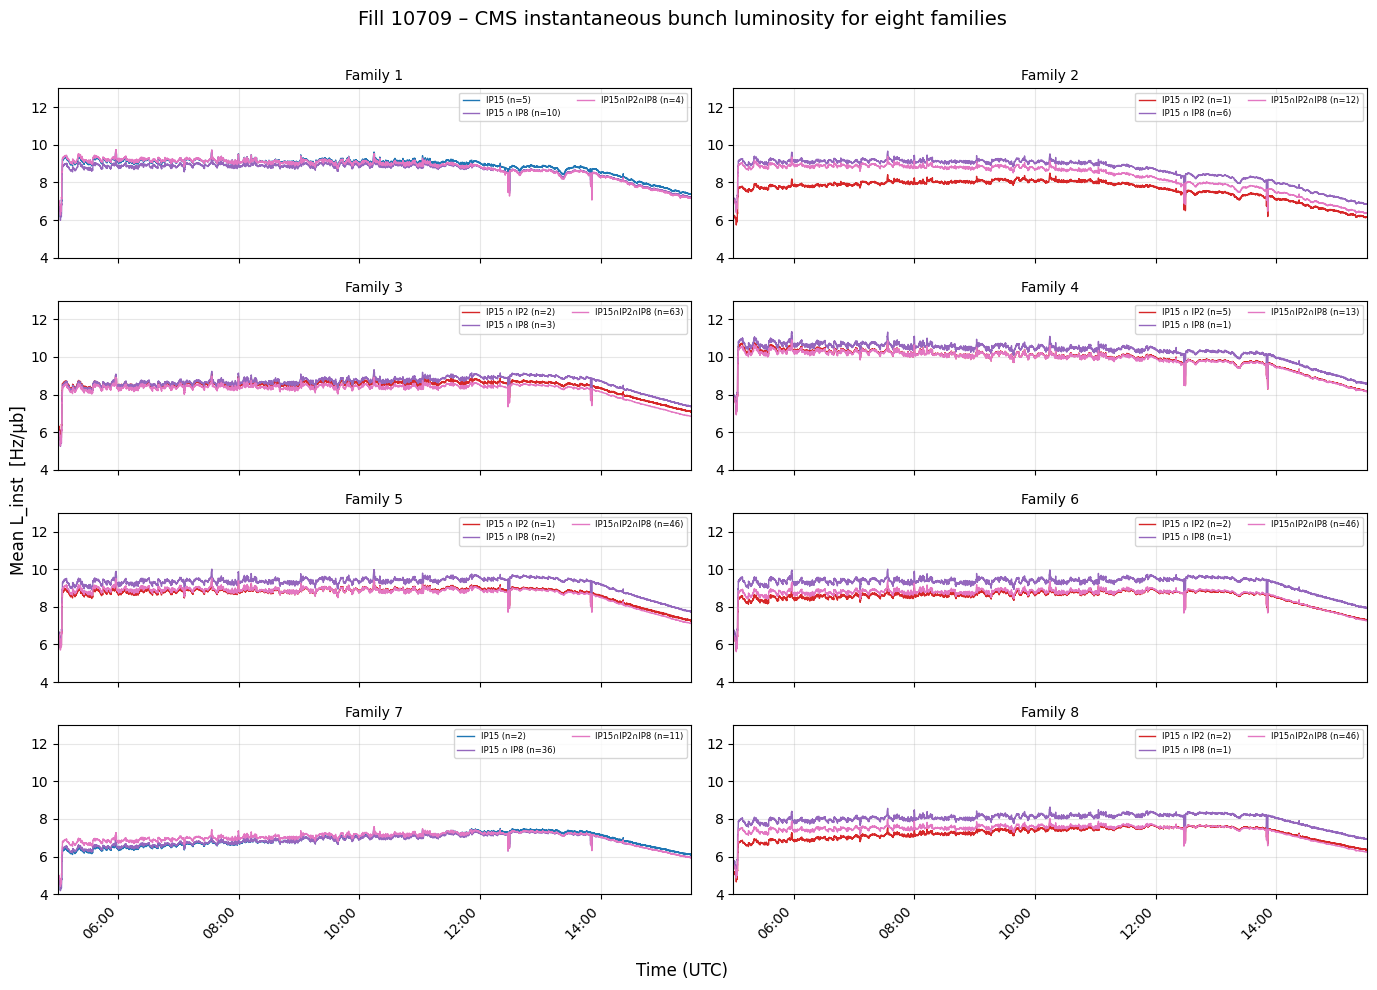

n      mean       std
Family   Group                               
Family 1 IP15           5  5.644058  2.673407
         IP15 ∩ IP8    10  5.505044  2.606434
         IP15∩IP2∩IP8   4  5.509017  2.696743
Family 2 IP15 ∩ IP2     1  4.646608  2.476425
         IP15 ∩ IP8     6  5.233865  2.825979
         IP15∩IP2∩IP8  12  4.894572  2.790093
Family 3 IP15 ∩ IP2     2  5.357725  2.555361
         IP15 ∩ IP8     3  5.411712  2.678421
         IP15∩IP2∩IP8  63  5.103467  2.608548
Family 4 IP15 ∩ IP2     5  6.275905  2.996555
         IP15 ∩ IP8     1  6.505164  3.142721
         IP15∩IP2∩IP8  13  6.223218  3.012492
Family 5 IP15 ∩ IP2     1  5.445084  2.700500
         IP15 ∩ IP8     2  5.716555  2.911847
         IP15∩IP2∩IP8  46  5.309144  2.796253
Family 6 IP15 ∩ IP2     2  5.404842  2.624982
         IP15 ∩ IP8     1  5.845881  2.880912
         IP15∩IP2∩IP8  46  5.369972  2.726614
Family 7 IP15           2  4.484655  2.018741
         IP15 ∩ IP8    36  4.385187  2.051455
         IP15∩IP2∩IP8  11  4.387490  2.152632
Family 8 IP15 ∩ IP2     2  4.645740  2.186454
         IP15 ∩ IP8     1  5.078055  2.466782
         IP15∩IP2∩IP8  46  4.610807  2.331012

In [64]:

# ── 1. PARAMETERS & LOAD CMS per-bunch luminosity ──────────────────────────
fno           = 10709
cms_lumi_var  = "CMS:BUNCH_LUMI_INST"
DATADIR       = Path("/eos/project/l/lhc-lumimod/LuminosityFollowUp/2025/")
RAWPATH       = DATADIR / "rawdata"
FILLINFO      = DATADIR / "fills-info"

# ── STABLE-beam window ─────────────────────────────────────────────────────
fbmodes = pd.read_parquet(FILLINFO / "fills_and_bmodes_2025.parquet")
rowST   = (
    fbmodes.loc[fno]
           .query("BMODE=='STABLE'")
           .sort_values("tsStart")
)
if rowST.empty:
    rowST = fbmodes.loc[fno].sort_values("tsEnd").iloc[[-1]]

t_start_cms = pd.to_datetime(rowST["tsStart"].iloc[0], utc=True)
t_end_cms   = pd.to_datetime(rowST["tsEnd"].iloc[0],   utc=True)

# ── load CMS lumi parquet and slice to STABLE interval ────────────────────
ser_cms = pd.read_parquet(
    RAWPATH / f"HX:FILLN={fno}", columns=[cms_lumi_var]
)[cms_lumi_var]
ser_cms.index = pd.to_datetime(ser_cms.index, utc=True, errors="coerce")
ser_cms = ser_cms[(ser_cms.index >= t_start_cms) & (ser_cms.index <= t_end_cms)].dropna()
if ser_cms.empty:
    raise RuntimeError("No CMS per-bunch lumi samples in STABLE window.")

# ── stack into array and record time index ─────────────────────────────────
M_cms            = np.stack(ser_cms.values)     # shape: (nTimes, 3564)
time_index_cms   = ser_cms.index
cms_palette      = plt.cm.get_cmap("tab10").colors
plot_date = time_index_atlas[0].date().isoformat()
xmin = pd.to_datetime(f"{plot_date} 05:00:00+00:00")
xmax = pd.to_datetime(f"{plot_date} 15:30:00+00:00")
# ── 2. helper for CMS mean curves ──────────────────────────────────────────
def mean_curve_cms(slots):
    slots = np.asarray(slots, int)
    return None if slots.size == 0 else np.nanmean(M_cms[:, slots], axis=1)

# ── 3. Plotting eight families for CMS ─────────────────────────────────────
fig, axes = plt.subplots(4, 2, figsize=(14, 10), sharex=True)
axes = axes.flatten()
cms_stats = []

for ax, (fam_name, fam_groups) in zip(axes, families.items()):
    for i, (grp_lbl, slots) in enumerate(fam_groups.items()):
        curve = mean_curve_cms(slots)
        if curve is None:
            continue
        ax.plot(
            time_index_cms, curve,
            label=f"{grp_lbl} (n={len(slots)})",
            color=cms_palette[i % len(cms_palette)],
            lw=1
        )
        cms_stats.append({
            "Family": fam_name,
            "Group" : grp_lbl,
            "n"     : len(slots),
            "mean"  : np.nanmean(curve),
            "std"   : np.nanstd(curve),
        })

    ax.set_title(fam_name, fontsize=10)
    ax.grid(alpha=0.3)
    ax.set_ylim(4, 13)
    # ← set x‐limits here
    ax.set_xlim(xmin, xmax)
    ax.legend(fontsize=6, ncol=2)
for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
for ax in axes[-2:]:
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
fig.suptitle(
    f"Fill {fno} – CMS instantaneous bunch luminosity for eight families",
    fontsize=14
)
fig.supxlabel("Time (UTC)")
fig.supylabel("Mean L_inst  [Hz/µb]")
fig.tight_layout(rect=[0,0,1,0.97])
plt.show()

# ── 4. CMS statistics table ─────────────────────────────────────────────────
stats_cms_df = (
    pd.DataFrame(cms_stats)
      .set_index(["Family", "Group"])
      .sort_index()
)
display(stats_cms_df)


In [ ]:
plot_date   = time_index_cms[0].date().isoformat()  # e.g. "2025-06-11"
window_start = "13:45"   # ← change this
window_end   = "13:55"   # ← and this

xmin = pd.to_datetime(f"{plot_date} {window_start}:00+00:00")
xmax = pd.to_datetime(f"{plot_date} {window_end  }:00+00:00")

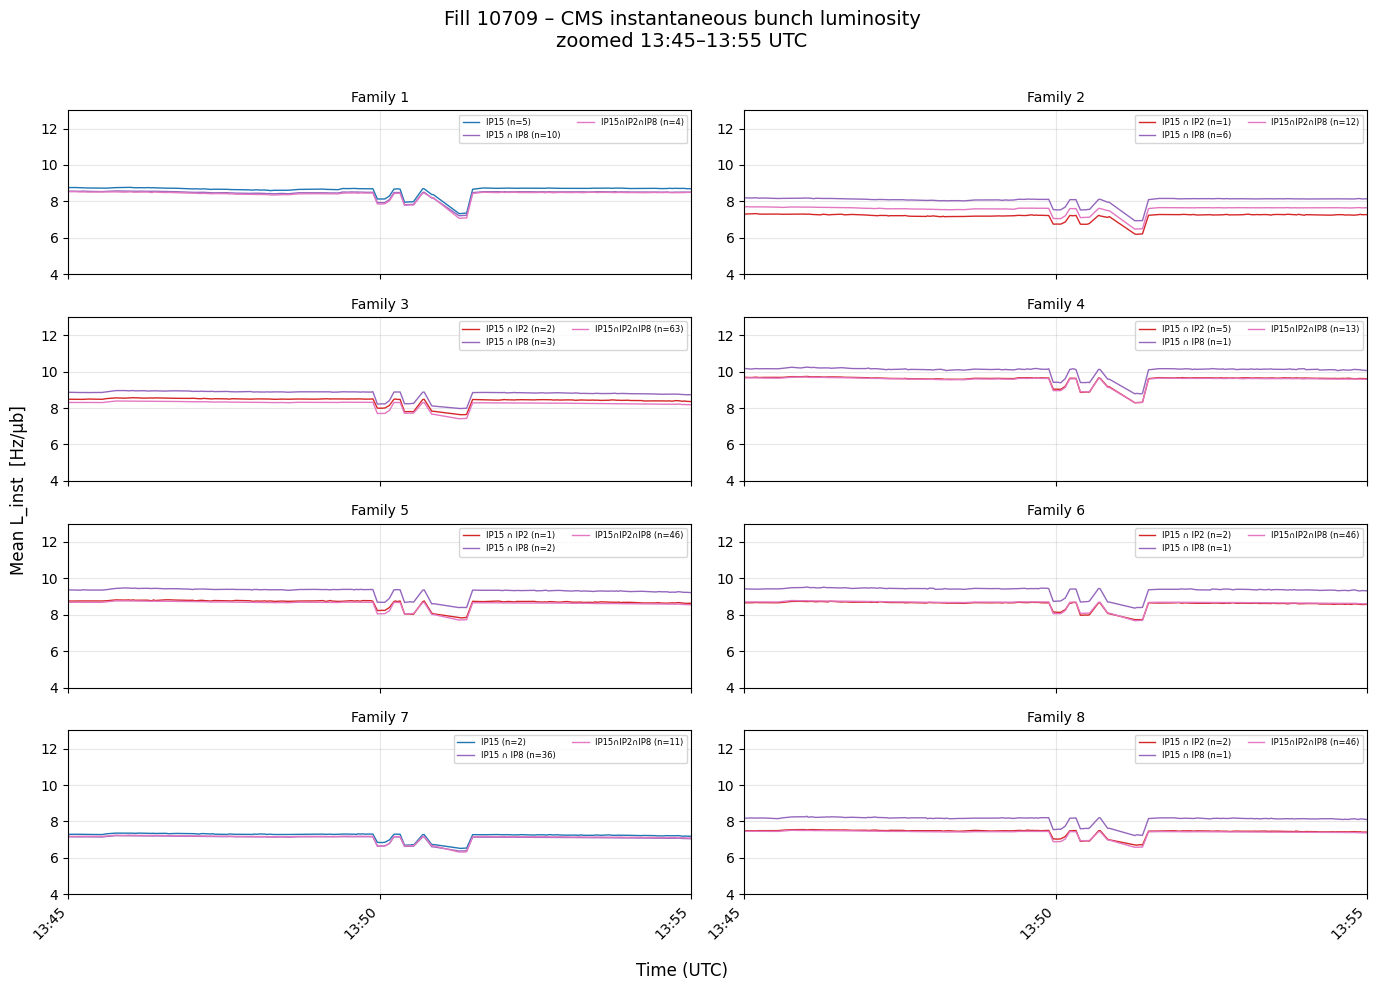

n      mean       std
Family   Group                               
Family 1 IP15           5  5.644058  2.673407
         IP15 ∩ IP8    10  5.505044  2.606434
         IP15∩IP2∩IP8   4  5.509017  2.696743
Family 2 IP15 ∩ IP2     1  4.646608  2.476425
         IP15 ∩ IP8     6  5.233865  2.825979
         IP15∩IP2∩IP8  12  4.894572  2.790093
Family 3 IP15 ∩ IP2     2  5.357725  2.555361
         IP15 ∩ IP8     3  5.411712  2.678421
         IP15∩IP2∩IP8  63  5.103467  2.608548
Family 4 IP15 ∩ IP2     5  6.275905  2.996555
         IP15 ∩ IP8     1  6.505164  3.142721
         IP15∩IP2∩IP8  13  6.223218  3.012492
Family 5 IP15 ∩ IP2     1  5.445084  2.700500
         IP15 ∩ IP8     2  5.716555  2.911847
         IP15∩IP2∩IP8  46  5.309144  2.796253
Family 6 IP15 ∩ IP2     2  5.404842  2.624982
         IP15 ∩ IP8     1  5.845881  2.880912
         IP15∩IP2∩IP8  46  5.369972  2.726614
Family 7 IP15           2  4.484655  2.018741
         IP15 ∩ IP8    36  4.385187  2.051455
         IP15∩IP2∩IP8  11  4.387490  2.152632
Family 8 IP15 ∩ IP2     2  4.645740  2.186454
         IP15 ∩ IP8     1  5.078055  2.466782
         IP15∩IP2∩IP8  46  4.610807  2.331012

In [ ]:


def mean_curve_cms(slots):
    slots = np.asarray(slots, int)
    return None if slots.size == 0 else np.nanmean(M_cms[:, slots], axis=1)

# ── 3. Plotting eight families for CMS ─────────────────────────────────────
fig, axes = plt.subplots(4, 2, figsize=(14, 10), sharex=True)
axes = axes.flatten()
cms_stats = []

for ax, (fam_name, fam_groups) in zip(axes, families.items()):
    for i, (grp_lbl, slots) in enumerate(fam_groups.items()):
        curve = mean_curve_cms(slots)
        if curve is None:
            continue
        ax.plot(
            time_index_cms, curve,
            label=f"{grp_lbl} (n={len(slots)})",
            color=cms_palette[i % len(cms_palette)],
            lw=1
        )
        cms_stats.append({
            "Family": fam_name,
            "Group" : grp_lbl,
            "n"     : len(slots),
            "mean"  : np.nanmean(curve),
            "std"   : np.nanstd(curve),
        })

    ax.set_title(fam_name, fontsize=10)
    ax.grid(alpha=0.3)
    ax.legend(fontsize=6, ncol=2)
    ax.set_ylim(4, 13)
    ax.set_xlim(xmin, xmax)   # ← apply your chosen window here

# ── format x-axis ─────────────────────────────────────────────────────────
for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
for ax in axes[-2:]:
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

fig.suptitle(
    f"Fill {fno} – CMS instantaneous bunch luminosity\nzoomed {window_start}–{window_end} UTC",
    fontsize=14
)
fig.supxlabel("Time (UTC)")
fig.supylabel("Mean L_inst  [Hz/µb]")
fig.tight_layout(rect=[0,0,1,0.97])
plt.show()


In [ ]:
DATADIR = Path("/eos/project/l/lhc-lumimod/LuminosityFollowUp/2025/")

print(DATADIR.exists(), DATADIR.is_dir())
import os

for root, dirs, files in os.walk(DATADIR):
    # show subdirs
    for d in dirs:
        print("DIR:", os.path.join(root, d))
    # show files
    for f in files:
        print("FILE:", os.path.join(root, f))


In [153]:
# ── 0. load fbmodes and extract β* ───────────────────────────────────────────
fbmodes = pd.read_parquet(FILLINFO / "fills_and_bmodes_2025.parquet")
if 'timestamp' in fbmodes.columns:
    fbmodes = fbmodes.set_index('timestamp').sort_index()

# extract only IP1 β* over your zoom window
betastar = fbmodes['HX:BETASTAR_IP1'].loc[window_start:window_end]

# ── 2. Plotting eight families for CMS with β* on twin axis ────────────────
fig, axes = plt.subplots(4, 2, figsize=(14, 10), sharex=True)
axes = axes.flatten()
cms_stats = []

for ax, (fam_name, fam_groups) in zip(axes, families.items()):
    # … (your existing L_inst plotting code) …

    # twin axis for β* (IP1 only)
    ax2 = ax.twinx()
    ax2.plot(
        betastar.index, betastar.values,
        color='grey', lw=1, linestyle='--',
        label=r"$\beta^*_{\mathrm{IP1}}$"
    )
    ax2.set_ylabel(r"$\beta^*$  [m]", fontsize=8, color='grey')
    ax2.tick_params(axis='y', labelsize=6, labelcolor='grey')
    ax2.legend(loc='upper right', fontsize=6)

    # main legend
    ax.legend(fontsize=6, ncol=2)

# ── 3. format x-axis ────────────────────────────────────────────────────────
for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
for ax in axes[-2:]:
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# ── 4. annotations and layout ───────────────────────────────────────────────
fig.suptitle(
    f"Fill {fno} – CMS instantaneous bunch luminosity\n"
    f"zoomed {window_start}–{window_end} UTC",
    fontsize=14
)
fig.supxlabel("Time (UTC)")
fig.supylabel("Mean L_inst  [Hz/µb]")
fig.tight_layout(rect=[0,0,1,0.97])
plt.show()


KeyError: 'HX:BETASTAR_IP1'

/tmp/ipykernel_3449522/472682964.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cms_palette      = plt.cm.get_cmap("tab10").colors


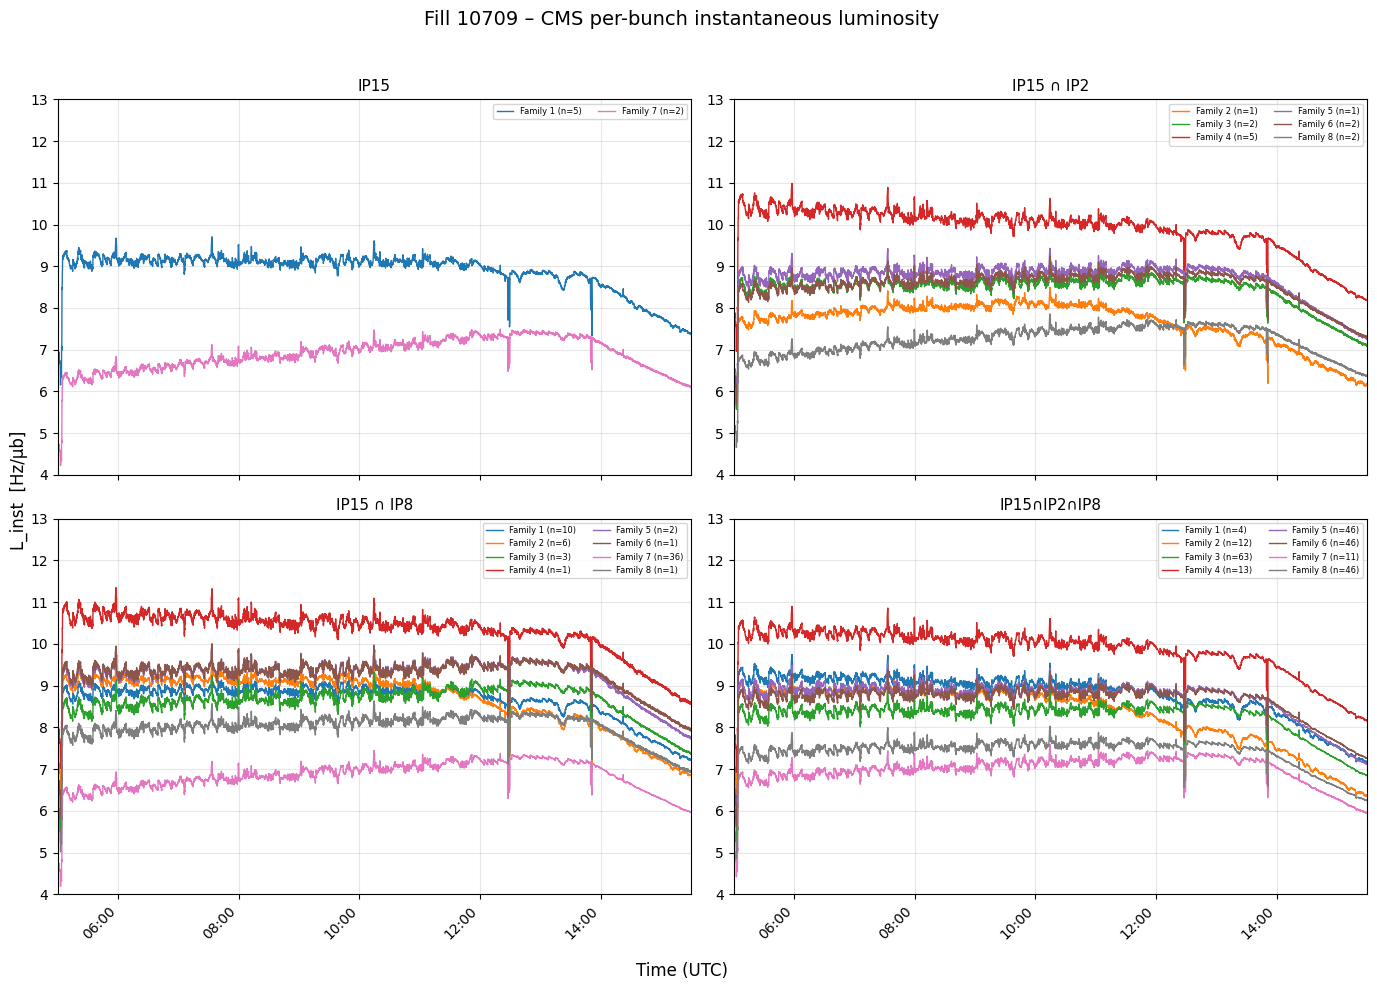

n      mean       std
IP class     Family                          
IP15         Family 1   5  5.644058  2.673407
             Family 7   2  4.484655  2.018741
IP15 ∩ IP2   Family 2   1  4.646608  2.476425
             Family 3   2  5.357725  2.555361
             Family 4   5  6.275905  2.996555
             Family 5   1  5.445084  2.700500
             Family 6   2  5.404842  2.624982
             Family 8   2  4.645740  2.186454
IP15 ∩ IP8   Family 1  10  5.505044  2.606434
             Family 2   6  5.233865  2.825979
             Family 3   3  5.411712  2.678421
             Family 4   1  6.505164  3.142721
             Family 5   2  5.716555  2.911847
             Family 6   1  5.845881  2.880912
             Family 7  36  4.385187  2.051455
             Family 8   1  5.078055  2.466782
IP15∩IP2∩IP8 Family 1   4  5.509017  2.696743
             Family 2  12  4.894572  2.790093
             Family 3  63  5.103467  2.608548
             Family 4  13  6.223218  3.012492
             Family 5  46  5.309144  2.796253
             Family 6  46  5.369972  2.726614
             Family 7  11  4.387490  2.152632
             Family 8  46  4.610807  2.331012

In [65]:
fno           = 10709
cms_lumi_var  = "CMS:BUNCH_LUMI_INST"
DATADIR       = Path("/eos/project/l/lhc-lumimod/LuminosityFollowUp/2025/")
RAWPATH       = DATADIR / "rawdata"
FILLINFO      = DATADIR / "fills-info"

# ── STABLE-beam window ─────────────────────────────────────────────────────
fbmodes = pd.read_parquet(FILLINFO / "fills_and_bmodes_2025.parquet")
rowST   = (
    fbmodes.loc[fno]
           .query("BMODE=='STABLE'")
           .sort_values("tsStart")
)
if rowST.empty:
    rowST = fbmodes.loc[fno].sort_values("tsEnd").iloc[[-1]]

t_start_cms = pd.to_datetime(rowST["tsStart"].iloc[0], utc=True)
t_end_cms   = pd.to_datetime(rowST["tsEnd"].iloc[0],   utc=True)

# ── Load CMS lumi and restrict to STABLE window ───────────────────────────
ser_cms = pd.read_parquet(RAWPATH / f"HX:FILLN={fno}", columns=[cms_lumi_var])[cms_lumi_var]
ser_cms.index = pd.to_datetime(ser_cms.index, utc=True, errors="coerce")
ser_cms = ser_cms[(ser_cms.index >= t_start_cms) & (ser_cms.index <= t_end_cms)].dropna()
if ser_cms.empty:
    raise RuntimeError("No CMS per-bunch lumi samples in STABLE window.")

M_cms            = np.stack(ser_cms.values)  # shape: (nTimes, 3564)
time_index_cms   = ser_cms.index
cms_palette      = plt.cm.get_cmap("tab10").colors
plot_date = time_index_atlas[0].date().isoformat()
xmin = pd.to_datetime(f"{plot_date} 05:00:00+00:00")
xmax = pd.to_datetime(f"{plot_date} 15:30:00+00:00")
# ── 2. helper for CMS mean curves ──────────────────────────────────────────
def mean_curve_cms(slots):
    slots = np.asarray(slots, int)
    return None if slots.size == 0 else np.nanmean(M_cms[:, slots], axis=1)

# ── 3. Build & clean IP→Family panels ─────────────────────────────────────
IP_panels = {
    ip: {fam: families[fam][ip] for fam in families}
    for ip in IP_keys
}
clean_panels = {
    ip: fam_dict
    for ip, fam_dict in IP_panels.items()
    if any(np.asarray(slots, int).size for slots in fam_dict.values())
}

# ── 4. Take first 4 IP classes for a 2×2 grid ────────────────────────────
ip_items = list(clean_panels.items())[:4]

# ── 5. Plot ───────────────────────────────────────────────────────────────
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
axes = axes.flatten()
stats_rows = []

for ax, (ip_lbl, fam_dict) in zip(axes, ip_items):
    for i, (fam_lbl, slots) in enumerate(fam_dict.items()):
        curve = mean_curve_cms(slots)
        if curve is None:
            continue
        ax.plot(
            time_index_cms, curve,
            label=f"{fam_lbl} (n={len(slots)})",
            color=cms_palette[i % len(cms_palette)], lw=1
        )
        stats_rows.append({
            "IP class": ip_lbl,
            "Family"  : fam_lbl,
            "n"       : len(slots),
            "mean"    : np.nanmean(curve),
            "std"     : np.nanstd(curve),
        })
    ax.set_title(ip_lbl, fontsize=11)
    ax.grid(alpha=0.3)
    ax.set_ylim(4, 13)
    # ← set x‐limits here
    ax.set_xlim(xmin, xmax)
    ax.legend(fontsize=6, ncol=2)

# remove unused axes
for ax in axes[len(ip_items):]:
    fig.delaxes(ax)
for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
for ax in axes[-2:]:
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
fig.suptitle(f"Fill {fno} – CMS per-bunch instantaneous luminosity", fontsize=14)
fig.supxlabel("Time (UTC)")
fig.supylabel("L_inst  [Hz/µb]")
fig.tight_layout(rect=[0,0,1,0.96])
plt.show()

# ── 6. Display stats table ─────────────────────────────────────────────────
stats_cms_df = (
    pd.DataFrame(stats_rows)
      .set_index(["IP class", "Family"])
      .sort_index()
)
display(stats_cms_df)

In [95]:
plot_date   = time_index_atlas[0].date().isoformat()  # e.g. "2025-06-11"
window_start = "13:45"   # ← change this
window_end   = "13:55"   # ← and this

xmin = pd.to_datetime(f"{plot_date} {window_start}:00+00:00")
xmax = pd.to_datetime(f"{plot_date} {window_end  }:00+00:00")

/tmp/ipykernel_3449522/1209715785.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cms_palette      = plt.cm.get_cmap("tab10").colors


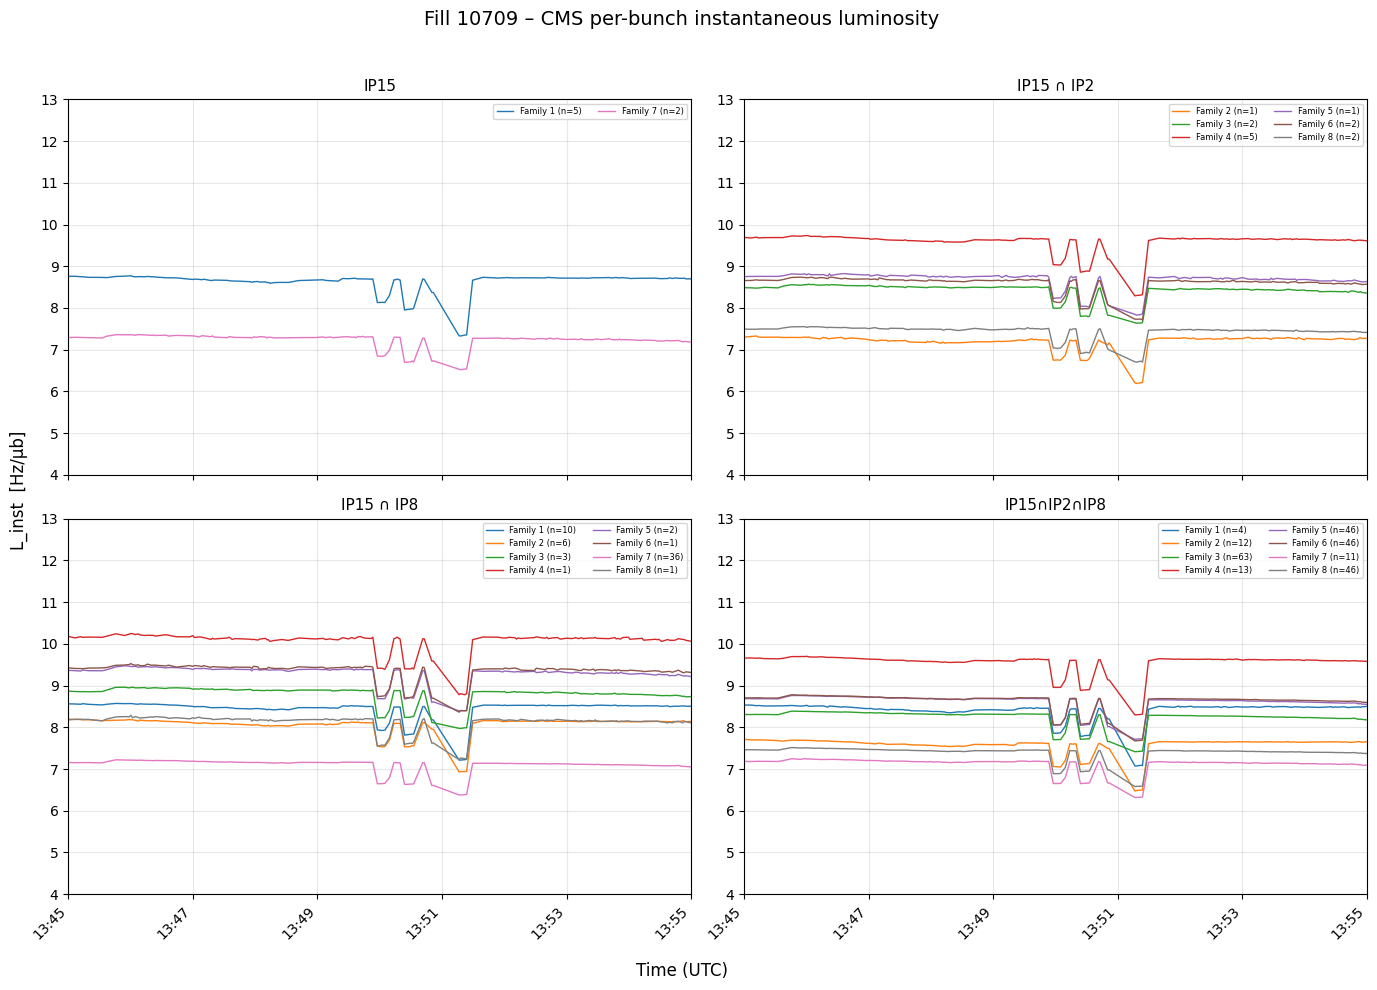

n      mean       std
IP class     Family                          
IP15         Family 1   5  5.644058  2.673407
             Family 7   2  4.484655  2.018741
IP15 ∩ IP2   Family 2   1  4.646608  2.476425
             Family 3   2  5.357725  2.555361
             Family 4   5  6.275905  2.996555
             Family 5   1  5.445084  2.700500
             Family 6   2  5.404842  2.624982
             Family 8   2  4.645740  2.186454
IP15 ∩ IP8   Family 1  10  5.505044  2.606434
             Family 2   6  5.233865  2.825979
             Family 3   3  5.411712  2.678421
             Family 4   1  6.505164  3.142721
             Family 5   2  5.716555  2.911847
             Family 6   1  5.845881  2.880912
             Family 7  36  4.385187  2.051455
             Family 8   1  5.078055  2.466782
IP15∩IP2∩IP8 Family 1   4  5.509017  2.696743
             Family 2  12  4.894572  2.790093
             Family 3  63  5.103467  2.608548
             Family 4  13  6.223218  3.012492
             Family 5  46  5.309144  2.796253
             Family 6  46  5.369972  2.726614
             Family 7  11  4.387490  2.152632
             Family 8  46  4.610807  2.331012

In [96]:
fno           = 10709
cms_lumi_var  = "CMS:BUNCH_LUMI_INST"
DATADIR       = Path("/eos/project/l/lhc-lumimod/LuminosityFollowUp/2025/")
RAWPATH       = DATADIR / "rawdata"
FILLINFO      = DATADIR / "fills-info"

# ── STABLE-beam window ─────────────────────────────────────────────────────
fbmodes = pd.read_parquet(FILLINFO / "fills_and_bmodes_2025.parquet")
rowST   = (
    fbmodes.loc[fno]
           .query("BMODE=='STABLE'")
           .sort_values("tsStart")
)
if rowST.empty:
    rowST = fbmodes.loc[fno].sort_values("tsEnd").iloc[[-1]]

t_start_cms = pd.to_datetime(rowST["tsStart"].iloc[0], utc=True)
t_end_cms   = pd.to_datetime(rowST["tsEnd"].iloc[0],   utc=True)

# ── Load CMS lumi and restrict to STABLE window ───────────────────────────
ser_cms = pd.read_parquet(RAWPATH / f"HX:FILLN={fno}", columns=[cms_lumi_var])[cms_lumi_var]
ser_cms.index = pd.to_datetime(ser_cms.index, utc=True, errors="coerce")
ser_cms = ser_cms[(ser_cms.index >= t_start_cms) & (ser_cms.index <= t_end_cms)].dropna()
if ser_cms.empty:
    raise RuntimeError("No CMS per-bunch lumi samples in STABLE window.")

M_cms            = np.stack(ser_cms.values)  # shape: (nTimes, 3564)
time_index_cms   = ser_cms.index
cms_palette      = plt.cm.get_cmap("tab10").colors
# ── 2. helper for CMS mean curves ──────────────────────────────────────────
def mean_curve_cms(slots):
    slots = np.asarray(slots, int)
    return None if slots.size == 0 else np.nanmean(M_cms[:, slots], axis=1)

# ── 3. Build & clean IP→Family panels ─────────────────────────────────────
IP_panels = {
    ip: {fam: families[fam][ip] for fam in families}
    for ip in IP_keys
}
clean_panels = {
    ip: fam_dict
    for ip, fam_dict in IP_panels.items()
    if any(np.asarray(slots, int).size for slots in fam_dict.values())
}

# ── 4. Take first 4 IP classes for a 2×2 grid ────────────────────────────
ip_items = list(clean_panels.items())[:4]

# ── 5. Plot ───────────────────────────────────────────────────────────────
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
axes = axes.flatten()
stats_rows = []

for ax, (ip_lbl, fam_dict) in zip(axes, ip_items):
    for i, (fam_lbl, slots) in enumerate(fam_dict.items()):
        curve = mean_curve_cms(slots)
        if curve is None:
            continue
        ax.plot(
            time_index_cms, curve,
            label=f"{fam_lbl} (n={len(slots)})",
            color=cms_palette[i % len(cms_palette)], lw=1
        )
        stats_rows.append({
            "IP class": ip_lbl,
            "Family"  : fam_lbl,
            "n"       : len(slots),
            "mean"    : np.nanmean(curve),
            "std"     : np.nanstd(curve),
        })
    ax.set_title(ip_lbl, fontsize=11)
    ax.grid(alpha=0.3)
    ax.set_ylim(4, 13)
    # ← set x‐limits here
    ax.set_xlim(xmin, xmax)
    ax.legend(fontsize=6, ncol=2)

# remove unused axes
for ax in axes[len(ip_items):]:
    fig.delaxes(ax)
for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=2))
for ax in axes[-2:]:
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
fig.suptitle(f"Fill {fno} – CMS per-bunch instantaneous luminosity", fontsize=14)
fig.supxlabel("Time (UTC)")
fig.supylabel("L_inst  [Hz/µb]")
fig.tight_layout(rect=[0,0,1,0.96])
plt.show()

# ── 6. Display stats table ─────────────────────────────────────────────────
stats_cms_df = (
    pd.DataFrame(stats_rows)
      .set_index(["IP class", "Family"])
      .sort_index()
)
display(stats_cms_df)

## CHOOSE TO ZOOM IN 

In [66]:
def plot_inst_lumi(source, *, ip_class=None, family=None):
    """
    Plot instantaneous luminosity curves for one IP_class (all families)
    or one family (all IP_classes), for ATLAS or CMS.
    """

    if (ip_class is None) == (family is None):
        raise ValueError("Specify exactly one of ip_class or family")

    src = source.upper()
    if src == "ATLAS":
        M, t_idx, pal = M_atlas, time_index_atlas, atlas_palette
    elif src == "CMS":
        M, t_idx, pal = M_cms,   time_index_cms,   cms_palette
    else:
        raise KeyError("source must be 'ATLAS' or 'CMS'")

    def mean_curve(slots):
        s = np.asarray(slots, int)
        return None if s.size == 0 else np.nanmean(M[:, s], axis=1)

    fig, ax = plt.subplots(figsize=(12, 4), sharex=True)

    if ip_class is not None:
        # Plot every Family (dict key) for this IP class
        for i, fam_name in enumerate(families):
            slots = families[fam_name].get(ip_class, [])
            curve = mean_curve(slots)
            if curve is None:
                continue
            ax.plot(t_idx, curve,
                    label=f"{fam_name} (n={len(slots)})",
                    color=pal[i % len(pal)])
        title = f"{src} – {ip_class}"

    else:
        # Plot every IP key for this one Family
        fam_full = family if family.startswith("Family") else f"Family {family}"
        if fam_full not in families:
            raise KeyError(f"Family '{family}' not found.")
        for i, ip_lbl in enumerate(IP_keys):
            slots = families[fam_full].get(ip_lbl, [])
            curve = mean_curve(slots)
            if curve is None:
                continue
            ax.plot(t_idx, curve,
                    label=f"{ip_lbl} (n={len(slots)})",
                    color=pal[i % len(pal)])
        title = f"{src} – {fam_full}"

    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Time (UTC)")
    ax.set_ylabel("L_inst  [Hz/µb]")
    ax.grid(alpha=0.3)
    ax.legend(fontsize=8, ncol=2)
    plt.tight_layout()
    plt.show()


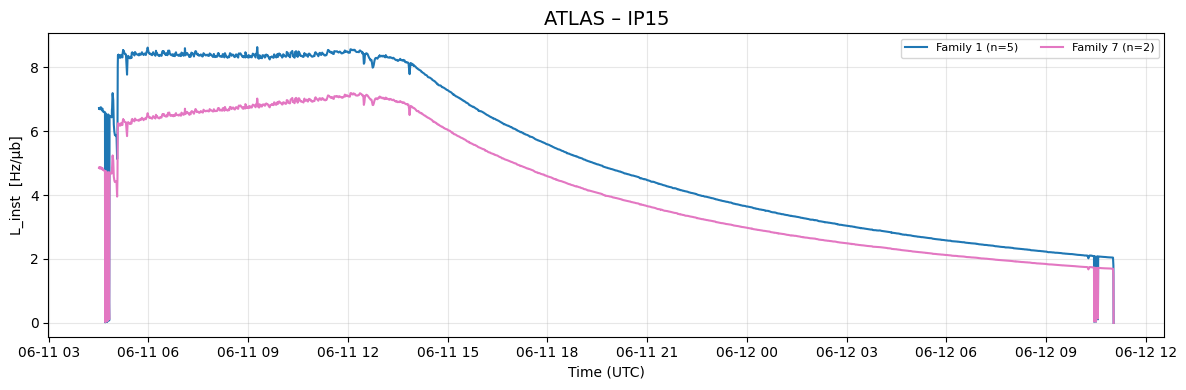

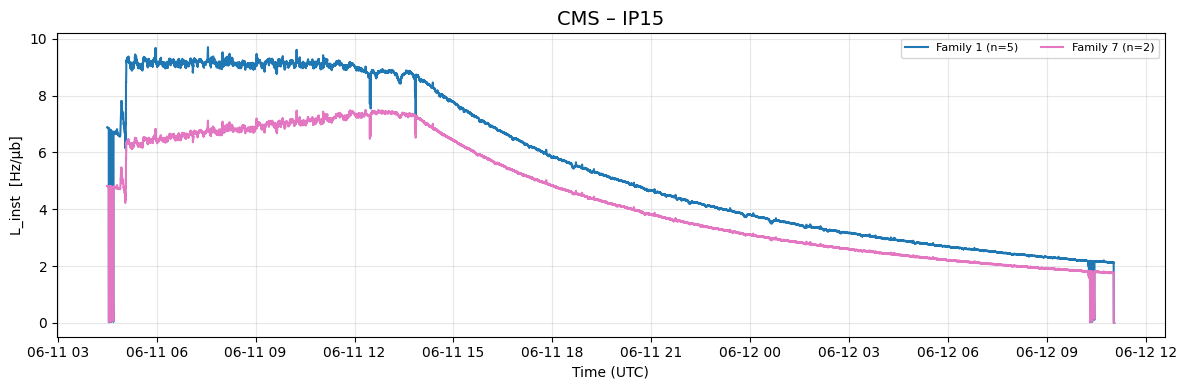

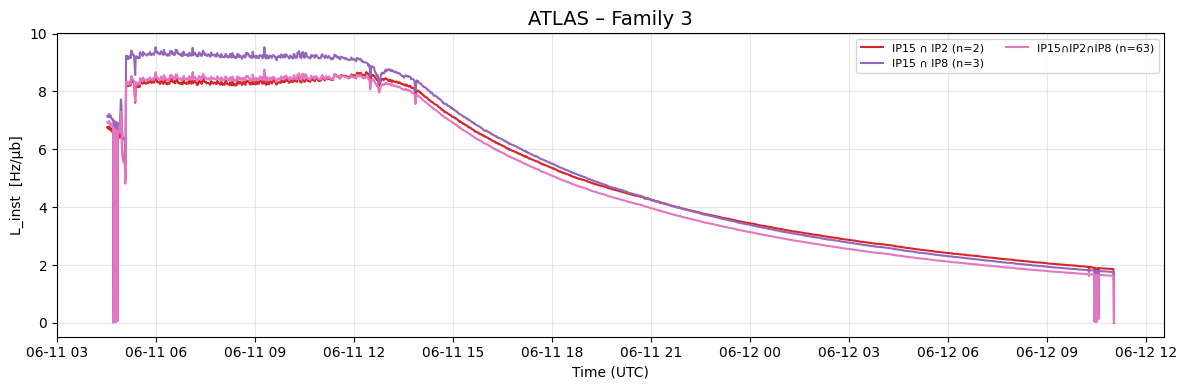

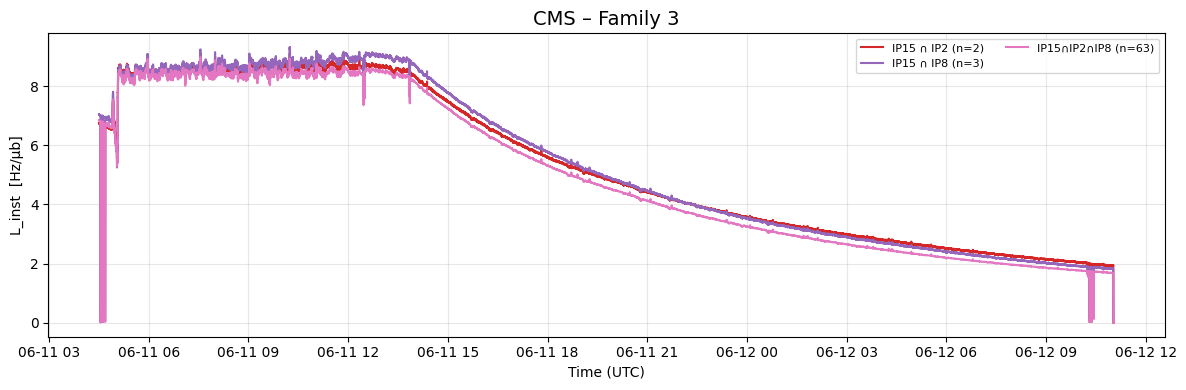

In [67]:
plot_inst_lumi("ATLAS", ip_class="IP15")
plot_inst_lumi("CMS",   ip_class="IP15")

# Plot all IP classes for Family 3
plot_inst_lumi("ATLAS", family="Family 3")
plot_inst_lumi("CMS",   family="Family 3")

# Emmitance Rates

In [68]:
# 1) Print all unique BMODEs in the entire file
all_bmodes = fbmodes["BMODE"].unique()
print("All BMODE values in the file:", all_bmodes)

All BMODE values in the file: ['FILL' 'SQUEEZE' 'NOBEAM' 'SETUP' 'INJPROB' 'BEAMDUMP' 'RAMPDOWN'
 'CYCLING' 'PRERAMP' 'RAMP' 'FLATTOP' 'INJPHYS' 'INJSTUP' 'ADJUST'
 'STABLE']
